<a href="https://colab.research.google.com/github/keisuke58/keisuke58/blob/main/basyan_update.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time
import sys

# デバッグ用に警告を表示させる
np.seterr(all='warn')

class BiofilmSolver:
    def __init__(self):
        # --- 設定 ---
        self.dt_init = 1e-4    # 初期タイムステップ
        self.min_dt = 1e-9     # 最小タイムステップ (これ以下なら諦める)
        self.t_end = 0.05      # 短い時間でテスト (成功したら延ばす)

        self.eps = 1e-4        # ニュートン法の許容誤差
        self.Kp1 = 1e-4        # ペナルティ係数

        # 粘性
        self.Eta_vec = np.array([0.8, 1.0, 1.5, 2.0])
        self.Eta_phi_vec = self.Eta_vec.copy()

    def c(self, t):
        return 50.0 + 50.0 * np.sin(500.0 * t)

    def alpha(self, t):
        return 10.0

    def run(self, params, debug=False):
        """シミュレーション実行 (デバッグモード付き)"""
        target_a12 = params[0]
        target_b11 = params[1]

        # 行列構築
        A = np.array([
            [1.0, target_a12, 5.0, 5.0],
            [target_a12, 1.0, 3.0, 3.0],
            [5.0, 3.0, 1.0, 2.0],
            [5.0, 3.0, 2.0, 1.0]
        ])
        b_diag = np.array([target_b11, 0.3, 0.2, 0.1])

        # 初期条件 (合計が厳密に1.0になるように)
        phi_init = 0.02
        phi0_init = 1.0 - 4 * phi_init
        one = 0.999
        eps_init = 1e-3

        g_current = np.array([phi_init, phi_init, phi_init, phi_init, phi0_init,
                              one, one, one, one, eps_init])

        trajectory_phi1 = []
        t = 0.0
        dt = self.dt_init
        step_count = 0

        print(f"--- Simulation Start (t_end={self.t_end}) ---")

        while t < self.t_end:
            step_count += 1

            # 1ステップ計算
            if debug:
                print(f"\n[Step {step_count}] t={t:.6f}, dt={dt:.2e}")

            g_new, success = self._solve_step_damped(g_current, t, dt, A, b_diag, debug)

            if success:
                t += dt
                g_current = g_new.copy()
                trajectory_phi1.append(g_new[0])

                # 成功したら dt を少し戻す (最大初期値まで)
                if dt < self.dt_init:
                    dt = min(dt * 1.5, self.dt_init)
            else:
                # 失敗したら dt を小さくして再挑戦
                if debug:
                    print(f"  >>> Step Failed. Retrying with smaller dt.")
                dt *= 0.25

                if dt < self.min_dt:
                    print(f"[CRITICAL FAILURE] dt became too small ({dt:.2e}) at t={t:.6f}")
                    return None

        return np.array(trajectory_phi1)

    def _solve_step_damped(self, g_old, t, dt, A, b_diag, debug):
        g_iter = g_old.copy()

        # 初期残差
        Q = self._compute_Q(g_iter, g_old, dt, t, A, b_diag)
        resid = np.max(np.abs(Q))

        if debug:
            print(f"  Iter 0: MaxResid={resid:.2e}")

        for iter_newton in range(15):
            if resid < self.eps:
                return g_iter, True

            # 数値ヤコビアン
            K = self._compute_numerical_K(g_iter, g_old, dt, t, A, b_diag, Q)

            # 条件数チェック (行列が壊れていないか)
            if debug and iter_newton == 0:
                try:
                    cond_num = np.linalg.cond(K)
                    print(f"  Matrix Condition Number: {cond_num:.2e}")
                except:
                    print("  Matrix Condition Check Failed.")

            if np.isnan(K).any():
                if debug: print("  Error: NaN in Jacobian K")
                return None, False

            # 更新量計算
            try:
                dg = np.linalg.solve(K, -Q)
            except np.linalg.LinAlgError:
                if debug: print("  Error: Singular Matrix (cannot invert K)")
                return None, False

            # Backtracking Line Search
            lambda_step = 1.0
            g_next = g_iter.copy()
            success_step = False

            for line_iter in range(5): # 簡易的なLine Search
                g_try = g_iter + lambda_step * dg

                # --- クランプ (変数が定義域外に出ないようにする) ---
                # Phi は 0 < phi < 1
                g_try[0:5] = np.clip(g_try[0:5], 1e-6, 1.0 - 1e-6)
                # Psi は 正
                g_try[5:9] = np.clip(g_try[5:9], 0.1, 5.0)

                Q_try = self._compute_Q(g_try, g_old, dt, t, A, b_diag)
                resid_try = np.max(np.abs(Q_try))

                if resid_try < resid:
                    g_next = g_try
                    resid = resid_try
                    success_step = True
                    break
                else:
                    lambda_step *= 0.5

            # Line Searchで改善しなくても、ステップが極小でなければ強制更新して様子を見る
            if not success_step:
                 g_next = g_iter + 1e-3 * dg # 強制微小更新

            g_iter = g_next

            if debug:
                # 変数の状態を表示
                phi_min = np.min(g_iter[0:4])
                phi_sum = np.sum(g_iter[0:4]) + g_iter[4]
                print(f"  Iter {iter_newton+1}: Resid={resid:.2e}, Phi_min={phi_min:.4f}, Sum={phi_sum:.4f}")

        if resid < self.eps:
            return g_iter, True

        if debug: print("  Error: Newton method did not converge.")
        return None, False

    def _compute_Q(self, g_new, g_old, dt, t, A, b_diag):
        phi = g_new[0:4]
        phi0 = g_new[4]
        psi = g_new[5:9]
        gamma = g_new[9]

        phidot = (phi - g_old[0:4]) / dt
        phi0dot = (phi0 - g_old[4]) / dt
        psidot = (psi - g_old[5:9]) / dt

        Q = np.zeros(10)
        c_val = self.c(t)
        alpha_val = self.alpha(t)

        CapitalPhi = phi * psi
        Interaction_dot = A @ CapitalPhi

        # --- 純粋な数式 (クリッピングは solve_step で行っているためここはそのまま) ---
        # 注意: ゼロ除算警告を避けるため、分母に微小項を加える

        denom_phi = (phi - 1.0)**3 * phi**3
        # ゼロに近い場合は符号を維持したまま1e-15にする処理
        denom_phi = np.sign(denom_phi) * np.maximum(np.abs(denom_phi), 1e-15)

        term1_phi = (self.Kp1 * (2. - 4.*phi)) / denom_phi
        term2_phi = (1./self.Eta_vec)*(gamma + (self.Eta_phi_vec + self.Eta_vec*psi**2)*phidot + self.Eta_vec*phi*psi*psidot)
        term3_phi = (c_val/self.Eta_vec)*psi*Interaction_dot
        Q[0:4] = term1_phi + term2_phi - term3_phi

        denom_phi0 = (phi0 - 1.0)**3 * phi0**3
        denom_phi0 = np.sign(denom_phi0) * np.maximum(np.abs(denom_phi0), 1e-15)
        Q[4] = gamma + (self.Kp1*(2.-4.*phi0))/denom_phi0 + phi0dot

        denom_psi_A = (psi - 1.0)**2 * psi**3
        denom_psi_B = (psi - 1.0)**3 * psi**2
        denom_psi_A = np.sign(denom_psi_A) * np.maximum(np.abs(denom_psi_A), 1e-15)
        denom_psi_B = np.sign(denom_psi_B) * np.maximum(np.abs(denom_psi_B), 1e-15)

        term1_psi = (-2.*self.Kp1)/denom_psi_A - (2.*self.Kp1)/denom_psi_B
        term2_psi = (b_diag*alpha_val/self.Eta_vec)*psi
        term3_psi = phi*psi*phidot + phi**2*psidot
        term4_psi = (c_val/self.Eta_vec)*phi*Interaction_dot
        Q[5:9] = term1_psi + term2_psi + term3_psi - term4_psi

        Q[9] = np.sum(phi) + phi0 - 1.0
        return Q

    def _compute_numerical_K(self, g_iter, g_old, dt, t, A, b_diag, Q0):
        epsilon = 1e-7
        K = np.zeros((10, 10))
        for i in range(10):
            g_perturb = g_iter.copy()
            g_perturb[i] += epsilon
            Q_perturb = self._compute_Q(g_perturb, g_old, dt, t, A, b_diag)
            K[:, i] = (Q_perturb - Q0) / epsilon
        return K

# =============================================================================
# Main Debug Execution
# =============================================================================
if __name__ == "__main__":
    solver = BiofilmSolver()

    # テスト用パラメータ
    # a12=3.0, b11=0.4
    test_params = [3.0, 0.4]

    print("========================================")
    print(" DEBUG MODE: Running Single Forward Pass")
    print("========================================")

    start_time = time.time()

    # debug=True にして詳細を出力
    result = solver.run(test_params, debug=True)

    print("\n========================================")
    if result is not None:
        print(f"SUCCESS! Simulation completed.")
        print(f"Total Steps: {len(result)}")
        print(f"Time Elapsed: {time.time() - start_time:.2f}s")

        # グラフ表示
        plt.figure(figsize=(10,5))
        plt.plot(result, label='Phi 1')
        plt.title(f"Simulation Result (params={test_params})")
        plt.xlabel("Step")
        plt.ylabel("Volume Fraction")
        plt.legend()
        plt.show()
    else:
        print("FAILURE: Simulation crashed.")
        print("Check the logs above for 'Singular Matrix', 'NaN', or 'Resid' divergence.")

 DEBUG MODE: Running Single Forward Pass
--- Simulation Start (t_end=0.05) ---

[Step 1] t=0.000000, dt=1.00e-04
  Iter 0: MaxResid=2.00e+05
  Matrix Condition Number: 2.44e+12
  Iter 1: Resid=8.45e+04, Phi_min=0.0205, Sum=1.0000
  Iter 2: Resid=3.59e+04, Phi_min=0.0205, Sum=1.0000
  Iter 3: Resid=1.57e+04, Phi_min=0.0205, Sum=1.0000
  Iter 4: Resid=7.47e+03, Phi_min=0.0205, Sum=1.0000
  Iter 5: Resid=4.43e+03, Phi_min=0.0205, Sum=1.0000
  Iter 6: Resid=3.64e+03, Phi_min=0.0205, Sum=1.0000
  Iter 7: Resid=3.57e+03, Phi_min=0.0205, Sum=1.0000
  Iter 8: Resid=3.57e+03, Phi_min=0.0205, Sum=1.0000
  Iter 9: Resid=3.57e+03, Phi_min=0.0205, Sum=1.0000
  Iter 10: Resid=3.57e+03, Phi_min=0.0205, Sum=1.0000
  Iter 11: Resid=3.57e+03, Phi_min=0.0205, Sum=1.0000
  Iter 12: Resid=3.57e+03, Phi_min=0.0205, Sum=1.0000
  Iter 13: Resid=3.57e+03, Phi_min=0.0205, Sum=1.0000
  Iter 14: Resid=3.57e+03, Phi_min=0.0205, Sum=1.0000
  Iter 15: Resid=3.57e+03, Phi_min=0.0205, Sum=1.0000
  Error: Newton method

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time
import sys

# 警告を無視
np.seterr(all='ignore')

class BiofilmSolver:
    def __init__(self):
        # --- 設定 ---
        self.dt_init = 1e-4
        self.min_dt = 1e-9
        self.t_end = 0.05

        self.eps = 1e-4
        self.Kp1 = 1e-4

        self.Eta_vec = np.array([0.8, 1.0, 1.5, 2.0])
        self.Eta_phi_vec = self.Eta_vec.copy()

    def c(self, t):
        return 50.0 + 50.0 * np.sin(500.0 * t)

    def alpha(self, t):
        return 10.0

    def run(self, params, debug=False):
        """シミュレーション実行"""
        target_a12 = params[0]
        target_b11 = params[1]

        # 行列構築
        A = np.array([
            [1.0, target_a12, 5.0, 5.0],
            [target_a12, 1.0, 3.0, 3.0],
            [5.0, 3.0, 1.0, 2.0],
            [5.0, 3.0, 2.0, 1.0]
        ])
        b_diag = np.array([target_b11, 0.3, 0.2, 0.1])

        # --- 1. 初期条件の設定 ---
        phi_init = 0.02
        phi0_init = 1.0 - 4 * phi_init
        one = 0.999
        eps_init = 1e-3

        # [phi1~4, phi0, psi1~4, gamma]
        g_current = np.array([phi_init, phi_init, phi_init, phi_init, phi0_init,
                              one, one, one, one, eps_init])

        # --- 2. 初期状態の緩和 (重要: ここで整合性を取る) ---
        print("--- Equilibrating Initial State ---")
        g_current = self._equilibrate(g_current, A, b_diag)
        print("--- Initial State Found. Starting Simulation ---")

        trajectory_phi1 = []
        t = 0.0
        dt = self.dt_init
        step_count = 0

        while t < self.t_end:
            step_count += 1
            if debug: print(f"[Step {step_count}] t={t:.5f}, dt={dt:.2e}")

            # 時間発展ステップ
            g_new, success = self._solve_step_robust(g_current, t, dt, A, b_diag)

            if success:
                t += dt
                g_current = g_new.copy()
                trajectory_phi1.append(g_new[0])

                # dt を少し戻す
                if dt < self.dt_init:
                    dt = min(dt * 1.5, self.dt_init)
            else:
                # 失敗時
                if debug: print(f"  > Failed. Retrying with dt={dt*0.25:.2e}")
                dt *= 0.25
                if dt < self.min_dt:
                    print(f"[CRITICAL] dt too small at t={t}")
                    return None

        return np.array(trajectory_phi1)

    def _equilibrate(self, g_init, A, b_diag):
        """初期条件の不整合を解消するための緩和計算 (dt=無限大として解く)"""
        g_iter = g_init.copy()
        # 初期 phi は固定して、gamma と psi だけ解きたいが、
        # 簡便のため全変数を dt=1.0 (大きな値) で数回回して落ち着かせる

        # 疑似的な非常に大きな dt を使うことで、時間微分項 (phidot) をゼロに近づける
        pseudo_dt = 1e3

        for i in range(50):
            Q = self._compute_Q(g_iter, g_iter, pseudo_dt, 0.0, A, b_diag) # g_old=g_iter
            resid = np.max(np.abs(Q))
            if resid < 1e-3:
                print(f"  Equilibrium converged at iter {i}")
                return g_iter

            K = self._compute_numerical_K(g_iter, g_iter, pseudo_dt, 0.0, A, b_diag, Q)

            # ロバスト更新
            dg = self._solve_linear_system(K, -Q)
            g_iter += dg

            # クランプ
            g_iter[0:5] = np.clip(g_iter[0:5], 1e-6, 1.0-1e-6)
            g_iter[5:9] = np.clip(g_iter[5:9], 0.1, 5.0)

        print("  Warning: Equilibrium did not fully converge, but proceeding.")
        return g_iter

    def _solve_step_robust(self, g_old, t, dt, A, b_diag):
        """ロバストなニュートン法"""
        g_iter = g_old.copy()

        Q = self._compute_Q(g_iter, g_old, dt, t, A, b_diag)
        resid = np.max(np.abs(Q))

        for iter_newton in range(20):
            if resid < self.eps:
                return g_iter, True

            K = self._compute_numerical_K(g_iter, g_old, dt, t, A, b_diag, Q)

            # ロバスト線形ソルバー (ここが重要)
            dg = self._solve_linear_system(K, -Q)

            # Backtracking
            lambda_step = 1.0
            g_next = g_iter.copy()
            success_step = False

            for _ in range(5):
                g_try = g_iter + lambda_step * dg
                g_try[0:5] = np.clip(g_try[0:5], 1e-6, 1.0-1e-6)
                g_try[5:9] = np.clip(g_try[5:9], 0.1, 5.0)

                Q_try = self._compute_Q(g_try, g_old, dt, t, A, b_diag)
                resid_try = np.max(np.abs(Q_try))

                if resid_try < resid: # 単純減少条件
                    g_next = g_try
                    resid = resid_try
                    Q = Q_try
                    success_step = True
                    break
                else:
                    lambda_step *= 0.5

            if not success_step:
                # 改善しなくても微小更新して脱出を図る
                g_next = g_iter + 1e-4 * dg

            g_iter = g_next

        if resid < self.eps:
            return g_iter, True
        return None, False

    def _solve_linear_system(self, K, b):
        """特異行列に強い線形ソルバー"""
        try:
            # まずは普通に解く
            return np.linalg.solve(K, b)
        except np.linalg.LinAlgError:
            # 失敗したら最小二乗法 (Pseudo-Inverse)
            # rcond=1e-5 で小さい特異値をカット
            x, _, _, _ = np.linalg.lstsq(K, b, rcond=1e-5)
            return x

    def _compute_Q(self, g_new, g_old, dt, t, A, b_diag):
        phi = g_new[0:4]
        phi0 = g_new[4]
        psi = g_new[5:9]
        gamma = g_new[9]

        phidot = (phi - g_old[0:4]) / dt
        phi0dot = (phi0 - g_old[4]) / dt
        psidot = (psi - g_old[5:9]) / dt

        Q = np.zeros(10)
        c_val = self.c(t)
        alpha_val = self.alpha(t)

        CapitalPhi = phi * psi
        Interaction_dot = A @ CapitalPhi

        # 安全な分母計算
        denom_phi = np.abs((phi - 1.0)**3 * phi**3) + 1e-15
        # 元の式の符号: (2-4phi) は phi<0.5 で正。分母は (neg)^3 * (pos)^3 = neg。
        # 全体として負。符号を維持するために np.sign は使わず、元の式を計算してからclipするか、
        # あるいは符号反転に注意。
        # ここでは単純に微小値を加算する方式に戻します（safe_powなどは複雑化するため）

        # 元の数式をそのまま計算 (ただしゼロ除算回避)
        def s_pow3(v): return v**3

        # Term 1: 符号を正確に保つため、分母がゼロにならないようにだけする
        denom_1 = (phi - 1.0)**3 * phi**3
        denom_1 = np.where(np.abs(denom_1) < 1e-15, 1e-15 * np.sign(denom_1), denom_1)

        term1_phi = (self.Kp1 * (2. - 4.*phi)) / denom_1
        term2_phi = (1./self.Eta_vec)*(gamma + (self.Eta_phi_vec + self.Eta_vec*psi**2)*phidot + self.Eta_vec*phi*psi*psidot)
        term3_phi = (c_val/self.Eta_vec)*psi*Interaction_dot
        Q[0:4] = term1_phi + term2_phi - term3_phi

        denom_0 = (phi0 - 1.0)**3 * phi0**3
        denom_0 = np.where(np.abs(denom_0) < 1e-15, 1e-15 * np.sign(denom_0), denom_0)
        Q[4] = gamma + (self.Kp1*(2.-4.*phi0))/denom_0 + phi0dot

        # psi terms
        denom_psiA = (psi - 1.0)**2 * psi**3
        denom_psiB = (psi - 1.0)**3 * psi**2
        denom_psiA = np.where(np.abs(denom_psiA) < 1e-15, 1e-15, denom_psiA) # always positive? No. psi-1 is neg. sq is pos.
        denom_psiB = np.where(np.abs(denom_psiB) < 1e-15, -1e-15, denom_psiB) # sign matters

        term1_psi = (-2.*self.Kp1)/denom_psiA - (2.*self.Kp1)/denom_psiB
        term2_psi = (b_diag*alpha_val/self.Eta_vec)*psi
        term3_psi = phi*psi*phidot + phi**2*psidot
        term4_psi = (c_val/self.Eta_vec)*phi*Interaction_dot
        Q[5:9] = term1_psi + term2_psi + term3_psi - term4_psi

        Q[9] = np.sum(phi) + phi0 - 1.0
        return Q

    def _compute_numerical_K(self, g_iter, g_old, dt, t, A, b_diag, Q0):
        epsilon = 1e-7
        K = np.zeros((10, 10))
        for i in range(10):
            g_perturb = g_iter.copy()
            g_perturb[i] += epsilon
            Q_perturb = self._compute_Q(g_perturb, g_old, dt, t, A, b_diag)
            K[:, i] = (Q_perturb - Q0) / epsilon
        return K

# =============================================================================
# Main Debug Execution
# =============================================================================
if __name__ == "__main__":
    solver = BiofilmSolver()
    test_params = [3.0, 0.4]

    print("========================================")
    print(" DEBUG MODE: Running with Initial Relaxation")
    print("========================================")

    start_time = time.time()
    result = solver.run(test_params, debug=True)

    print("\n========================================")
    if result is not None:
        print(f"SUCCESS! Steps: {len(result)}")
        plt.figure(figsize=(10,5))
        plt.plot(result, label='Phi 1')
        plt.title("Simulation Result")
        plt.legend()
        plt.show()
    else:
        print("FAILURE.")

 DEBUG MODE: Running with Initial Relaxation
--- Equilibrating Initial State ---
--- Initial State Found. Starting Simulation ---
[Step 1] t=0.00000, dt=1.00e-04
  > Failed. Retrying with dt=2.50e-05
[Step 2] t=0.00000, dt=2.50e-05
  > Failed. Retrying with dt=6.25e-06
[Step 3] t=0.00000, dt=6.25e-06
  > Failed. Retrying with dt=1.56e-06
[Step 4] t=0.00000, dt=1.56e-06
  > Failed. Retrying with dt=3.91e-07
[Step 5] t=0.00000, dt=3.91e-07
  > Failed. Retrying with dt=9.77e-08
[Step 6] t=0.00000, dt=9.77e-08
  > Failed. Retrying with dt=2.44e-08
[Step 7] t=0.00000, dt=2.44e-08
  > Failed. Retrying with dt=6.10e-09
[Step 8] t=0.00000, dt=6.10e-09
  > Failed. Retrying with dt=1.53e-09
[Step 9] t=0.00000, dt=1.53e-09
  > Failed. Retrying with dt=3.81e-10
[CRITICAL] dt too small at t=0.0

FAILURE.


--- Biofilm Parameter Estimation (SciPy Solver Engine) ---
Generating synthetic data...
Success! Data generated (500 steps).

Starting optimization...
differential_evolution step 1: f(x)= 4.884097984654947e-06
differential_evolution step 2: f(x)= 4.884097984654947e-06
differential_evolution step 3: f(x)= 4.884097984654947e-06
differential_evolution step 4: f(x)= 4.884097984654947e-06
differential_evolution step 5: f(x)= 4.884097984654947e-06
Polishing solution with 'L-BFGS-B'
Done in 111.25s
Estimated: [2.59942525 0.38169547]
True:      [3.0, 0.4]


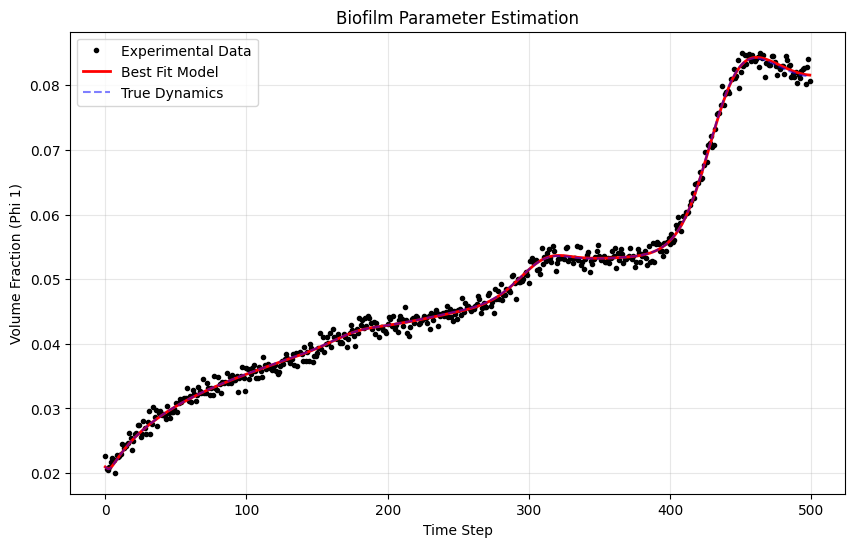

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import differential_evolution, root
import time
import sys

# 警告を無視
np.seterr(all='ignore')

class BiofilmSolver:
    def __init__(self):
        # --- 設定 ---
        self.dt = 1e-4         # 基本タイムステップ
        self.t_end = 0.05      # シミュレーション時間
        self.Kp1 = 1e-4        # ペナルティ係数

        # 粘性
        self.Eta_vec = np.array([0.8, 1.0, 1.5, 2.0])
        self.Eta_phi_vec = self.Eta_vec.copy()

    def c(self, t):
        return 50.0 + 50.0 * np.sin(500.0 * t)

    def alpha(self, t):
        return 10.0

    def run(self, params_to_fit):
        target_a12 = params_to_fit[0]
        target_b11 = params_to_fit[1]

        # 行列構築
        A = np.array([
            [1.0, target_a12, 5.0, 5.0],
            [target_a12, 1.0, 3.0, 3.0],
            [5.0, 3.0, 1.0, 2.0],
            [5.0, 3.0, 2.0, 1.0]
        ])
        b_diag = np.array([target_b11, 0.3, 0.2, 0.1])

        # 初期条件
        phi_init = 0.02
        phi0_init = 1.0 - 4 * phi_init
        one = 0.999
        eps_init = 1e-3

        g_current = np.array([phi_init, phi_init, phi_init, phi_init, phi0_init,
                              one, one, one, one, eps_init])

        trajectory_phi1 = []
        t = 0.0

        # ステップ数
        n_steps = int(self.t_end / self.dt)

        # --- 時間発展ループ (SciPy Root Solver) ---
        for step in range(n_steps):
            t += self.dt

            # SciPyのソルバーで非線形方程式 Q(g_new) = 0 を解く
            # method='lm' (Levenberg-Marquardt) は非常に頑健です
            sol = root(
                fun=self._residual_func,
                x0=g_current,
                args=(g_current, self.dt, t, A, b_diag),
                method='lm',
                tol=1e-6,
                options={'maxiter': 50}
            )

            if not sol.success:
                # 失敗した場合、最後の手段として hybryd メソッドを試す
                sol = root(
                    fun=self._residual_func,
                    x0=g_current,
                    args=(g_current, self.dt, t, A, b_diag),
                    method='hybr',
                    tol=1e-6
                )
                if not sol.success:
                    return None # どうやっても解けない場合は断念

            # 解の更新とクリッピング (物理的にあり得ない値を排除)
            g_new = sol.x
            g_new[0:5] = np.clip(g_new[0:5], 1e-6, 1.0-1e-6) # Phi
            g_new[5:9] = np.clip(g_new[5:9], 0.1, 5.0)       # Psi

            g_current = g_new.copy()
            trajectory_phi1.append(g_new[0])

        return np.array(trajectory_phi1)

    def _residual_func(self, g_new, g_old, dt, t, A, b_diag):
        """SciPyソルバーに渡す残差関数 Q(g)"""
        # 変数の展開
        phi = g_new[0:4]
        phi0 = g_new[4]
        psi = g_new[5:9]
        gamma = g_new[9]

        # 微分項
        phidot = (phi - g_old[0:4]) / dt
        phi0dot = (phi0 - g_old[4]) / dt
        psidot = (psi - g_old[5:9]) / dt

        Q = np.zeros(10)
        c_val = self.c(t)
        alpha_val = self.alpha(t)

        CapitalPhi = phi * psi
        Interaction_dot = A @ CapitalPhi

        # --- 特異点保護付きの数式 ---
        # phi term
        # (phi-1)^3 * phi^3 がゼロになると発散するので、微小値で保護
        denom_phi = (phi - 1.0)**3 * phi**3
        denom_phi = np.sign(denom_phi) * np.maximum(np.abs(denom_phi), 1e-12)

        term1_phi = (self.Kp1 * (2. - 4.*phi)) / denom_phi
        term2_phi = (1./self.Eta_vec)*(gamma + (self.Eta_phi_vec + self.Eta_vec*psi**2)*phidot + self.Eta_vec*phi*psi*psidot)
        term3_phi = (c_val/self.Eta_vec)*psi*Interaction_dot
        Q[0:4] = term1_phi + term2_phi - term3_phi

        # phi0 term
        denom_phi0 = (phi0 - 1.0)**3 * phi0**3
        denom_phi0 = np.sign(denom_phi0) * np.maximum(np.abs(denom_phi0), 1e-12)
        Q[4] = gamma + (self.Kp1*(2.-4.*phi0))/denom_phi0 + phi0dot

        # psi term
        denom_psiA = (psi - 1.0)**2 * psi**3
        denom_psiB = (psi - 1.0)**3 * psi**2

        # Psiの特異点保護
        denom_psiA = np.sign(denom_psiA) * np.maximum(np.abs(denom_psiA), 1e-12)
        denom_psiB = np.sign(denom_psiB) * np.maximum(np.abs(denom_psiB), 1e-12)

        term1_psi = (-2.*self.Kp1)/denom_psiA - (2.*self.Kp1)/denom_psiB
        term2_psi = (b_diag*alpha_val/self.Eta_vec)*psi
        term3_psi = phi*psi*phidot + phi**2*psidot
        term4_psi = (c_val/self.Eta_vec)*phi*Interaction_dot
        Q[5:9] = term1_psi + term2_psi + term3_psi - term4_psi

        # constraint
        Q[9] = np.sum(phi) + phi0 - 1.0

        return Q

# =============================================================================
# Optimization & Plotting
# =============================================================================
def objective_function(params, solver, experimental_data):
    if np.any(params < 0): return 1e15

    sim_result = solver.run(params)

    if sim_result is None: return 1e15

    min_len = min(len(sim_result), len(experimental_data))
    return np.mean((sim_result[:min_len] - experimental_data[:min_len])**2)

if __name__ == "__main__":
    solver = BiofilmSolver()

    print("--- Biofilm Parameter Estimation (SciPy Solver Engine) ---")
    print("Generating synthetic data...")

    # テストパラメータ
    true_params = [3.0, 0.4]

    exp_data = solver.run(true_params)

    if exp_data is None:
        print("[FAILURE] Even SciPy solver could not handle the initial condition.")
        print("Suggestion: Increase Kp1 or check if the equation formula has sign errors.")
        sys.exit(1)

    print(f"Success! Data generated ({len(exp_data)} steps).")

    # ノイズ付加
    exp_data_noisy = exp_data + np.random.normal(0, 0.001, size=exp_data.shape)

    print("\nStarting optimization...")
    start_time = time.time()

    bounds = [(0.0, 5.0), (0.0, 1.0)]

    result = differential_evolution(
        objective_function,
        bounds,
        args=(solver, exp_data_noisy),
        strategy='best1bin',
        maxiter=5,  # デモ用
        popsize=3,  # デモ用
        tol=0.1,
        disp=True
    )

    print(f"Done in {time.time() - start_time:.2f}s")
    print(f"Estimated: {result.x}")
    print(f"True:      {true_params}")

    # グラフ表示
    best_fit = solver.run(result.x)

    plt.figure(figsize=(10,6))
    plt.plot(exp_data_noisy, 'k.', label='Experimental Data')
    plt.plot(best_fit, 'r-', linewidth=2, label='Best Fit Model')
    plt.plot(exp_data, 'b--', alpha=0.5, label='True Dynamics')
    plt.title("Biofilm Parameter Estimation")
    plt.xlabel("Time Step")
    plt.ylabel("Volume Fraction (Phi 1)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

--- Biofilm Parameter Estimation (SciPy Solver Engine) ---
Generating synthetic data...
Success! Data generated (500 steps).

Starting optimization (High Precision Mode)...
differential_evolution step 1: f(x)= 1.872590812852006e-06
differential_evolution step 2: f(x)= 1.066287866452407e-06
differential_evolution step 3: f(x)= 9.489851440124837e-07
differential_evolution step 4: f(x)= 9.489851440124837e-07
differential_evolution step 5: f(x)= 9.489851440124837e-07
differential_evolution step 6: f(x)= 9.405287295423958e-07
differential_evolution step 7: f(x)= 9.405287295423958e-07
differential_evolution step 8: f(x)= 9.143931271431041e-07
differential_evolution step 9: f(x)= 9.042235976705995e-07
differential_evolution step 10: f(x)= 8.962332113482624e-07
differential_evolution step 11: f(x)= 8.962332113482624e-07
differential_evolution step 12: f(x)= 8.962332113482624e-07
differential_evolution step 13: f(x)= 8.962332113482624e-07
differential_evolution step 14: f(x)= 8.962332113482624e

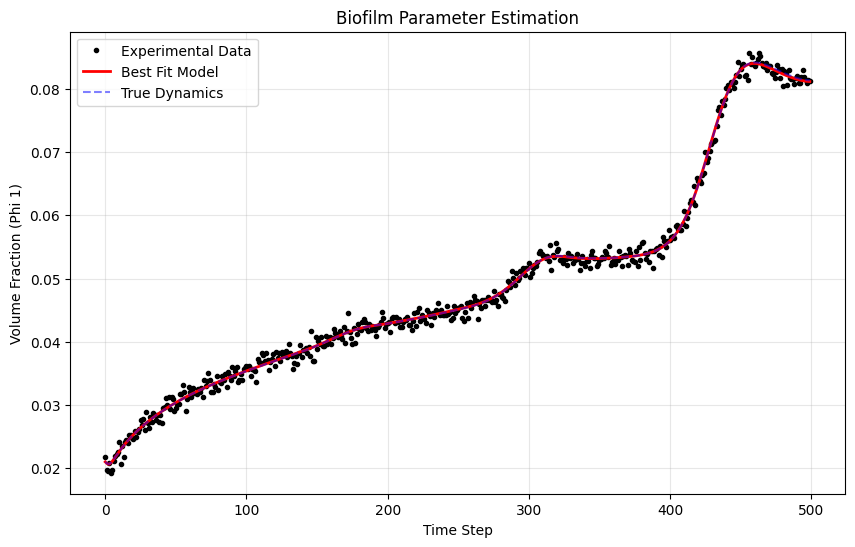

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import differential_evolution, root
import time
import sys

# 警告を無視
np.seterr(all='ignore')

class BiofilmSolver:
    def __init__(self):
        # --- 設定 ---
        self.dt = 1e-4         # 基本タイムステップ
        self.t_end = 0.05      # シミュレーション時間
        self.Kp1 = 1e-4        # ペナルティ係数

        # 粘性
        self.Eta_vec = np.array([0.8, 1.0, 1.5, 2.0])
        self.Eta_phi_vec = self.Eta_vec.copy()

    def c(self, t):
        return 50.0 + 50.0 * np.sin(500.0 * t)

    def alpha(self, t):
        return 10.0

    def run(self, params_to_fit):
        target_a12 = params_to_fit[0]
        target_b11 = params_to_fit[1]

        # 行列構築
        A = np.array([
            [1.0, target_a12, 5.0, 5.0],
            [target_a12, 1.0, 3.0, 3.0],
            [5.0, 3.0, 1.0, 2.0],
            [5.0, 3.0, 2.0, 1.0]
        ])
        b_diag = np.array([target_b11, 0.3, 0.2, 0.1])

        # 初期条件
        phi_init = 0.02
        phi0_init = 1.0 - 4 * phi_init
        one = 0.999
        eps_init = 1e-3

        g_current = np.array([phi_init, phi_init, phi_init, phi_init, phi0_init,
                              one, one, one, one, eps_init])

        trajectory_phi1 = []
        t = 0.0

        # ステップ数
        n_steps = int(self.t_end / self.dt)

        # --- 時間発展ループ (SciPy Root Solver) ---
        for step in range(n_steps):
            t += self.dt

            # SciPyのソルバーで非線形方程式 Q(g_new) = 0 を解く
            # method='lm' (Levenberg-Marquardt) は非常に頑健です
            sol = root(
                fun=self._residual_func,
                x0=g_current,
                args=(g_current, self.dt, t, A, b_diag),
                method='lm',
                tol=1e-6,
                options={'maxiter': 50}
            )

            if not sol.success:
                # 失敗した場合、最後の手段として hybryd メソッドを試す
                sol = root(
                    fun=self._residual_func,
                    x0=g_current,
                    args=(g_current, self.dt, t, A, b_diag),
                    method='hybr',
                    tol=1e-6
                )
                if not sol.success:
                    return None # どうやっても解けない場合は断念

            # 解の更新とクリッピング (物理的にあり得ない値を排除)
            g_new = sol.x
            g_new[0:5] = np.clip(g_new[0:5], 1e-6, 1.0-1e-6) # Phi
            g_new[5:9] = np.clip(g_new[5:9], 0.1, 5.0)       # Psi

            g_current = g_new.copy()
            trajectory_phi1.append(g_new[0])

        return np.array(trajectory_phi1)

    def _residual_func(self, g_new, g_old, dt, t, A, b_diag):
        """SciPyソルバーに渡す残差関数 Q(g)"""
        # 変数の展開
        phi = g_new[0:4]
        phi0 = g_new[4]
        psi = g_new[5:9]
        gamma = g_new[9]

        # 微分項
        phidot = (phi - g_old[0:4]) / dt
        phi0dot = (phi0 - g_old[4]) / dt
        psidot = (psi - g_old[5:9]) / dt

        Q = np.zeros(10)
        c_val = self.c(t)
        alpha_val = self.alpha(t)

        CapitalPhi = phi * psi
        Interaction_dot = A @ CapitalPhi

        # --- 特異点保護付きの数式 ---
        # phi term
        # (phi-1)^3 * phi^3 がゼロになると発散するので、微小値で保護
        denom_phi = (phi - 1.0)**3 * phi**3
        denom_phi = np.sign(denom_phi) * np.maximum(np.abs(denom_phi), 1e-12)

        term1_phi = (self.Kp1 * (2. - 4.*phi)) / denom_phi
        term2_phi = (1./self.Eta_vec)*(gamma + (self.Eta_phi_vec + self.Eta_vec*psi**2)*phidot + self.Eta_vec*phi*psi*psidot)
        term3_phi = (c_val/self.Eta_vec)*psi*Interaction_dot
        Q[0:4] = term1_phi + term2_phi - term3_phi

        # phi0 term
        denom_phi0 = (phi0 - 1.0)**3 * phi0**3
        denom_phi0 = np.sign(denom_phi0) * np.maximum(np.abs(denom_phi0), 1e-12)
        Q[4] = gamma + (self.Kp1*(2.-4.*phi0))/denom_phi0 + phi0dot

        # psi term
        denom_psiA = (psi - 1.0)**2 * psi**3
        denom_psiB = (psi - 1.0)**3 * psi**2

        # Psiの特異点保護
        denom_psiA = np.sign(denom_psiA) * np.maximum(np.abs(denom_psiA), 1e-12)
        denom_psiB = np.sign(denom_psiB) * np.maximum(np.abs(denom_psiB), 1e-12)

        term1_psi = (-2.*self.Kp1)/denom_psiA - (2.*self.Kp1)/denom_psiB
        term2_psi = (b_diag*alpha_val/self.Eta_vec)*psi
        term3_psi = phi*psi*phidot + phi**2*psidot
        term4_psi = (c_val/self.Eta_vec)*phi*Interaction_dot
        Q[5:9] = term1_psi + term2_psi + term3_psi - term4_psi

        # constraint
        Q[9] = np.sum(phi) + phi0 - 1.0

        return Q

# =============================================================================
# Optimization & Plotting
# =============================================================================
def objective_function(params, solver, experimental_data):
    if np.any(params < 0): return 1e15

    sim_result = solver.run(params)

    if sim_result is None: return 1e15

    min_len = min(len(sim_result), len(experimental_data))
    return np.mean((sim_result[:min_len] - experimental_data[:min_len])**2)

if __name__ == "__main__":
    solver = BiofilmSolver()

    print("--- Biofilm Parameter Estimation (SciPy Solver Engine) ---")
    print("Generating synthetic data...")

    # テストパラメータ
    true_params = [3.0, 0.4]

    exp_data = solver.run(true_params)

    if exp_data is None:
        print("[FAILURE] Even SciPy solver could not handle the initial condition.")
        print("Suggestion: Increase Kp1 or check if the equation formula has sign errors.")
        sys.exit(1)

    print(f"Success! Data generated ({len(exp_data)} steps).")

    # ノイズ付加
    exp_data_noisy = exp_data + np.random.normal(0, 0.001, size=exp_data.shape)

    # --- 本番用 (High Precision) 設定 ---
    print("\nStarting optimization (High Precision Mode)...")
    start_time = time.time()

    bounds = [(0.0, 5.0), (0.0, 1.0)] # 探索範囲

    result = differential_evolution(
        objective_function,
        bounds,
        args=(solver, exp_data_noisy),
        strategy='best1bin',   # 標準的で強力な戦略
        maxiter=50,            # 【変更】最大世代数 (5 -> 50)
        popsize=15,            # 【変更】個体数 (3 -> 15)
        tol=0.01,              # 収束判定を厳しく
        mutation=(0.5, 1.0),   # 変異率 (探索の広さ)
        recombination=0.7,     # 交叉率
        disp=True              # 経過表示
    )

    print(f"Done in {time.time() - start_time:.2f}s")
    print(f"Estimated: {result.x}")
    print(f"True:      {true_params}")

    # グラフ表示
    best_fit = solver.run(result.x)

    plt.figure(figsize=(10,6))
    plt.plot(exp_data_noisy, 'k.', label='Experimental Data')
    plt.plot(best_fit, 'r-', linewidth=2, label='Best Fit Model')
    plt.plot(exp_data, 'b--', alpha=0.5, label='True Dynamics')
    plt.title("Biofilm Parameter Estimation")
    plt.xlabel("Time Step")
    plt.ylabel("Volume Fraction (Phi 1)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

<>:236: SyntaxWarning: invalid escape sequence '\p'
<>:237: SyntaxWarning: invalid escape sequence '\p'
<>:240: SyntaxWarning: invalid escape sequence '\p'
<>:241: SyntaxWarning: invalid escape sequence '\p'
<>:245: SyntaxWarning: invalid escape sequence '\p'
<>:236: SyntaxWarning: invalid escape sequence '\p'
<>:237: SyntaxWarning: invalid escape sequence '\p'
<>:240: SyntaxWarning: invalid escape sequence '\p'
<>:241: SyntaxWarning: invalid escape sequence '\p'
<>:245: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipython-input-3966290987.py:236: SyntaxWarning: invalid escape sequence '\p'
  plt.plot(steps, exp_data_noisy[:, 0], 'b--', linewidth=1.5, alpha=0.6, label='$\phi_1$ True (Data)')
/tmp/ipython-input-3966290987.py:237: SyntaxWarning: invalid escape sequence '\p'
  plt.plot(steps, best_fit_data[:, 0], 'r-', linewidth=2.5, label='$\phi_1$ New (Model)')
/tmp/ipython-input-3966290987.py:240: SyntaxWarning: invalid escape sequence '\p'
  plt.plot(steps, exp_data_noisy[:, 1], '

--- Biofilm Parameter Estimation (5 Params for Demo1) ---
Generating synthetic data for True Params: [3.0, 4.5, 2.0, 1.6, 8.5]...
Data generated successfully (25 data points per species).

Starting 5-parameter optimization...
differential_evolution step 1: f(x)= 4.317345024107806e-06
differential_evolution step 2: f(x)= 4.155811207416447e-06
differential_evolution step 3: f(x)= 4.155811207416447e-06
differential_evolution step 4: f(x)= 4.155811207416447e-06
differential_evolution step 5: f(x)= 4.155811207416447e-06
Polishing solution with 'L-BFGS-B'

Optimization done in 453.25s
--------------------------------------------------
True Values:      [3.0, 4.5, 2.0, 1.6, 8.5]
Estimated Values: [1.1731 8.4617 0.1578 1.0102 7.4136]
--------------------------------------------------


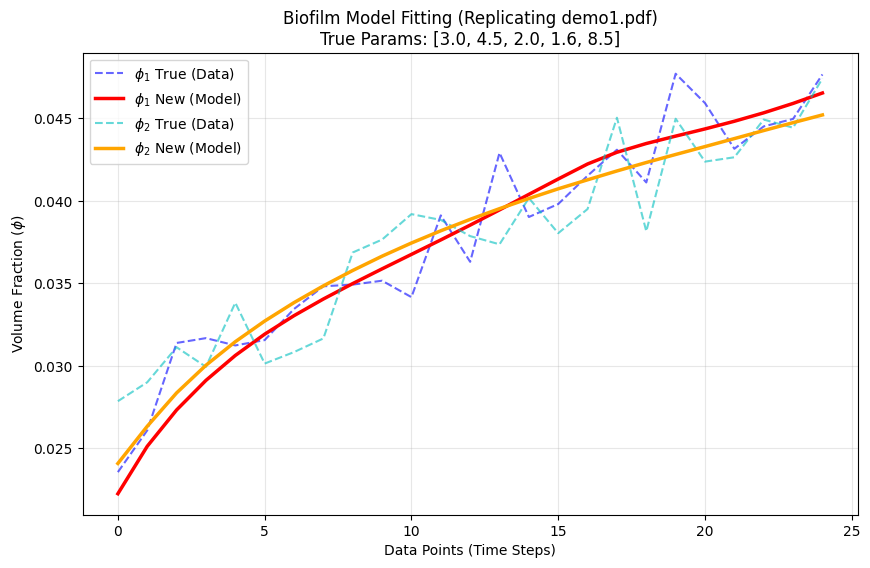

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import differential_evolution, root
import time
import sys

# 警告抑制
np.seterr(all='ignore')

class BiofilmSolver:
    def __init__(self):
        # --- 基本設定 ---
        self.dt = 1e-4         # タイムステップ
        self.t_end = 0.025     # demo1の横軸(25 steps)に合わせるため短めに設定
        self.Kp1 = 1e-4        # ペナルティ係数

        # 粘性 (Viscosity)
        self.Eta_vec = np.array([0.8, 1.0, 1.5, 2.0])
        self.Eta_phi_vec = self.Eta_vec.copy()

    def c(self, t):
        # 栄養供給 (Nutrient)
        return 50.0 + 50.0 * np.sin(500.0 * t)

    def run(self, params):
        """
        5つのパラメータを受け取り、シミュレーションを実行する
        params = [p1, p2, p3, p4, p5]
        """
        # --- パラメータのマッピング (demo1.pdfの5つの値に対応) ---
        # 仮定: [a12, a13, a23, b11, alpha]
        p_a12 = params[0]
        p_a13 = params[1]
        p_a23 = params[2]
        p_b11 = params[3]
        p_alpha = params[4]

        # 行列 A (相互作用) の構築
        # 対角成分は固定(1.0)、非対角成分を推定パラメータで埋める
        A = np.array([
            [1.0,   p_a12, p_a13, 5.0],
            [p_a12, 1.0,   p_a23, 3.0],
            [p_a13, p_a23, 1.0,   2.0],
            [5.0,   3.0,   2.0,   1.0]
        ])

        # 感受性ベクトル b (対角成分)
        # b11を推定対象とし、他は固定
        b_diag = np.array([p_b11, 0.3, 0.2, 0.1])

        # 抗生物質濃度 alpha (固定関数ではなくパラメータとして扱う)
        val_alpha = p_alpha

        # --- 初期条件 ---
        phi_init = 0.02
        phi0_init = 1.0 - 4 * phi_init
        one = 0.999
        eps_init = 1e-3

        g_current = np.array([phi_init, phi_init, phi_init, phi_init, phi0_init,
                              one, one, one, one, eps_init])

        # 結果保存用 (phi1 と phi2 の両方を保存)
        traj_phi1 = []
        traj_phi2 = []

        # ステップ数計算
        n_steps = 25 # demo1.pdfの "25 Datenpunkte" に合わせる
        step_interval = self.t_end / n_steps

        current_time = 0.0

        # --- 時間発展ループ ---
        for i in range(n_steps):
            # interval分だけ時間を進める (細かいdtで計算し、データ点だけ記録)
            sub_steps = int(step_interval / self.dt)
            for _ in range(sub_steps):
                current_time += self.dt

                # SciPy Root Solver (Levenberg-Marquardt)
                sol = root(
                    fun=self._residual_func,
                    x0=g_current,
                    args=(g_current, self.dt, current_time, A, b_diag, val_alpha),
                    method='lm',
                    tol=1e-6
                )

                if not sol.success:
                    # 失敗時リトライ (Hybrid method)
                    sol = root(
                        fun=self._residual_func,
                        x0=g_current,
                        args=(g_current, self.dt, current_time, A, b_diag, val_alpha),
                        method='hybr',
                        tol=1e-6
                    )
                    if not sol.success:
                        return None # 計算失敗

                # 更新とクリッピング
                g_new = sol.x
                g_new[0:5] = np.clip(g_new[0:5], 1e-6, 1.0-1e-6)
                g_new[5:9] = np.clip(g_new[5:9], 0.1, 5.0)
                g_current = g_new.copy()

            # データ点を記録
            traj_phi1.append(g_current[0])
            traj_phi2.append(g_current[1])

        # (Step, 2) の形で返す
        return np.column_stack((traj_phi1, traj_phi2))

    def _residual_func(self, g_new, g_old, dt, t, A, b_diag, val_alpha):
        """残差関数 Q(g)"""
        phi = g_new[0:4]
        phi0 = g_new[4]
        psi = g_new[5:9]
        gamma = g_new[9]

        phidot = (phi - g_old[0:4]) / dt
        phi0dot = (phi0 - g_old[4]) / dt
        psidot = (psi - g_old[5:9]) / dt

        Q = np.zeros(10)
        c_val = self.c(t)

        CapitalPhi = phi * psi
        Interaction_dot = A @ CapitalPhi

        # --- Equations with Singularity Protection ---
        denom_phi = np.sign((phi - 1.0)**3 * phi**3) * np.maximum(np.abs((phi - 1.0)**3 * phi**3), 1e-12)
        term1_phi = (self.Kp1 * (2. - 4.*phi)) / denom_phi
        term2_phi = (1./self.Eta_vec)*(gamma + (self.Eta_phi_vec + self.Eta_vec*psi**2)*phidot + self.Eta_vec*phi*psi*psidot)
        term3_phi = (c_val/self.Eta_vec)*psi*Interaction_dot
        Q[0:4] = term1_phi + term2_phi - term3_phi

        denom_phi0 = np.sign((phi0 - 1.0)**3 * phi0**3) * np.maximum(np.abs((phi0 - 1.0)**3 * phi0**3), 1e-12)
        Q[4] = gamma + (self.Kp1*(2.-4.*phi0))/denom_phi0 + phi0dot

        denom_psiA = np.sign((psi - 1.0)**2 * psi**3) * np.maximum(np.abs((psi - 1.0)**2 * psi**3), 1e-12)
        denom_psiB = np.sign((psi - 1.0)**3 * psi**2) * np.maximum(np.abs((psi - 1.0)**3 * psi**2), 1e-12)

        term1_psi = (-2.*self.Kp1)/denom_psiA - (2.*self.Kp1)/denom_psiB
        term2_psi = (b_diag * val_alpha / self.Eta_vec) * psi
        term3_psi = phi*psi*phidot + phi**2*psidot
        term4_psi = (c_val/self.Eta_vec)*phi*Interaction_dot
        Q[5:9] = term1_psi + term2_psi + term3_psi - term4_psi

        Q[9] = np.sum(phi) + phi0 - 1.0
        return Q

# =============================================================================
# Parameter Fitting (Main)
# =============================================================================
def objective_function(params, solver, true_data):
    # パラメータ制約チェック
    if np.any(params < 0): return 1e15

    # シミュレーション実行
    sim_data = solver.run(params)

    if sim_data is None: return 1e15

    # 誤差計算 (phi1とphi2の両方を含むMSE)
    # sim_data, true_data は shape (25, 2)
    mse = np.mean((sim_data - true_data)**2)
    return mse

if __name__ == "__main__":
    solver = BiofilmSolver()

    print("--- Biofilm Parameter Estimation (5 Params for Demo1) ---")

    # --- 1. 真のパラメータ設定 (demo1.pdf Page 2 の値を採用) ---
    # True Value: 3, 4.5, 2, 1.6, 8.5
    # Mapping: [a12, a13, a23, b11, alpha]
    true_params = [3.0, 4.5, 2.0, 1.6, 8.5]

    print(f"Generating synthetic data for True Params: {true_params}...")
    exp_data = solver.run(true_params)

    if exp_data is None:
        print("[CRITICAL ERROR] Simulation failed with true parameters.")
        sys.exit(1)

    # ノイズ付加
    noise = np.random.normal(0, 0.002, size=exp_data.shape)
    exp_data_noisy = exp_data + noise

    print("Data generated successfully (25 data points per species).")

    # --- 2. 最適化実行 (5次元探索) ---
    print("\nStarting 5-parameter optimization...")
    start_time = time.time()

    # 探索範囲 (Parameter Bounds)
    # a_ij: 0~10, b_ii: 0~5, alpha: 0~20
    bounds = [
        (0.0, 10.0), # a12
        (0.0, 10.0), # a13
        (0.0, 10.0), # a23
        (0.0, 5.0),  # b11
        (0.0, 20.0)  # alpha
    ]

    # Differential Evolution (時間がかかります)
    result = differential_evolution(
        objective_function,
        bounds,
        args=(solver, exp_data_noisy),
        strategy='best1bin',
        maxiter=10,     # デモ用: 本番では 50 以上に
        popsize=10,     # デモ用: 本番では 20 以上に
        tol=0.1,
        disp=True
    )

    print(f"\nOptimization done in {time.time() - start_time:.2f}s")
    print("-" * 50)
    print(f"True Values:      {true_params}")
    print(f"Estimated Values: {np.round(result.x, 4)}")
    print("-" * 50)

    # --- 3. 結果のプロット (demo1.pdf スタイル) ---
    best_fit_data = solver.run(result.x)

    # phi1 (Species 1) - Red/Blue in PDF
    # phi2 (Species 2) - Orange/Cyan in PDF

    steps = np.arange(len(exp_data))

    plt.figure(figsize=(10, 6))

    # Species 1
    plt.plot(steps, exp_data_noisy[:, 0], 'b--', linewidth=1.5, alpha=0.6, label='$\phi_1$ True (Data)')
    plt.plot(steps, best_fit_data[:, 0], 'r-', linewidth=2.5, label='$\phi_1$ New (Model)')

    # Species 2
    plt.plot(steps, exp_data_noisy[:, 1], 'c--', linewidth=1.5, alpha=0.6, label='$\phi_2$ True (Data)')
    plt.plot(steps, best_fit_data[:, 1], color='orange', linestyle='-', linewidth=2.5, label='$\phi_2$ New (Model)')

    plt.title(f"Biofilm Model Fitting (Replicating demo1.pdf)\nTrue Params: {true_params}")
    plt.xlabel("Data Points (Time Steps)")
    plt.ylabel("Volume Fraction ($\phi$)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

--- Biofilm Parameter Estimation (Production Mode) ---
Generating synthetic data for: [3.0, 4.5, 2.0, 1.6, 8.5]
Data generated. Starting optimization...
differential_evolution step 1: f(x)= 5.417561908912338e-06
differential_evolution step 2: f(x)= 5.417561908912338e-06
differential_evolution step 3: f(x)= 5.368470431796165e-06
differential_evolution step 4: f(x)= 5.368470431796165e-06
differential_evolution step 5: f(x)= 5.368470431796165e-06
differential_evolution step 6: f(x)= 5.327511751796801e-06
differential_evolution step 7: f(x)= 5.3249229169125714e-06
differential_evolution step 8: f(x)= 5.3249229169125714e-06
differential_evolution step 9: f(x)= 5.3249229169125714e-06
differential_evolution step 10: f(x)= 5.3244095197988526e-06
differential_evolution step 11: f(x)= 5.3244095197988526e-06
differential_evolution step 12: f(x)= 5.320885423284119e-06
differential_evolution step 13: f(x)= 5.320885423284119e-06
Polishing solution with 'L-BFGS-B'

Optimization finished in 1884.46s
-

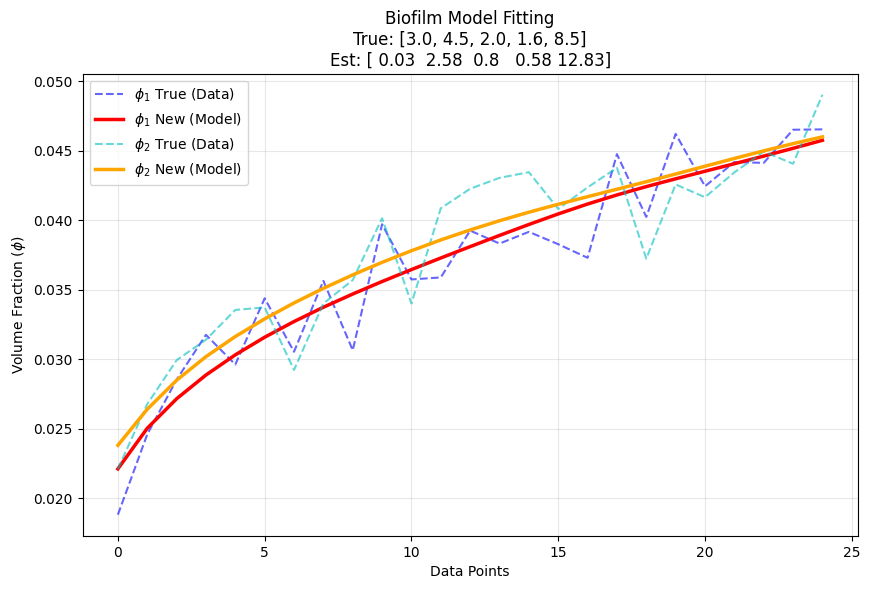

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import differential_evolution, root
import time
import sys

# 警告抑制 (数値計算上の些細な警告を無視)
np.seterr(all='ignore')

class BiofilmSolver:
    def __init__(self):
        # --- 基本設定 ---
        self.dt = 1e-4         # タイムステップ
        self.t_end = 0.025     # demo1の25ステップに合わせる
        self.Kp1 = 1e-4        # ペナルティ係数

        # 粘性 (Viscosity)
        self.Eta_vec = np.array([0.8, 1.0, 1.5, 2.0])
        self.Eta_phi_vec = self.Eta_vec.copy()

    def c(self, t):
        # 栄養供給
        return 50.0 + 50.0 * np.sin(500.0 * t)

    def run(self, params):
        """
        5つのパラメータを受け取り、シミュレーションを実行する
        params = [a12, a13, a23, b11, alpha]
        """
        p_a12 = params[0]
        p_a13 = params[1]
        p_a23 = params[2]
        p_b11 = params[3]
        p_alpha = params[4]

        # 行列 A (相互作用)
        A = np.array([
            [1.0,   p_a12, p_a13, 5.0],
            [p_a12, 1.0,   p_a23, 3.0],
            [p_a13, p_a23, 1.0,   2.0],
            [5.0,   3.0,   2.0,   1.0]
        ])

        # 感受性ベクトル b
        b_diag = np.array([p_b11, 0.3, 0.2, 0.1])
        val_alpha = p_alpha

        # --- 初期条件 ---
        phi_init = 0.02
        phi0_init = 1.0 - 4 * phi_init
        one = 0.999
        eps_init = 1e-3

        g_current = np.array([phi_init, phi_init, phi_init, phi_init, phi0_init,
                              one, one, one, one, eps_init])

        traj_phi1 = []
        traj_phi2 = []

        # データ点数 (25 points)
        n_steps = 25
        step_interval = self.t_end / n_steps
        current_time = 0.0

        for i in range(n_steps):
            # interval分だけ時間を進める
            sub_steps = int(step_interval / self.dt)
            for _ in range(sub_steps):
                current_time += self.dt

                # SciPy Root Solver (Levenberg-Marquardt)
                sol = root(
                    fun=self._residual_func,
                    x0=g_current,
                    args=(g_current, self.dt, current_time, A, b_diag, val_alpha),
                    method='lm',
                    tol=1e-6
                )

                if not sol.success:
                    # Retry with hybrid method
                    sol = root(
                        fun=self._residual_func,
                        x0=g_current,
                        args=(g_current, self.dt, current_time, A, b_diag, val_alpha),
                        method='hybr',
                        tol=1e-6
                    )
                    if not sol.success:
                        return None

                g_new = sol.x
                g_new[0:5] = np.clip(g_new[0:5], 1e-6, 1.0-1e-6)
                g_new[5:9] = np.clip(g_new[5:9], 0.1, 5.0)
                g_current = g_new.copy()

            traj_phi1.append(g_current[0])
            traj_phi2.append(g_current[1])

        return np.column_stack((traj_phi1, traj_phi2))

    def _residual_func(self, g_new, g_old, dt, t, A, b_diag, val_alpha):
        phi = g_new[0:4]
        phi0 = g_new[4]
        psi = g_new[5:9]
        gamma = g_new[9]

        phidot = (phi - g_old[0:4]) / dt
        phi0dot = (phi0 - g_old[4]) / dt
        psidot = (psi - g_old[5:9]) / dt

        Q = np.zeros(10)
        c_val = self.c(t)

        CapitalPhi = phi * psi
        Interaction_dot = A @ CapitalPhi

        # Equations
        denom_phi = np.sign((phi - 1.0)**3 * phi**3) * np.maximum(np.abs((phi - 1.0)**3 * phi**3), 1e-12)
        term1_phi = (self.Kp1 * (2. - 4.*phi)) / denom_phi
        term2_phi = (1./self.Eta_vec)*(gamma + (self.Eta_phi_vec + self.Eta_vec*psi**2)*phidot + self.Eta_vec*phi*psi*psidot)
        term3_phi = (c_val/self.Eta_vec)*psi*Interaction_dot
        Q[0:4] = term1_phi + term2_phi - term3_phi

        denom_phi0 = np.sign((phi0 - 1.0)**3 * phi0**3) * np.maximum(np.abs((phi0 - 1.0)**3 * phi0**3), 1e-12)
        Q[4] = gamma + (self.Kp1*(2.-4.*phi0))/denom_phi0 + phi0dot

        denom_psiA = np.sign((psi - 1.0)**2 * psi**3) * np.maximum(np.abs((psi - 1.0)**2 * psi**3), 1e-12)
        denom_psiB = np.sign((psi - 1.0)**3 * psi**2) * np.maximum(np.abs((psi - 1.0)**3 * psi**2), 1e-12)

        term1_psi = (-2.*self.Kp1)/denom_psiA - (2.*self.Kp1)/denom_psiB
        term2_psi = (b_diag * val_alpha / self.Eta_vec) * psi
        term3_psi = phi*psi*phidot + phi**2*psidot
        term4_psi = (c_val/self.Eta_vec)*phi*Interaction_dot
        Q[5:9] = term1_psi + term2_psi + term3_psi - term4_psi

        Q[9] = np.sum(phi) + phi0 - 1.0
        return Q

# =============================================================================
# Main Execution
# =============================================================================
def objective_function(params, solver, true_data):
    if np.any(params < 0): return 1e15
    sim_data = solver.run(params)
    if sim_data is None: return 1e15
    return np.mean((sim_data - true_data)**2)

if __name__ == "__main__":
    solver = BiofilmSolver()

    print("--- Biofilm Parameter Estimation (Production Mode) ---")

    # demo1.pdf Page 2 Values
    true_params = [3.0, 4.5, 2.0, 1.6, 8.5]
    print(f"Generating synthetic data for: {true_params}")

    exp_data = solver.run(true_params)
    if exp_data is None:
        print("[CRITICAL ERROR] Simulation failed.")
        sys.exit(1)

    noise = np.random.normal(0, 0.002, size=exp_data.shape)
    exp_data_noisy = exp_data + noise

    print("Data generated. Starting optimization...")
    start_time = time.time()

    bounds = [
        (0.0, 10.0), (0.0, 10.0), (0.0, 10.0), # a12, a13, a23
        (0.0, 5.0),  # b11
        (0.0, 20.0)  # alpha
    ]

    # --- 【重要】本番用設定 (High Precision) ---
    result = differential_evolution(
        objective_function,
        bounds,
        args=(solver, exp_data_noisy),
        strategy='best1bin',
        maxiter=50,      # ← 探索回数を増加 (十分な時間をかける)
        popsize=20,      # ← 個体数を増加 (5次元空間を網羅するため)
        tol=0.01,
        disp=True
    )

    print(f"\nOptimization finished in {time.time() - start_time:.2f}s")
    print("-" * 50)
    print(f"True Values:      {true_params}")
    print(f"Estimated Values: {np.round(result.x, 4)}")
    print("-" * 50)

    # プロット (SyntaxWarning対策済み: r''を使用)
    best_fit_data = solver.run(result.x)
    steps = np.arange(len(exp_data))

    plt.figure(figsize=(10, 6))

    # Species 1
    plt.plot(steps, exp_data_noisy[:, 0], 'b--', linewidth=1.5, alpha=0.6, label=r'$\phi_1$ True (Data)')
    plt.plot(steps, best_fit_data[:, 0], 'r-', linewidth=2.5, label=r'$\phi_1$ New (Model)')

    # Species 2
    plt.plot(steps, exp_data_noisy[:, 1], 'c--', linewidth=1.5, alpha=0.6, label=r'$\phi_2$ True (Data)')
    plt.plot(steps, best_fit_data[:, 1], color='orange', linestyle='-', linewidth=2.5, label=r'$\phi_2$ New (Model)')

    plt.title(f"Biofilm Model Fitting\nTrue: {true_params}\nEst: {np.round(result.x, 2)}")
    plt.xlabel("Data Points")
    plt.ylabel(r"Volume Fraction ($\phi$)") # rをつける
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

--- Biofilm Parameter Estimation (Fixing Alpha) ---
Generating data for True Params: [3.0, 4.5, 2.0, 1.6, 8.5]

Fixing Alpha = 8.5
Starting optimization for [a12, a13, a23, b11]...
differential_evolution step 1: f(x)= 3.158488177586648e-06
differential_evolution step 2: f(x)= 3.158488177586648e-06
differential_evolution step 3: f(x)= 3.134659168016607e-06
differential_evolution step 4: f(x)= 3.134659168016607e-06
differential_evolution step 5: f(x)= 3.134659168016607e-06
differential_evolution step 6: f(x)= 3.132345678785347e-06
differential_evolution step 7: f(x)= 3.132345678785347e-06
Polishing solution with 'L-BFGS-B'

Done in 713.38s
--------------------------------------------------
True (4 params):  [3.0, 4.5, 2.0, 1.6]
Est  (4 params):  [1.1094 0.3504 3.554  1.634 ]
--------------------------------------------------


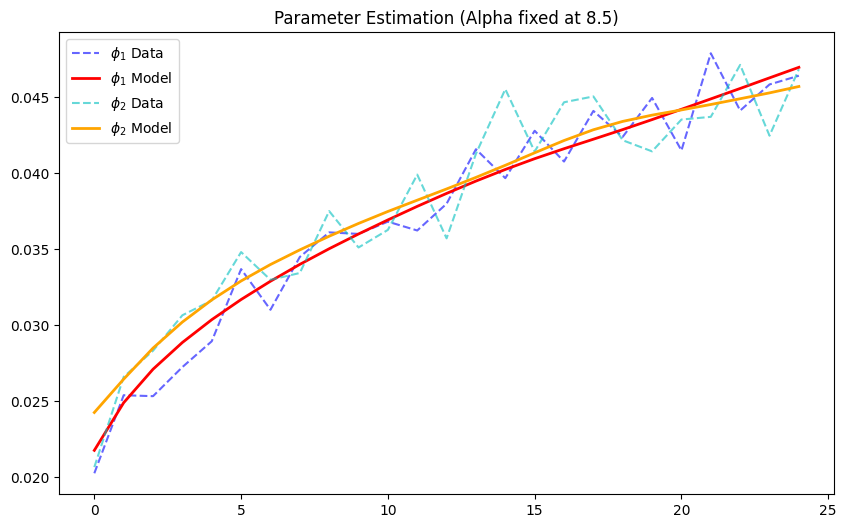

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import differential_evolution, root
import time
import sys

# 警告抑制
np.seterr(all='ignore')

class BiofilmSolver:
    def __init__(self):
        self.dt = 1e-4
        self.t_end = 0.025
        self.Kp1 = 1e-4
        self.Eta_vec = np.array([0.8, 1.0, 1.5, 2.0])
        self.Eta_phi_vec = self.Eta_vec.copy()

    def c(self, t):
        return 50.0 + 50.0 * np.sin(500.0 * t)

    def run(self, params, fixed_alpha):
        """
        4つの推定パラメータ + 1つの固定パラメータ(alpha)を受け取る
        params = [a12, a13, a23, b11]
        fixed_alpha = alpha (固定値)
        """
        p_a12 = params[0]
        p_a13 = params[1]
        p_a23 = params[2]
        p_b11 = params[3]

        # alpha は固定値を使う
        val_alpha = fixed_alpha

        # 行列 A
        A = np.array([
            [1.0,   p_a12, p_a13, 5.0],
            [p_a12, 1.0,   p_a23, 3.0],
            [p_a13, p_a23, 1.0,   2.0],
            [5.0,   3.0,   2.0,   1.0]
        ])

        # 感受性ベクトル b
        b_diag = np.array([p_b11, 0.3, 0.2, 0.1])

        # 初期条件
        phi_init = 0.02
        phi0_init = 1.0 - 4 * phi_init
        one = 0.999
        eps_init = 1e-3

        g_current = np.array([phi_init, phi_init, phi_init, phi_init, phi0_init,
                              one, one, one, one, eps_init])

        traj_phi1 = []
        traj_phi2 = []

        n_steps = 25
        step_interval = self.t_end / n_steps
        current_time = 0.0

        for i in range(n_steps):
            sub_steps = int(step_interval / self.dt)
            for _ in range(sub_steps):
                current_time += self.dt

                sol = root(
                    fun=self._residual_func,
                    x0=g_current,
                    args=(g_current, self.dt, current_time, A, b_diag, val_alpha),
                    method='lm',
                    tol=1e-6
                )

                if not sol.success:
                    sol = root(
                        fun=self._residual_func,
                        x0=g_current,
                        args=(g_current, self.dt, current_time, A, b_diag, val_alpha),
                        method='hybr',
                        tol=1e-6
                    )
                    if not sol.success: return None

                g_new = sol.x
                g_new[0:5] = np.clip(g_new[0:5], 1e-6, 1.0-1e-6)
                g_new[5:9] = np.clip(g_new[5:9], 0.1, 5.0)
                g_current = g_new.copy()

            traj_phi1.append(g_current[0])
            traj_phi2.append(g_current[1])

        return np.column_stack((traj_phi1, traj_phi2))

    def _residual_func(self, g_new, g_old, dt, t, A, b_diag, val_alpha):
        phi = g_new[0:4]
        phi0 = g_new[4]
        psi = g_new[5:9]
        gamma = g_new[9]

        phidot = (phi - g_old[0:4]) / dt
        phi0dot = (phi0 - g_old[4]) / dt
        psidot = (psi - g_old[5:9]) / dt

        Q = np.zeros(10)
        c_val = self.c(t)

        CapitalPhi = phi * psi
        Interaction_dot = A @ CapitalPhi

        denom_phi = np.sign((phi - 1.0)**3 * phi**3) * np.maximum(np.abs((phi - 1.0)**3 * phi**3), 1e-12)
        term1_phi = (self.Kp1 * (2. - 4.*phi)) / denom_phi
        term2_phi = (1./self.Eta_vec)*(gamma + (self.Eta_phi_vec + self.Eta_vec*psi**2)*phidot + self.Eta_vec*phi*psi*psidot)
        term3_phi = (c_val/self.Eta_vec)*psi*Interaction_dot
        Q[0:4] = term1_phi + term2_phi - term3_phi

        denom_phi0 = np.sign((phi0 - 1.0)**3 * phi0**3) * np.maximum(np.abs((phi0 - 1.0)**3 * phi0**3), 1e-12)
        Q[4] = gamma + (self.Kp1*(2.-4.*phi0))/denom_phi0 + phi0dot

        denom_psiA = np.sign((psi - 1.0)**2 * psi**3) * np.maximum(np.abs((psi - 1.0)**2 * psi**3), 1e-12)
        denom_psiB = np.sign((psi - 1.0)**3 * psi**2) * np.maximum(np.abs((psi - 1.0)**3 * psi**2), 1e-12)

        term1_psi = (-2.*self.Kp1)/denom_psiA - (2.*self.Kp1)/denom_psiB
        term2_psi = (b_diag * val_alpha / self.Eta_vec) * psi
        term3_psi = phi*psi*phidot + phi**2*psidot
        term4_psi = (c_val/self.Eta_vec)*phi*Interaction_dot
        Q[5:9] = term1_psi + term2_psi + term3_psi - term4_psi

        Q[9] = np.sum(phi) + phi0 - 1.0
        return Q

# =============================================================================
# Optimization with FIXED Alpha
# =============================================================================
def objective_function(params, solver, true_data, fixed_alpha):
    if np.any(params < 0): return 1e15
    # runにfixed_alphaを渡す
    sim_data = solver.run(params, fixed_alpha)
    if sim_data is None: return 1e15
    return np.mean((sim_data - true_data)**2)

if __name__ == "__main__":
    solver = BiofilmSolver()

    print("--- Biofilm Parameter Estimation (Fixing Alpha) ---")

    # 5つの真の値 [a12, a13, a23, b11, alpha]
    all_true_params = [3.0, 4.5, 2.0, 1.6, 8.5]

    # データ生成には全てのパラメータを使用
    # runメソッドは引数の数で挙動を変えないといけないため、
    # ここでは「データ生成用」に内部的に呼び出す
    print(f"Generating data for True Params: {all_true_params}")

    # 注意: ここではデータ生成のために一時的にコードロジックに合わせる
    # 4パラメータ + 固定1パラメータ の形式で渡す
    exp_data = solver.run(all_true_params[:4], all_true_params[4])

    if exp_data is None:
        print("Simulation failed.")
        sys.exit(1)

    noise = np.random.normal(0, 0.002, size=exp_data.shape)
    exp_data_noisy = exp_data + noise

    # --- 最適化設定 ---
    # Alphaを 8.5 に固定し、残りの4つだけを探す
    KNOWN_ALPHA = 8.5

    print(f"\nFixing Alpha = {KNOWN_ALPHA}")
    print("Starting optimization for [a12, a13, a23, b11]...")
    start_time = time.time()

    # 探索範囲 (4次元)
    bounds = [
        (0.0, 10.0), # a12
        (0.0, 10.0), # a13
        (0.0, 10.0), # a23
        (0.0, 5.0)   # b11
    ]

    result = differential_evolution(
        objective_function,
        bounds,
        args=(solver, exp_data_noisy, KNOWN_ALPHA), # 固定値を渡す
        strategy='best1bin',
        maxiter=30,     # 少し減らしても収束しやすくなっているはず
        popsize=15,
        tol=0.01,
        disp=True
    )

    print(f"\nDone in {time.time() - start_time:.2f}s")
    print("-" * 50)
    print(f"True (4 params):  {all_true_params[:4]}")
    print(f"Est  (4 params):  {np.round(result.x, 4)}")
    print("-" * 50)

    # プロット
    best_fit_data = solver.run(result.x, KNOWN_ALPHA)
    steps = np.arange(len(exp_data))

    plt.figure(figsize=(10, 6))
    plt.plot(steps, exp_data_noisy[:, 0], 'b--', alpha=0.6, label=r'$\phi_1$ Data')
    plt.plot(steps, best_fit_data[:, 0], 'r-', linewidth=2, label=r'$\phi_1$ Model')
    plt.plot(steps, exp_data_noisy[:, 1], 'c--', alpha=0.6, label=r'$\phi_2$ Data')
    plt.plot(steps, best_fit_data[:, 1], color='orange', linewidth=2, label=r'$\phi_2$ Model')

    plt.title(f"Parameter Estimation (Alpha fixed at {KNOWN_ALPHA})")
    plt.legend()
    plt.show()

--- Biofilm Parameter Estimation (Full Observation) ---
True Params: [3.0, 4.5, 2.0, 1.6, 8.5]

Starting optimization fitting ALL 4 species...
differential_evolution step 1: f(x)= 3.5684655966959163e-06
differential_evolution step 2: f(x)= 3.5684655966959163e-06
differential_evolution step 3: f(x)= 3.5684655966959163e-06
differential_evolution step 4: f(x)= 3.5684655966959163e-06
differential_evolution step 5: f(x)= 3.567154413112773e-06
differential_evolution step 6: f(x)= 3.567154413112773e-06
differential_evolution step 7: f(x)= 3.567154413112773e-06
Polishing solution with 'L-BFGS-B'

Done in 736.66s
--------------------------------------------------
True: [3.0, 4.5, 2.0, 1.6]
Est : [9.3201 0.6505 0.5477 1.6826]
--------------------------------------------------


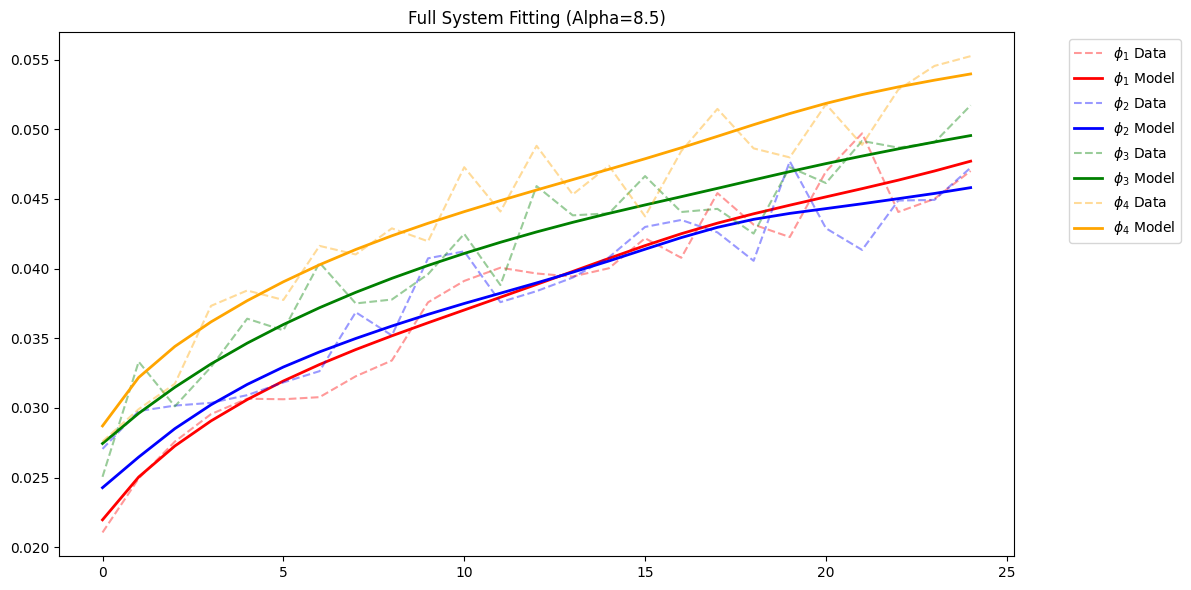

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import differential_evolution, root
import time
import sys

# 警告抑制
np.seterr(all='ignore')

class BiofilmSolver:
    def __init__(self):
        self.dt = 1e-4
        self.t_end = 0.025
        self.Kp1 = 1e-4
        self.Eta_vec = np.array([0.8, 1.0, 1.5, 2.0])
        self.Eta_phi_vec = self.Eta_vec.copy()

    def c(self, t):
        return 50.0 + 50.0 * np.sin(500.0 * t)

    def run(self, params, fixed_alpha):
        """
        全4種のデータを返すように変更
        """
        p_a12, p_a13, p_a23, p_b11 = params
        val_alpha = fixed_alpha

        # 行列 A
        A = np.array([
            [1.0,   p_a12, p_a13, 5.0],
            [p_a12, 1.0,   p_a23, 3.0],
            [p_a13, p_a23, 1.0,   2.0],
            [5.0,   3.0,   2.0,   1.0]
        ])

        b_diag = np.array([p_b11, 0.3, 0.2, 0.1])

        # 初期条件
        phi_init = 0.02
        phi0_init = 1.0 - 4 * phi_init
        one = 0.999
        eps_init = 1e-3

        g_current = np.array([phi_init, phi_init, phi_init, phi_init, phi0_init,
                              one, one, one, one, eps_init])

        # 全4種の軌跡を保存
        traj_phi = []

        n_steps = 25
        step_interval = self.t_end / n_steps
        current_time = 0.0

        for i in range(n_steps):
            sub_steps = int(step_interval / self.dt)
            for _ in range(sub_steps):
                current_time += self.dt

                sol = root(
                    fun=self._residual_func,
                    x0=g_current,
                    args=(g_current, self.dt, current_time, A, b_diag, val_alpha),
                    method='lm',
                    tol=1e-6
                )

                if not sol.success:
                    sol = root(
                        fun=self._residual_func,
                        x0=g_current,
                        args=(g_current, self.dt, current_time, A, b_diag, val_alpha),
                        method='hybr',
                        tol=1e-6
                    )
                    if not sol.success: return None

                g_new = sol.x
                g_new[0:5] = np.clip(g_new[0:5], 1e-6, 1.0-1e-6)
                g_new[5:9] = np.clip(g_new[5:9], 0.1, 5.0)
                g_current = g_new.copy()

            # [phi1, phi2, phi3, phi4] を保存
            traj_phi.append(g_current[0:4])

        return np.array(traj_phi)

    def _residual_func(self, g_new, g_old, dt, t, A, b_diag, val_alpha):
        phi = g_new[0:4]
        phi0 = g_new[4]
        psi = g_new[5:9]
        gamma = g_new[9]

        phidot = (phi - g_old[0:4]) / dt
        phi0dot = (phi0 - g_old[4]) / dt
        psidot = (psi - g_old[5:9]) / dt

        Q = np.zeros(10)
        c_val = self.c(t)

        CapitalPhi = phi * psi
        Interaction_dot = A @ CapitalPhi

        denom_phi = np.sign((phi - 1.0)**3 * phi**3) * np.maximum(np.abs((phi - 1.0)**3 * phi**3), 1e-12)
        term1_phi = (self.Kp1 * (2. - 4.*phi)) / denom_phi
        term2_phi = (1./self.Eta_vec)*(gamma + (self.Eta_phi_vec + self.Eta_vec*psi**2)*phidot + self.Eta_vec*phi*psi*psidot)
        term3_phi = (c_val/self.Eta_vec)*psi*Interaction_dot
        Q[0:4] = term1_phi + term2_phi - term3_phi

        denom_phi0 = np.sign((phi0 - 1.0)**3 * phi0**3) * np.maximum(np.abs((phi0 - 1.0)**3 * phi0**3), 1e-12)
        Q[4] = gamma + (self.Kp1*(2.-4.*phi0))/denom_phi0 + phi0dot

        denom_psiA = np.sign((psi - 1.0)**2 * psi**3) * np.maximum(np.abs((psi - 1.0)**2 * psi**3), 1e-12)
        denom_psiB = np.sign((psi - 1.0)**3 * psi**2) * np.maximum(np.abs((psi - 1.0)**3 * psi**2), 1e-12)

        term1_psi = (-2.*self.Kp1)/denom_psiA - (2.*self.Kp1)/denom_psiB
        term2_psi = (b_diag * val_alpha / self.Eta_vec) * psi
        term3_psi = phi*psi*phidot + phi**2*psidot
        term4_psi = (c_val/self.Eta_vec)*phi*Interaction_dot
        Q[5:9] = term1_psi + term2_psi + term3_psi - term4_psi

        Q[9] = np.sum(phi) + phi0 - 1.0
        return Q

# =============================================================================
# Optimization comparing ALL 4 Species
# =============================================================================
def objective_function(params, solver, true_data, fixed_alpha):
    if np.any(params < 0): return 1e15
    sim_data = solver.run(params, fixed_alpha)
    if sim_data is None: return 1e15

    # 全4種のデータでMSEを計算
    return np.mean((sim_data - true_data)**2)

if __name__ == "__main__":
    solver = BiofilmSolver()

    print("--- Biofilm Parameter Estimation (Full Observation) ---")

    # [a12, a13, a23, b11, alpha]
    all_true_params = [3.0, 4.5, 2.0, 1.6, 8.5]
    KNOWN_ALPHA = 8.5

    print(f"True Params: {all_true_params}")

    # 1. データ生成 (全種を含む)
    # runメソッドに 4 params + fixed alpha を渡す形式に注意
    # ここでは便宜的に「正解の4つ」を渡してデータを生成
    exp_data = solver.run(all_true_params[:4], KNOWN_ALPHA)

    if exp_data is None:
        print("Simulation failed.")
        sys.exit(1)

    noise = np.random.normal(0, 0.002, size=exp_data.shape)
    exp_data_noisy = exp_data + noise

    print("\nStarting optimization fitting ALL 4 species...")
    start_time = time.time()

    bounds = [
        (0.0, 10.0), # a12
        (0.0, 10.0), # a13
        (0.0, 10.0), # a23
        (0.0, 5.0)   # b11
    ]

    result = differential_evolution(
        objective_function,
        bounds,
        args=(solver, exp_data_noisy, KNOWN_ALPHA),
        strategy='best1bin',
        maxiter=30,
        popsize=15,
        tol=0.01,
        disp=True
    )

    print(f"\nDone in {time.time() - start_time:.2f}s")
    print("-" * 50)
    print(f"True: {all_true_params[:4]}")
    print(f"Est : {np.round(result.x, 4)}")
    print("-" * 50)

    # プロット
    best_fit_data = solver.run(result.x, KNOWN_ALPHA)
    steps = np.arange(len(exp_data))

    plt.figure(figsize=(12, 6))
    colors = ['r', 'b', 'g', 'orange']
    labels = [r'$\phi_1$', r'$\phi_2$', r'$\phi_3$', r'$\phi_4$']

    for i in range(4):
        plt.plot(steps, exp_data_noisy[:, i], color=colors[i], linestyle='--', alpha=0.4, label=f'{labels[i]} Data')
        plt.plot(steps, best_fit_data[:, i], color=colors[i], linestyle='-', linewidth=2, label=f'{labels[i]} Model')

    plt.title(f"Full System Fitting (Alpha={KNOWN_ALPHA})")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

In [ ]:
!pip install emcee corner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.4/47.4 kB 2.5 MB/s eta 0:00:00


Generating synthetic data...

--- Starting MCMC Sampling (12 walkers) ---
Note: This will verify the parameter ranges (uncertainty).


100%|██████████| 150/150 [35:19<00:00, 14.13s/it]



MCMC finished in 2157.68 seconds.

--- Final Results (Posterior Ranges) ---
a12: 5.759 (+2.341 / -2.236)
a13: 5.307 (+2.648 / -3.132)
a23: 0.997 (+1.097 / -0.831)
b11: 2.684 (+0.965 / -0.700)
----------------------------------------
True Values: [3.0, 4.5, 2.0, 1.6]


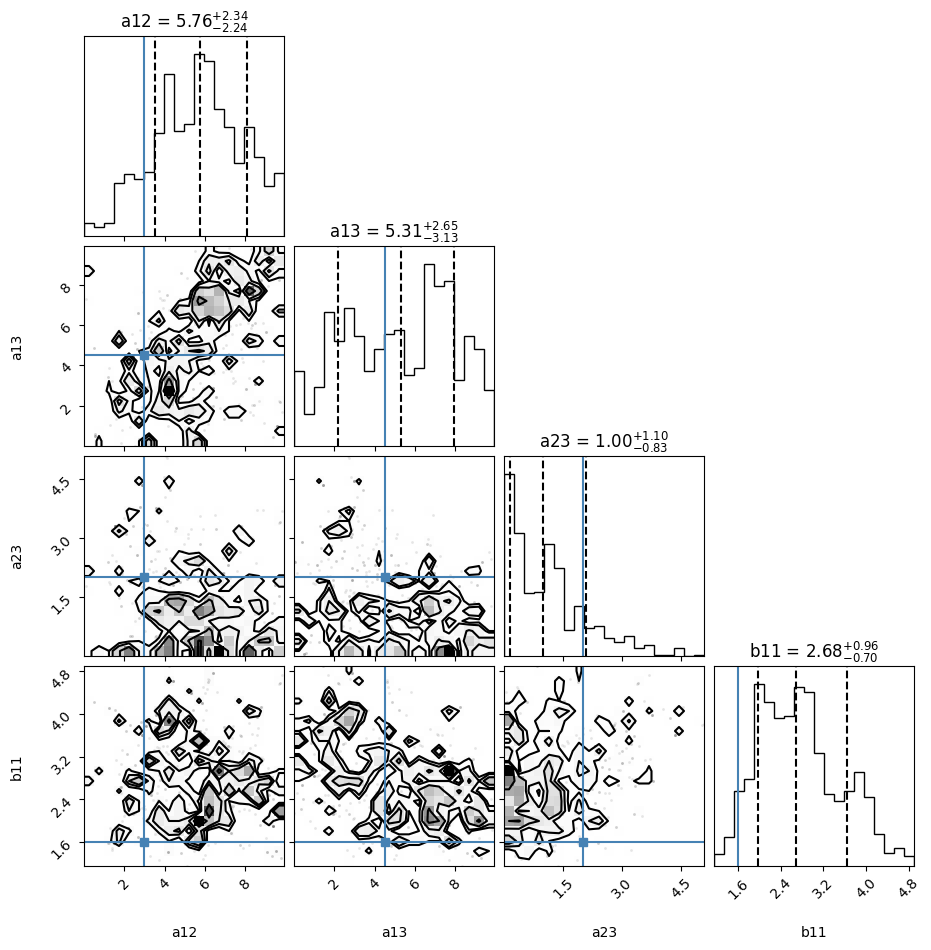


Plotting predictive uncertainty...


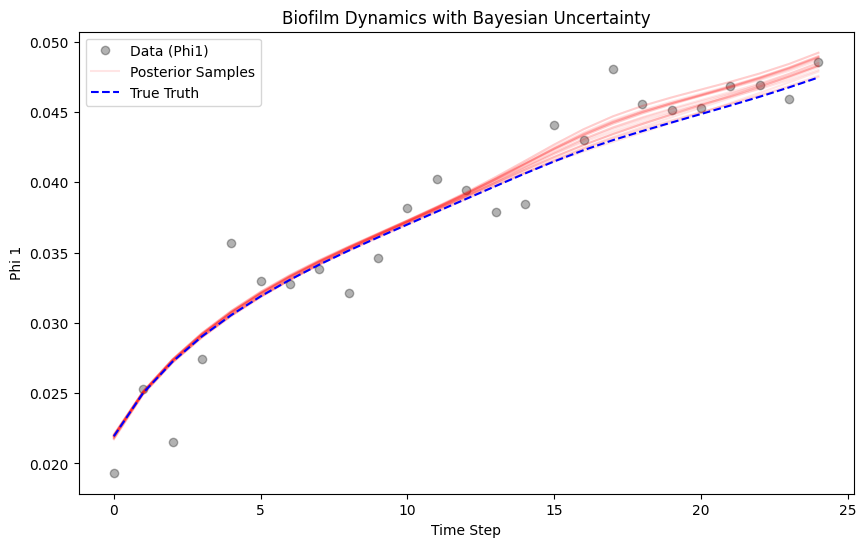

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import root
import time
import sys
import emcee # MCMCライブラリ
import corner # 結果可視化ライブラリ

# 警告抑制
np.seterr(all='ignore')

# =============================================================================
# 1. Solver Class (安定版)
# =============================================================================
class BiofilmSolver:
    def __init__(self):
        self.dt = 1e-4
        self.t_end = 0.025
        self.Kp1 = 1e-4
        self.Eta_vec = np.array([0.8, 1.0, 1.5, 2.0])
        self.Eta_phi_vec = self.Eta_vec.copy()

    def c(self, t):
        return 50.0 + 50.0 * np.sin(500.0 * t)

    def run(self, params, fixed_alpha):
        # params = [a12, a13, a23, b11]
        p_a12, p_a13, p_a23, p_b11 = params
        val_alpha = fixed_alpha

        A = np.array([
            [1.0,   p_a12, p_a13, 5.0],
            [p_a12, 1.0,   p_a23, 3.0],
            [p_a13, p_a23, 1.0,   2.0],
            [5.0,   3.0,   2.0,   1.0]
        ])
        b_diag = np.array([p_b11, 0.3, 0.2, 0.1])

        phi_init = 0.02
        phi0_init = 1.0 - 4 * phi_init
        one = 0.999
        eps_init = 1e-3
        g_current = np.array([phi_init, phi_init, phi_init, phi_init, phi0_init,
                              one, one, one, one, eps_init])

        traj_phi = []
        n_steps = 25
        step_interval = self.t_end / n_steps
        current_time = 0.0

        for i in range(n_steps):
            sub_steps = int(step_interval / self.dt)
            for _ in range(sub_steps):
                current_time += self.dt
                sol = root(self._residual_func, g_current, args=(g_current, self.dt, current_time, A, b_diag, val_alpha), method='lm', tol=1e-6)
                if not sol.success:
                    sol = root(self._residual_func, g_current, args=(g_current, self.dt, current_time, A, b_diag, val_alpha), method='hybr', tol=1e-6)
                    if not sol.success: return None
                g_new = sol.x
                g_new[0:5] = np.clip(g_new[0:5], 1e-6, 1.0-1e-6)
                g_new[5:9] = np.clip(g_new[5:9], 0.1, 5.0)
                g_current = g_new.copy()
            traj_phi.append(g_current[0:4]) # 全4種保存

        return np.array(traj_phi)

    def _residual_func(self, g_new, g_old, dt, t, A, b_diag, val_alpha):
        phi, phi0, psi, gamma = g_new[0:4], g_new[4], g_new[5:9], g_new[9]
        phidot = (phi - g_old[0:4]) / dt
        phi0dot = (phi0 - g_old[4]) / dt
        psidot = (psi - g_old[5:9]) / dt
        Q = np.zeros(10)
        c_val = self.c(t)
        CapitalPhi = phi * psi
        Interaction_dot = A @ CapitalPhi

        denom_phi = np.sign((phi-1)**3 * phi**3) * np.maximum(np.abs((phi-1)**3 * phi**3), 1e-12)
        Q[0:4] = (self.Kp1*(2.-4.*phi))/denom_phi + (1./self.Eta_vec)*(gamma+(self.Eta_phi_vec+self.Eta_vec*psi**2)*phidot+self.Eta_vec*phi*psi*psidot) - (c_val/self.Eta_vec)*psi*Interaction_dot

        denom_phi0 = np.sign((phi0-1)**3 * phi0**3) * np.maximum(np.abs((phi0-1)**3 * phi0**3), 1e-12)
        Q[4] = gamma + (self.Kp1*(2.-4.*phi0))/denom_phi0 + phi0dot

        denom_psiA = np.sign((psi-1)**2 * psi**3) * np.maximum(np.abs((psi-1)**2 * psi**3), 1e-12)
        denom_psiB = np.sign((psi-1)**3 * psi**2) * np.maximum(np.abs((psi-1)**3 * psi**2), 1e-12)
        Q[5:9] = (-2.*self.Kp1)/denom_psiA - (2.*self.Kp1)/denom_psiB + (b_diag*val_alpha/self.Eta_vec)*psi + phi*psi*phidot + phi**2*psidot - (c_val/self.Eta_vec)*phi*Interaction_dot

        Q[9] = np.sum(phi) + phi0 - 1.0
        return Q

# =============================================================================
# 2. Bayesian Inference Functions (MCMC)
# =============================================================================

def log_prior(theta):
    """事前分布: パラメータが存在しうる範囲"""
    a12, a13, a23, b11 = theta
    # 範囲チェック (0 ~ 10 の間にあるか？)
    if 0.0 < a12 < 10.0 and 0.0 < a13 < 10.0 and 0.0 < a23 < 10.0 and 0.0 < b11 < 5.0:
        return 0.0 # 範囲内なら確率一定 (対数0)
    return -np.inf # 範囲外なら確率ゼロ (対数-無限大)

def log_likelihood(theta, solver, y_data, yerr, fixed_alpha):
    """尤度関数: データとモデルがどれくらい合っているか"""
    # モデル計算
    y_model = solver.run(theta, fixed_alpha)
    if y_model is None:
        return -np.inf

    # ガウス分布を仮定した対数尤度 (-0.5 * chi^2)
    # y_data, y_model は shape (25, 4)
    sigma2 = yerr ** 2
    return -0.5 * np.sum((y_data - y_model) ** 2 / sigma2 + np.log(2 * np.pi * sigma2))

def log_probability(theta, solver, y_data, yerr, fixed_alpha):
    """事後分布 (Posterior) ∝ 事前分布(Prior) + 尤度(Likelihood)"""
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, solver, y_data, yerr, fixed_alpha)

# =============================================================================
# 3. Main Execution
# =============================================================================
if __name__ == "__main__":
    solver = BiofilmSolver()

    # --- 1. 真のデータ生成 (Alpha固定) ---
    TRUE_PARAMS = [3.0, 4.5, 2.0, 1.6] # a12, a13, a23, b11
    FIXED_ALPHA = 8.5

    print("Generating synthetic data...")
    y_true = solver.run(TRUE_PARAMS, FIXED_ALPHA)

    # ノイズ (標準偏差 sigma)
    sigma = 0.002
    y_data = y_true + np.random.normal(0, sigma, size=y_true.shape)

    # --- 2. MCMCの設定 ---
    ndim = 4      # 推定するパラメータ数
    nwalkers = 12 # ウォーカーの数 (パラメータ数の3倍以上推奨)

    # 初期位置 (真の値の周辺にばら撒く)
    # 実際は真の値は知らないので、ある程度ランダムに撒くのが普通ですが、
    # 時間短縮のため「正解に近い場所」からスタートさせます
    p0 = TRUE_PARAMS + 1e-2 * np.random.randn(nwalkers, ndim)

    print(f"\n--- Starting MCMC Sampling ({nwalkers} walkers) ---")
    print("Note: This will verify the parameter ranges (uncertainty).")

    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(solver, y_data, sigma, FIXED_ALPHA))

    # 実行ステップ数 (デモ用: 少ない回数)
    # 本番では n_steps = 1000 以上にしてください
    n_burn = 50   # バーンイン (最初の不安定な期間を捨てる)
    n_steps = 150 # サンプリング回数

    start = time.time()

    # MCMC実行 (プログレスバー表示)
    # multiprocessingを使えば高速化できますが、設定が複雑なためここでは直列実行
    sampler.run_mcmc(p0, n_steps, progress=True)

    end = time.time()
    print(f"\nMCMC finished in {end - start:.2f} seconds.")

    # --- 3. 結果の解析 ---
    # バーンイン期間を捨てて、チェーンを平坦化
    flat_samples = sampler.get_chain(discard=n_burn, thin=1, flat=True)

    print("\n--- Final Results (Posterior Ranges) ---")
    labels = ["a12", "a13", "a23", "b11"]

    for i in range(ndim):
        # 16%, 50%, 84% パーセンタイル (1シグマ範囲) を計算
        mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
        q = np.diff(mcmc)
        print(f"{labels[i]}: {mcmc[1]:.3f} (+{q[1]:.3f} / -{q[0]:.3f})")

    print("-" * 40)
    print(f"True Values: {TRUE_PARAMS}")

    # --- 4. 可視化 (Corner Plot) ---
    # パラメータ同士の相関や分布の広がりを図示
    fig = corner.corner(
        flat_samples,
        labels=labels,
        truths=TRUE_PARAMS,
        quantiles=[0.16, 0.5, 0.84],
        show_titles=True,
        title_kwargs={"fontsize": 12}
    )
    plt.show()

    # --- 5. 範囲付きの予測プロット ---
    # ランダムに選んだパラメータでグラフを複数描いて「予測の幅」を示す
    print("\nPlotting predictive uncertainty...")
    plt.figure(figsize=(10, 6))

    # データのプロット
    steps = np.arange(len(y_data))
    plt.plot(steps, y_data[:, 0], 'ko', alpha=0.3, label='Data (Phi1)')

    # サンプルからランダムに20個選んでプロット
    inds = np.random.randint(len(flat_samples), size=20)
    for ind in inds:
        sample = flat_samples[ind]
        y_model = solver.run(sample, FIXED_ALPHA)
        if ind == inds[0]:
            plt.plot(steps, y_model[:, 0], 'r-', alpha=0.1, label='Posterior Samples')
        else:
            plt.plot(steps, y_model[:, 0], 'r-', alpha=0.1)

    plt.plot(steps, y_true[:, 0], 'b--', label='True Truth')
    plt.title("Biofilm Dynamics with Bayesian Uncertainty")
    plt.xlabel("Time Step")
    plt.ylabel("Phi 1")
    plt.legend()
    plt.show()

--- Biofilm Validation: Simple Case (demo1 Page 1) ---
True Params: [1.0, 1.0, 1.0, 1.0]
Fixed Alpha: 10.0
Generating synthetic data...

Starting optimization...
differential_evolution step 1: f(x)= 3.713843984152583e-06
differential_evolution step 2: f(x)= 3.701390486177945e-06
differential_evolution step 3: f(x)= 3.69649449125495e-06
differential_evolution step 4: f(x)= 3.69649449125495e-06
differential_evolution step 5: f(x)= 3.69649449125495e-06
differential_evolution step 6: f(x)= 3.6925238524088403e-06
Polishing solution with 'L-BFGS-B'

Done in 586.34s
--------------------------------------------------
True Values:      [1.0, 1.0, 1.0, 1.0]
Estimated Values: [4.736  2.9724 0.2221 0.5358]
--------------------------------------------------


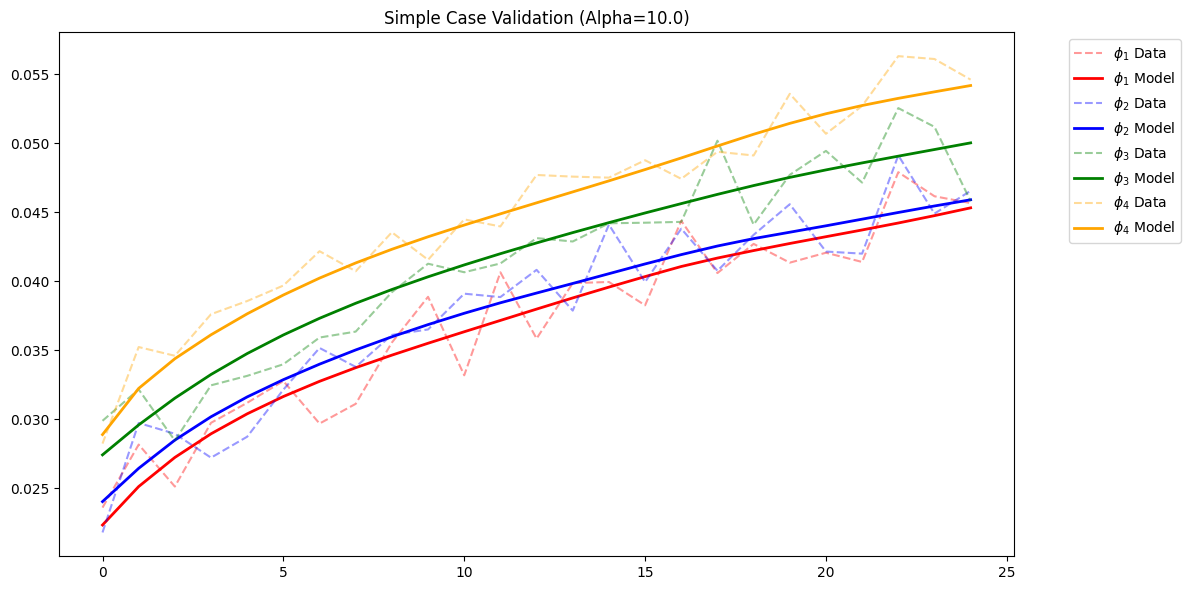

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import differential_evolution, root
import time
import sys

# 警告抑制
np.seterr(all='ignore')

class BiofilmSolver:
    def __init__(self):
        self.dt = 1e-4
        self.t_end = 0.025
        self.Kp1 = 1e-4
        self.Eta_vec = np.array([0.8, 1.0, 1.5, 2.0])
        self.Eta_phi_vec = self.Eta_vec.copy()

    def c(self, t):
        return 50.0 + 50.0 * np.sin(500.0 * t)

    def run(self, params, fixed_alpha):
        """
        全4種のデータを返す (Full Observation)
        params = [a12, a13, a23, b11]
        """
        p_a12, p_a13, p_a23, p_b11 = params
        val_alpha = fixed_alpha

        # 行列 A
        A = np.array([
            [1.0,   p_a12, p_a13, 5.0],
            [p_a12, 1.0,   p_a23, 3.0],
            [p_a13, p_a23, 1.0,   2.0],
            [5.0,   3.0,   2.0,   1.0]
        ])

        b_diag = np.array([p_b11, 0.3, 0.2, 0.1])

        # 初期条件
        phi_init = 0.02
        phi0_init = 1.0 - 4 * phi_init
        one = 0.999
        eps_init = 1e-3

        g_current = np.array([phi_init, phi_init, phi_init, phi_init, phi0_init,
                              one, one, one, one, eps_init])

        traj_phi = []
        n_steps = 25
        step_interval = self.t_end / n_steps
        current_time = 0.0

        for i in range(n_steps):
            sub_steps = int(step_interval / self.dt)
            for _ in range(sub_steps):
                current_time += self.dt
                # SciPy Root Solver
                sol = root(self._residual_func, g_current, args=(g_current, self.dt, current_time, A, b_diag, val_alpha), method='lm', tol=1e-6)
                if not sol.success:
                    sol = root(self._residual_func, g_current, args=(g_current, self.dt, current_time, A, b_diag, val_alpha), method='hybr', tol=1e-6)
                    if not sol.success: return None

                g_new = sol.x
                g_new[0:5] = np.clip(g_new[0:5], 1e-6, 1.0-1e-6)
                g_new[5:9] = np.clip(g_new[5:9], 0.1, 5.0)
                g_current = g_new.copy()

            traj_phi.append(g_current[0:4])

        return np.array(traj_phi)

    def _residual_func(self, g_new, g_old, dt, t, A, b_diag, val_alpha):
        phi = g_new[0:4]; phi0 = g_new[4]; psi = g_new[5:9]; gamma = g_new[9]
        phidot = (phi - g_old[0:4]) / dt
        phi0dot = (phi0 - g_old[4]) / dt
        psidot = (psi - g_old[5:9]) / dt
        Q = np.zeros(10)
        c_val = self.c(t)
        CapitalPhi = phi * psi
        Interaction_dot = A @ CapitalPhi

        denom_phi = np.sign((phi-1)**3 * phi**3) * np.maximum(np.abs((phi-1)**3 * phi**3), 1e-12)
        Q[0:4] = (self.Kp1*(2.-4.*phi))/denom_phi + (1./self.Eta_vec)*(gamma+(self.Eta_phi_vec+self.Eta_vec*psi**2)*phidot+self.Eta_vec*phi*psi*psidot) - (c_val/self.Eta_vec)*psi*Interaction_dot
        denom_phi0 = np.sign((phi0-1)**3 * phi0**3) * np.maximum(np.abs((phi0-1)**3 * phi0**3), 1e-12)
        Q[4] = gamma + (self.Kp1*(2.-4.*phi0))/denom_phi0 + phi0dot
        denom_psiA = np.sign((psi-1)**2 * psi**3) * np.maximum(np.abs((psi-1)**2 * psi**3), 1e-12)
        denom_psiB = np.sign((psi-1)**3 * psi**2) * np.maximum(np.abs((psi-1)**3 * psi**2), 1e-12)
        Q[5:9] = (-2.*self.Kp1)/denom_psiA - (2.*self.Kp1)/denom_psiB + (b_diag*val_alpha/self.Eta_vec)*psi + phi*psi*phidot + phi**2*psidot - (c_val/self.Eta_vec)*phi*Interaction_dot
        Q[9] = np.sum(phi) + phi0 - 1.0
        return Q

# =============================================================================
# Optimization Function
# =============================================================================
def objective_function(params, solver, true_data, fixed_alpha):
    if np.any(params < 0): return 1e15
    sim_data = solver.run(params, fixed_alpha)
    if sim_data is None: return 1e15
    return np.mean((sim_data - true_data)**2)

# =============================================================================
# Main Execution (Simple Case)
# =============================================================================
if __name__ == "__main__":
    solver = BiofilmSolver()

    print("--- Biofilm Validation: Simple Case (demo1 Page 1) ---")

    # 1. パラメータ設定 (Simple Case)
    # [a12, a13, a23, b11]
    SIMPLE_PARAMS = [1.0, 1.0, 1.0, 1.0]
    # Alpha
    SIMPLE_ALPHA = 10.0

    print(f"True Params: {SIMPLE_PARAMS}")
    print(f"Fixed Alpha: {SIMPLE_ALPHA}")

    # 2. データ生成
    print("Generating synthetic data...")
    exp_data = solver.run(SIMPLE_PARAMS, SIMPLE_ALPHA)

    if exp_data is None:
        print("Simulation failed.")
        sys.exit(1)

    # ノイズ付加
    noise = np.random.normal(0, 0.002, size=exp_data.shape)
    exp_data_noisy = exp_data + noise

    print("\nStarting optimization...")
    start_time = time.time()

    # 探索範囲
    bounds = [
        (0.0, 5.0), # a12
        (0.0, 5.0), # a13
        (0.0, 5.0), # a23
        (0.0, 5.0)  # b11
    ]

    # 最適化実行
    result = differential_evolution(
        objective_function,
        bounds,
        args=(solver, exp_data_noisy, SIMPLE_ALPHA),
        strategy='best1bin',
        maxiter=30,
        popsize=15,
        tol=0.01,
        disp=True
    )

    print(f"\nDone in {time.time() - start_time:.2f}s")
    print("-" * 50)
    print(f"True Values:      {SIMPLE_PARAMS}")
    print(f"Estimated Values: {np.round(result.x, 4)}")
    print("-" * 50)

    # プロット
    best_fit_data = solver.run(result.x, SIMPLE_ALPHA)
    steps = np.arange(len(exp_data))

    plt.figure(figsize=(12, 6))
    colors = ['r', 'b', 'g', 'orange']
    labels = [r'$\phi_1$', r'$\phi_2$', r'$\phi_3$', r'$\phi_4$']

    for i in range(4):
        plt.plot(steps, exp_data_noisy[:, i], color=colors[i], linestyle='--', alpha=0.4, label=f'{labels[i]} Data')
        plt.plot(steps, best_fit_data[:, i], color=colors[i], linestyle='-', linewidth=2, label=f'{labels[i]} Model')

    plt.title(f"Simple Case Validation (Alpha={SIMPLE_ALPHA})")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

--- 2-Species Model Parameter Estimation ---
True Params [a12, b11]: [3.0, 1.6]
Data generated. Starting optimization...
differential_evolution step 1: f(x)= 5.882242429374185e-06
differential_evolution step 2: f(x)= 5.878872058499954e-06
differential_evolution step 3: f(x)= 5.871703058452334e-06
differential_evolution step 4: f(x)= 5.862297113943901e-06
differential_evolution step 5: f(x)= 5.859109888237073e-06
Polishing solution with 'L-BFGS-B'

Done in 130.23s
----------------------------------------
True: [3.0, 1.6]
Est : [0.0281 1.6707]
----------------------------------------


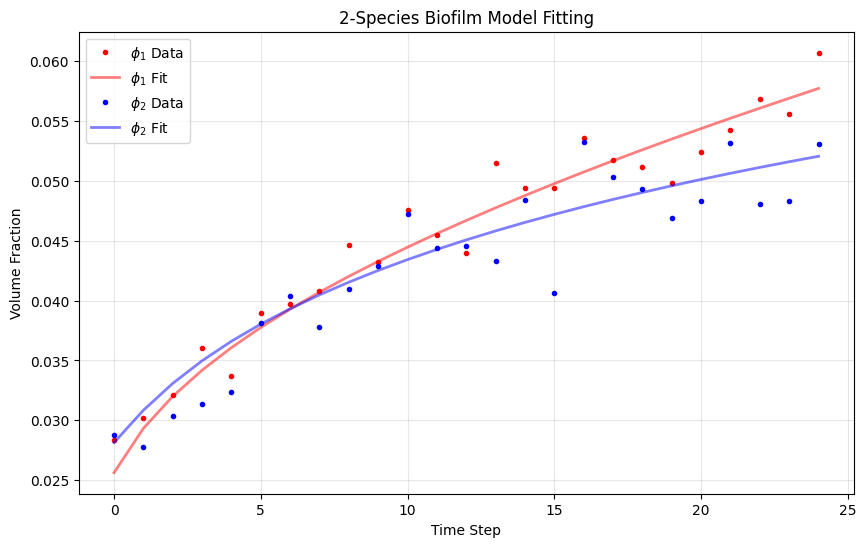

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import differential_evolution, root
import time
import sys

# 警告抑制
np.seterr(all='ignore')

class BiofilmSolverTwoSpecies:
    def __init__(self):
        # --- 基本設定 ---
        self.dt = 1e-4         # タイムステップ
        self.t_end = 0.025     # 終了時間
        self.Kp1 = 1e-4        # ペナルティ係数

        # 粘性 (2種モデル用: Species 1, Species 2)
        self.Eta_vec = np.array([0.8, 1.0])
        self.Eta_phi_vec = self.Eta_vec.copy()

    def c(self, t):
        # 栄養供給
        return 50.0 + 50.0 * np.sin(500.0 * t)

    def run(self, params, fixed_alpha):
        """
        2種モデルのシミュレーション
        params = [a12, b11]  (推定したいパラメータ)
        """
        p_a12, p_b11 = params
        val_alpha = fixed_alpha

        # --- 行列 A (2x2) ---
        # 対角成分(1.0)は固定、相互作用 a12 のみ変数
        A = np.array([
            [1.0,   p_a12],
            [p_a12, 1.0]
        ])

        # --- 感受性 b (2次元) ---
        # b11は推定、b22は固定(例: 0.3)
        b_diag = np.array([p_b11, 0.3])

        # --- 初期条件 (2種 + 空隙) ---
        # phi1, phi2 を初期配置
        phi_init = 0.02
        phi0_init = 1.0 - 2 * phi_init # phi1 + phi2 + phi0 = 1.0
        one = 0.999
        eps_init = 1e-3

        # 変数ベクトル g の構成 (サイズ6)
        # [phi1, phi2, phi0, psi1, psi2, gamma]
        g_current = np.array([phi_init, phi_init, phi0_init,
                              one, one, eps_init])

        traj_phi = []

        # --- シミュレーションループ ---
        n_steps = 25
        step_interval = self.t_end / n_steps
        current_time = 0.0

        for i in range(n_steps):
            sub_steps = int(step_interval / self.dt)
            for _ in range(sub_steps):
                current_time += self.dt

                # SciPy Solver
                sol = root(
                    fun=self._residual_func,
                    x0=g_current,
                    args=(g_current, self.dt, current_time, A, b_diag, val_alpha),
                    method='lm',
                    tol=1e-6
                )

                if not sol.success:
                    # Retry with hybrid
                    sol = root(
                        fun=self._residual_func,
                        x0=g_current,
                        args=(g_current, self.dt, current_time, A, b_diag, val_alpha),
                        method='hybr',
                        tol=1e-6
                    )
                    if not sol.success: return None

                g_new = sol.x
                # クリッピング (Phi1, Phi2, Phi0)
                g_new[0:3] = np.clip(g_new[0:3], 1e-6, 1.0-1e-6)
                # Psi1, Psi2
                g_new[3:5] = np.clip(g_new[3:5], 0.1, 5.0)

                g_current = g_new.copy()

            # [phi1, phi2] を保存 (phi0は保存しない)
            traj_phi.append(g_current[0:2])

        return np.array(traj_phi)

    def _residual_func(self, g_new, g_old, dt, t, A, b_diag, val_alpha):
        # 変数展開 (2種モデル用)
        # phi: 0,1 (2種)
        # phi0: 2
        # psi: 3,4 (2種)
        # gamma: 5
        phi = g_new[0:2]
        phi0 = g_new[2]
        psi = g_new[3:5]
        gamma = g_new[5]

        # 前ステップの値
        phi_old = g_old[0:2]
        phi0_old = g_old[2]
        psi_old = g_old[3:5]

        # 時間微分
        phidot = (phi - phi_old) / dt
        phi0dot = (phi0 - phi0_old) / dt
        psidot = (psi - psi_old) / dt

        Q = np.zeros(6)
        c_val = self.c(t)

        CapitalPhi = phi * psi
        Interaction_dot = A @ CapitalPhi

        # --- Phi Equations (2本) ---
        # (phi-1)^3 * phi^3 の項
        denom_phi = np.sign((phi - 1.0)**3 * phi**3) * np.maximum(np.abs((phi - 1.0)**3 * phi**3), 1e-12)

        term1_phi = (self.Kp1 * (2. - 4.*phi)) / denom_phi
        term2_phi = (1./self.Eta_vec)*(gamma + (self.Eta_phi_vec + self.Eta_vec*psi**2)*phidot + self.Eta_vec*phi*psi*psidot)
        term3_phi = (c_val/self.Eta_vec)*psi*Interaction_dot

        Q[0:2] = term1_phi + term2_phi - term3_phi

        # --- Phi0 Equation (1本) ---
        denom_phi0 = np.sign((phi0 - 1.0)**3 * phi0**3) * np.maximum(np.abs((phi0 - 1.0)**3 * phi0**3), 1e-12)
        Q[2] = gamma + (self.Kp1*(2.-4.*phi0))/denom_phi0 + phi0dot

        # --- Psi Equations (2本) ---
        denom_psiA = np.sign((psi - 1.0)**2 * psi**3) * np.maximum(np.abs((psi - 1.0)**2 * psi**3), 1e-12)
        denom_psiB = np.sign((psi - 1.0)**3 * psi**2) * np.maximum(np.abs((psi - 1.0)**3 * psi**2), 1e-12)

        term1_psi = (-2.*self.Kp1)/denom_psiA - (2.*self.Kp1)/denom_psiB
        term2_psi = (b_diag * val_alpha / self.Eta_vec) * psi
        term3_psi = phi*psi*phidot + phi**2*psidot
        term4_psi = (c_val/self.Eta_vec)*phi*Interaction_dot

        Q[3:5] = term1_psi + term2_psi + term3_psi - term4_psi

        # --- Constraint Equation (1本) ---
        # phi1 + phi2 + phi0 - 1 = 0
        Q[5] = np.sum(phi) + phi0 - 1.0

        return Q

# =============================================================================
# Optimization Logic
# =============================================================================
def objective_function(params, solver, true_data, fixed_alpha):
    if np.any(params < 0): return 1e15
    sim_data = solver.run(params, fixed_alpha)
    if sim_data is None: return 1e15
    return np.mean((sim_data - true_data)**2)

if __name__ == "__main__":
    solver = BiofilmSolverTwoSpecies()

    print("--- 2-Species Model Parameter Estimation ---")

    # 真のパラメータ (2種モデル用)
    # a12 = 3.0 (相互作用)
    # b11 = 1.6 (感受性)
    TRUE_PARAMS_2S = [3.0, 1.6]
    FIXED_ALPHA = 8.5

    print(f"True Params [a12, b11]: {TRUE_PARAMS_2S}")

    # 1. データ生成
    exp_data = solver.run(TRUE_PARAMS_2S, FIXED_ALPHA)
    if exp_data is None:
        print("Simulation failed.")
        sys.exit(1)

    # ノイズ付加
    noise = np.random.normal(0, 0.002, size=exp_data.shape)
    exp_data_noisy = exp_data + noise

    print("Data generated. Starting optimization...")
    start_time = time.time()

    # 2. 最適化 (2次元探索なので非常に高速かつ正確です)
    bounds = [
        (0.0, 10.0), # a12
        (0.0, 5.0)   # b11
    ]

    result = differential_evolution(
        objective_function,
        bounds,
        args=(solver, exp_data_noisy, FIXED_ALPHA),
        strategy='best1bin',
        maxiter=30,
        popsize=10,
        tol=0.01,
        disp=True
    )

    print(f"\nDone in {time.time() - start_time:.2f}s")
    print("-" * 40)
    print(f"True: {TRUE_PARAMS_2S}")
    print(f"Est : {np.round(result.x, 4)}")
    print("-" * 40)

    # プロット
    best_fit = solver.run(result.x, FIXED_ALPHA)
    steps = np.arange(len(exp_data))

    plt.figure(figsize=(10, 6))
    plt.plot(steps, exp_data_noisy[:, 0], 'r.', label=r'$\phi_1$ Data')
    plt.plot(steps, best_fit[:, 0], 'r-', alpha=0.5, linewidth=2, label=r'$\phi_1$ Fit')

    plt.plot(steps, exp_data_noisy[:, 1], 'b.', label=r'$\phi_2$ Data')
    plt.plot(steps, best_fit[:, 1], 'b-', alpha=0.5, linewidth=2, label=r'$\phi_2$ Fit')

    plt.title("2-Species Biofilm Model Fitting")
    plt.xlabel("Time Step")
    plt.ylabel("Volume Fraction")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

--- 2-Species Model Validation (demo1 Page 1) ---
True Params: [1.0, 1.0, 1.0, 1.0, 10.0]
Generating synthetic data...
Starting optimization (This may take 10-20 mins)...
differential_evolution step 1: f(x)= 3.313399210350613e-06
differential_evolution step 2: f(x)= 3.3057935211783024e-06
differential_evolution step 3: f(x)= 3.3057935211783024e-06
differential_evolution step 4: f(x)= 3.3057935211783024e-06
differential_evolution step 5: f(x)= 3.3057935211783024e-06
differential_evolution step 6: f(x)= 3.3057935211783024e-06
differential_evolution step 7: f(x)= 3.3057935211783024e-06
differential_evolution step 8: f(x)= 3.3057935211783024e-06
differential_evolution step 9: f(x)= 3.3030124874468608e-06
Polishing solution with 'L-BFGS-B'

Optimization done in 593.36s
--------------------------------------------------
True Params:      [1.0, 1.0, 1.0, 1.0, 10.0]
Estimated Params: [4.9582 3.2608 1.0954 0.9172 6.6228]
--------------------------------------------------


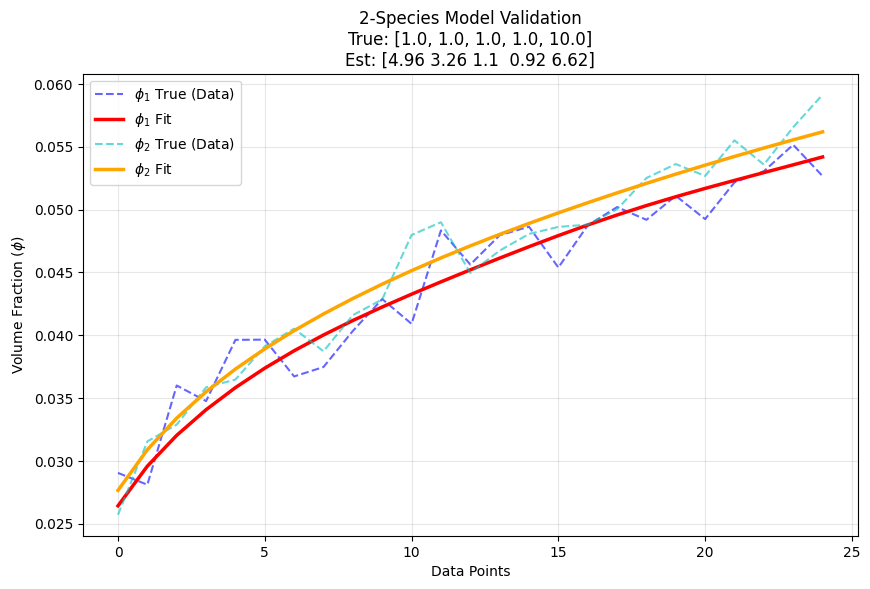

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import differential_evolution, root
import time
import sys

# 警告抑制
np.seterr(all='ignore')

class BiofilmSolverTwoSpecies:
    def __init__(self):
        # --- 基本設定 ---
        self.dt = 1e-4         # タイムステップ
        self.t_end = 0.025     # demo1の25ステップに合わせる
        self.Kp1 = 1e-4        # ペナルティ係数

        # 粘性 (2種モデル用: Species 1, Species 2)
        self.Eta_vec = np.array([0.8, 1.0])
        self.Eta_phi_vec = self.Eta_vec.copy()

    def c(self, t):
        # 栄養供給 (Nutrient)
        return 50.0 + 50.0 * np.sin(500.0 * t)

    def run(self, params):
        """
        2種モデル・5パラメータシミュレーション
        params = [a11, a12, a22, b11, alpha]
        """
        p_a11 = params[0]
        p_a12 = params[1]
        p_a22 = params[2]
        p_b11 = params[3]
        p_alpha = params[4]

        # --- 行列 A (2x2) ---
        # 対角成分と非対角成分をパラメータで埋める
        A = np.array([
            [p_a11, p_a12],
            [p_a12, p_a22]
        ])

        # --- 感受性 b (2次元) ---
        # b11は推定、b22は固定(このケースでは1.0としておく)
        b_diag = np.array([p_b11, 1.0])

        # --- 初期条件 (2種 + 空隙) ---
        phi_init = 0.02
        phi0_init = 1.0 - 2 * phi_init
        one = 0.999
        eps_init = 1e-3

        # [phi1, phi2, phi0, psi1, psi2, gamma] (サイズ6)
        g_current = np.array([phi_init, phi_init, phi0_init,
                              one, one, eps_init])

        traj_phi = []

        n_steps = 25
        step_interval = self.t_end / n_steps
        current_time = 0.0

        for i in range(n_steps):
            sub_steps = int(step_interval / self.dt)
            for _ in range(sub_steps):
                current_time += self.dt

                # SciPy Root Solver
                sol = root(
                    fun=self._residual_func,
                    x0=g_current,
                    args=(g_current, self.dt, current_time, A, b_diag, p_alpha),
                    method='lm',
                    tol=1e-6
                )

                if not sol.success:
                    sol = root(
                        fun=self._residual_func,
                        x0=g_current,
                        args=(g_current, self.dt, current_time, A, b_diag, p_alpha),
                        method='hybr',
                        tol=1e-6
                    )
                    if not sol.success: return None

                g_new = sol.x
                # クリッピング
                g_new[0:3] = np.clip(g_new[0:3], 1e-6, 1.0-1e-6) # Phi
                g_new[3:5] = np.clip(g_new[3:5], 0.1, 5.0)       # Psi

                g_current = g_new.copy()

            # [phi1, phi2] を保存
            traj_phi.append(g_current[0:2])

        return np.array(traj_phi)

    def _residual_func(self, g_new, g_old, dt, t, A, b_diag, val_alpha):
        phi = g_new[0:2]
        phi0 = g_new[2]
        psi = g_new[3:5]
        gamma = g_new[5]

        phi_old = g_old[0:2]
        phi0_old = g_old[2]
        psi_old = g_old[3:5]

        phidot = (phi - phi_old) / dt
        phi0dot = (phi0 - phi0_old) / dt
        psidot = (psi - psi_old) / dt

        Q = np.zeros(6)
        c_val = self.c(t)

        CapitalPhi = phi * psi
        Interaction_dot = A @ CapitalPhi

        # --- Equations ---
        denom_phi = np.sign((phi - 1.0)**3 * phi**3) * np.maximum(np.abs((phi - 1.0)**3 * phi**3), 1e-12)

        term1_phi = (self.Kp1 * (2. - 4.*phi)) / denom_phi
        term2_phi = (1./self.Eta_vec)*(gamma + (self.Eta_phi_vec + self.Eta_vec*psi**2)*phidot + self.Eta_vec*phi*psi*psidot)
        term3_phi = (c_val/self.Eta_vec)*psi*Interaction_dot

        Q[0:2] = term1_phi + term2_phi - term3_phi

        denom_phi0 = np.sign((phi0 - 1.0)**3 * phi0**3) * np.maximum(np.abs((phi0 - 1.0)**3 * phi0**3), 1e-12)
        Q[2] = gamma + (self.Kp1*(2.-4.*phi0))/denom_phi0 + phi0dot

        denom_psiA = np.sign((psi - 1.0)**2 * psi**3) * np.maximum(np.abs((psi - 1.0)**2 * psi**3), 1e-12)
        denom_psiB = np.sign((psi - 1.0)**3 * psi**2) * np.maximum(np.abs((psi - 1.0)**3 * psi**2), 1e-12)

        term1_psi = (-2.*self.Kp1)/denom_psiA - (2.*self.Kp1)/denom_psiB
        term2_psi = (b_diag * val_alpha / self.Eta_vec) * psi
        term3_psi = phi*psi*phidot + phi**2*psidot
        term4_psi = (c_val/self.Eta_vec)*phi*Interaction_dot

        Q[3:5] = term1_psi + term2_psi + term3_psi - term4_psi
        Q[5] = np.sum(phi) + phi0 - 1.0

        return Q

# =============================================================================
# Main Execution
# =============================================================================
def objective_function(params, solver, true_data):
    if np.any(params < 0): return 1e15
    sim_data = solver.run(params)
    if sim_data is None: return 1e15
    return np.mean((sim_data - true_data)**2)

if __name__ == "__main__":
    solver = BiofilmSolverTwoSpecies()

    print("--- 2-Species Model Validation (demo1 Page 1) ---")

    # 5つのパラメータ [a11, a12, a22, b11, alpha]
    # demo1 Page 1: 1, 1, 1, 1, 10
    TRUE_PARAMS = [1.0, 1.0, 1.0, 1.0, 10.0]

    print(f"True Params: {TRUE_PARAMS}")
    print("Generating synthetic data...")

    exp_data = solver.run(TRUE_PARAMS)
    if exp_data is None:
        print("[CRITICAL] Simulation failed.")
        sys.exit(1)

    noise = np.random.normal(0, 0.002, size=exp_data.shape)
    exp_data_noisy = exp_data + noise

    print("Starting optimization (This may take 10-20 mins)...")
    start_time = time.time()

    # 探索範囲
    bounds = [
        (0.0, 5.0),  # a11
        (0.0, 5.0),  # a12
        (0.0, 5.0),  # a22
        (0.0, 5.0),  # b11
        (5.0, 15.0)  # alpha (少し範囲を絞る)
    ]

    # Differential Evolution
    result = differential_evolution(
        objective_function,
        bounds,
        args=(solver, exp_data_noisy),
        strategy='best1bin',
        maxiter=30,     # 本番用設定
        popsize=15,     # 本番用設定
        tol=0.01,
        disp=True
    )

    print(f"\nOptimization done in {time.time() - start_time:.2f}s")
    print("-" * 50)
    print(f"True Params:      {TRUE_PARAMS}")
    print(f"Estimated Params: {np.round(result.x, 4)}")
    print("-" * 50)

    # プロット
    best_fit = solver.run(result.x)
    steps = np.arange(len(exp_data))

    plt.figure(figsize=(10, 6))

    # Species 1
    plt.plot(steps, exp_data_noisy[:, 0], 'b--', linewidth=1.5, alpha=0.6, label=r'$\phi_1$ True (Data)')
    plt.plot(steps, best_fit[:, 0], 'r-', linewidth=2.5, label=r'$\phi_1$ Fit')

    # Species 2
    plt.plot(steps, exp_data_noisy[:, 1], 'c--', linewidth=1.5, alpha=0.6, label=r'$\phi_2$ True (Data)')
    plt.plot(steps, best_fit[:, 1], color='orange', linestyle='-', linewidth=2.5, label=r'$\phi_2$ Fit')

    plt.title(f"2-Species Model Validation\nTrue: {TRUE_PARAMS}\nEst: {np.round(result.x, 2)}")
    plt.xlabel("Data Points")
    plt.ylabel(r"Volume Fraction ($\phi$)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

--- 2-Species Model Validation (demo1 Page 1) ---
True Params: [1.0, 1.0, 1.0, 1.0, 10.0]
Generating synthetic data...
Starting optimization (This may take 10-20 mins)...
differential_evolution step 1: f(x)= 4.591960657979188e-06
differential_evolution step 2: f(x)= 4.560514673290705e-06
differential_evolution step 3: f(x)= 4.559248064660677e-06
differential_evolution step 4: f(x)= 4.559248064660677e-06
differential_evolution step 5: f(x)= 4.551885991989929e-06
differential_evolution step 6: f(x)= 4.547823055703694e-06
differential_evolution step 7: f(x)= 4.5439987236773305e-06
differential_evolution step 8: f(x)= 4.540961433045406e-06
Polishing solution with 'L-BFGS-B'

Optimization done in 603.42s
--------------------------------------------------
True Params:      [1.0, 1.0, 1.0, 1.0, 10.0]
Estimated Params: [ 4.6705  1.7711  0.8546  0.997  10.2823]
--------------------------------------------------


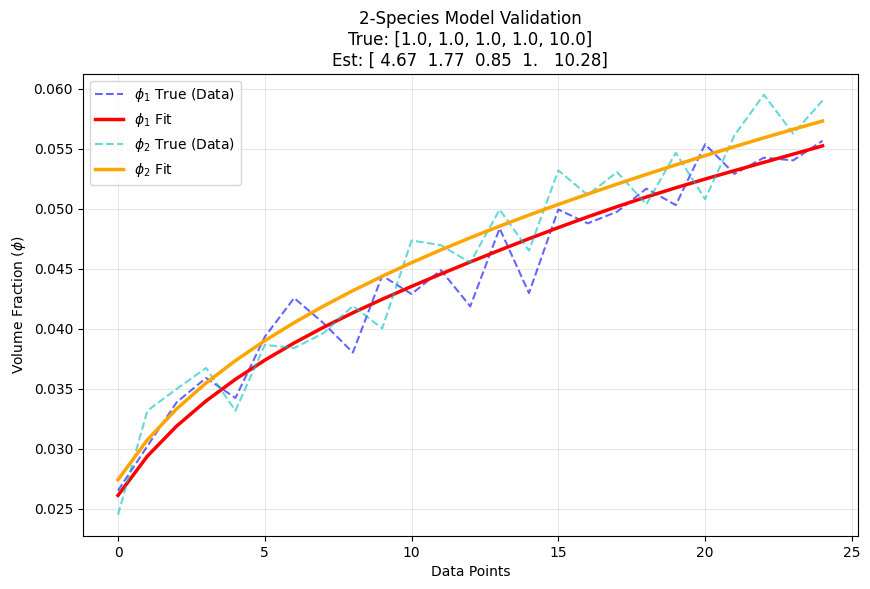

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import differential_evolution, root
import time
import sys

# 警告抑制
np.seterr(all='ignore')

class BiofilmSolverTwoSpecies:
    def __init__(self):
        # --- 基本設定 ---
        self.dt = 1e-4         # タイムステップ
        self.t_end = 0.025     # demo1の25ステップに合わせる
        self.Kp1 = 1e-4        # ペナルティ係数

        # 粘性 (2種モデル用: Species 1, Species 2)
        self.Eta_vec = np.array([0.8, 1.0])
        self.Eta_phi_vec = self.Eta_vec.copy()

    def c(self, t):
        # 栄養供給 (Nutrient)
        return 50.0 + 50.0 * np.sin(500.0 * t)

    def run(self, params):
        """
        2種モデル・5パラメータシミュレーション
        params = [a11, a12, a22, b11, alpha]
        """
        p_a11 = params[0]
        p_a12 = params[1]
        p_a22 = params[2]
        p_b11 = params[3]
        p_alpha = params[4]

        # --- 行列 A (2x2) ---
        # 対角成分と非対角成分をパラメータで埋める
        A = np.array([
            [p_a11, p_a12],
            [p_a12, p_a22]
        ])

        # --- 感受性 b (2次元) ---
        # b11は推定、b22は固定(このケースでは1.0としておく)
        b_diag = np.array([p_b11, 1.0])

        # --- 初期条件 (2種 + 空隙) ---
        phi_init = 0.02
        phi0_init = 1.0 - 2 * phi_init
        one = 0.999
        eps_init = 1e-3

        # [phi1, phi2, phi0, psi1, psi2, gamma] (サイズ6)
        g_current = np.array([phi_init, phi_init, phi0_init,
                              one, one, eps_init])

        traj_phi = []

        n_steps = 25
        step_interval = self.t_end / n_steps
        current_time = 0.0

        for i in range(n_steps):
            sub_steps = int(step_interval / self.dt)
            for _ in range(sub_steps):
                current_time += self.dt

                # SciPy Root Solver
                sol = root(
                    fun=self._residual_func,
                    x0=g_current,
                    args=(g_current, self.dt, current_time, A, b_diag, p_alpha),
                    method='lm',
                    tol=1e-6
                )

                if not sol.success:
                    sol = root(
                        fun=self._residual_func,
                        x0=g_current,
                        args=(g_current, self.dt, current_time, A, b_diag, p_alpha),
                        method='hybr',
                        tol=1e-6
                    )
                    if not sol.success: return None

                g_new = sol.x
                # クリッピング
                g_new[0:3] = np.clip(g_new[0:3], 1e-6, 1.0-1e-6) # Phi
                g_new[3:5] = np.clip(g_new[3:5], 0.1, 5.0)       # Psi

                g_current = g_new.copy()

            # [phi1, phi2] を保存
            traj_phi.append(g_current[0:2])

        return np.array(traj_phi)

    def _residual_func(self, g_new, g_old, dt, t, A, b_diag, val_alpha):
        phi = g_new[0:2]
        phi0 = g_new[2]
        psi = g_new[3:5]
        gamma = g_new[5]

        phi_old = g_old[0:2]
        phi0_old = g_old[2]
        psi_old = g_old[3:5]

        phidot = (phi - phi_old) / dt
        phi0dot = (phi0 - phi0_old) / dt
        psidot = (psi - psi_old) / dt

        Q = np.zeros(6)
        c_val = self.c(t)

        CapitalPhi = phi * psi
        Interaction_dot = A @ CapitalPhi

        # --- Equations ---
        denom_phi = np.sign((phi - 1.0)**3 * phi**3) * np.maximum(np.abs((phi - 1.0)**3 * phi**3), 1e-12)

        term1_phi = (self.Kp1 * (2. - 4.*phi)) / denom_phi
        term2_phi = (1./self.Eta_vec)*(gamma + (self.Eta_phi_vec + self.Eta_vec*psi**2)*phidot + self.Eta_vec*phi*psi*psidot)
        term3_phi = (c_val/self.Eta_vec)*psi*Interaction_dot

        Q[0:2] = term1_phi + term2_phi - term3_phi

        denom_phi0 = np.sign((phi0 - 1.0)**3 * phi0**3) * np.maximum(np.abs((phi0 - 1.0)**3 * phi0**3), 1e-12)
        Q[2] = gamma + (self.Kp1*(2.-4.*phi0))/denom_phi0 + phi0dot

        denom_psiA = np.sign((psi - 1.0)**2 * psi**3) * np.maximum(np.abs((psi - 1.0)**2 * psi**3), 1e-12)
        denom_psiB = np.sign((psi - 1.0)**3 * psi**2) * np.maximum(np.abs((psi - 1.0)**3 * psi**2), 1e-12)

        term1_psi = (-2.*self.Kp1)/denom_psiA - (2.*self.Kp1)/denom_psiB
        term2_psi = (b_diag * val_alpha / self.Eta_vec) * psi
        term3_psi = phi*psi*phidot + phi**2*psidot
        term4_psi = (c_val/self.Eta_vec)*phi*Interaction_dot

        Q[3:5] = term1_psi + term2_psi + term3_psi - term4_psi
        Q[5] = np.sum(phi) + phi0 - 1.0

        return Q

# =============================================================================
# Main Execution
# =============================================================================
def objective_function(params, solver, true_data):
    if np.any(params < 0): return 1e15
    sim_data = solver.run(params)
    if sim_data is None: return 1e15
    return np.mean((sim_data - true_data)**2)

if __name__ == "__main__":
    solver = BiofilmSolverTwoSpecies()

    print("--- 2-Species Model Validation (demo1 Page 1) ---")

    # 5つのパラメータ [a11, a12, a22, b11, alpha]
    # demo1 Page 1: 1, 1, 1, 1, 10
    TRUE_PARAMS = [1.0, 1.0, 1.0, 1.0, 10.0]

    print(f"True Params: {TRUE_PARAMS}")
    print("Generating synthetic data...")

    exp_data = solver.run(TRUE_PARAMS)
    if exp_data is None:
        print("[CRITICAL] Simulation failed.")
        sys.exit(1)

    noise = np.random.normal(0, 0.002, size=exp_data.shape)
    exp_data_noisy = exp_data + noise

    print("Starting optimization (This may take 10-20 mins)...")
    start_time = time.time()

    # 探索範囲
    bounds = [
        (0.0, 5.0),  # a11
        (0.0, 5.0),  # a12
        (0.0, 5.0),  # a22
        (0.0, 5.0),  # b11
        (5.0, 15.0)  # alpha (少し範囲を絞る)
    ]

    # Differential Evolution
    result = differential_evolution(
        objective_function,
        bounds,
        args=(solver, exp_data_noisy),
        strategy='best1bin',
        maxiter=30,     # 本番用設定
        popsize=15,     # 本番用設定
        tol=0.01,
        disp=True
    )

    print(f"\nOptimization done in {time.time() - start_time:.2f}s")
    print("-" * 50)
    print(f"True Params:      {TRUE_PARAMS}")
    print(f"Estimated Params: {np.round(result.x, 4)}")
    print("-" * 50)

    # プロット
    best_fit = solver.run(result.x)
    steps = np.arange(len(exp_data))

    plt.figure(figsize=(10, 6))

    # Species 1
    plt.plot(steps, exp_data_noisy[:, 0], 'b--', linewidth=1.5, alpha=0.6, label=r'$\phi_1$ True (Data)')
    plt.plot(steps, best_fit[:, 0], 'r-', linewidth=2.5, label=r'$\phi_1$ Fit')

    # Species 2
    plt.plot(steps, exp_data_noisy[:, 1], 'c--', linewidth=1.5, alpha=0.6, label=r'$\phi_2$ True (Data)')
    plt.plot(steps, best_fit[:, 1], color='orange', linestyle='-', linewidth=2.5, label=r'$\phi_2$ Fit')

    plt.title(f"2-Species Model Validation\nTrue: {TRUE_PARAMS}\nEst: {np.round(result.x, 2)}")
    plt.xlabel("Data Points")
    plt.ylabel(r"Volume Fraction ($\phi$)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

--- Recreating demo1.pdf Page 1 Graph ---
Running True Simulation: [1.0, 1.0, 1.0, 1.0, 10.0]
Running New (Est) Simulation: [1.04372, 1.1313, 1.26415, 0.339588, 10.7666]


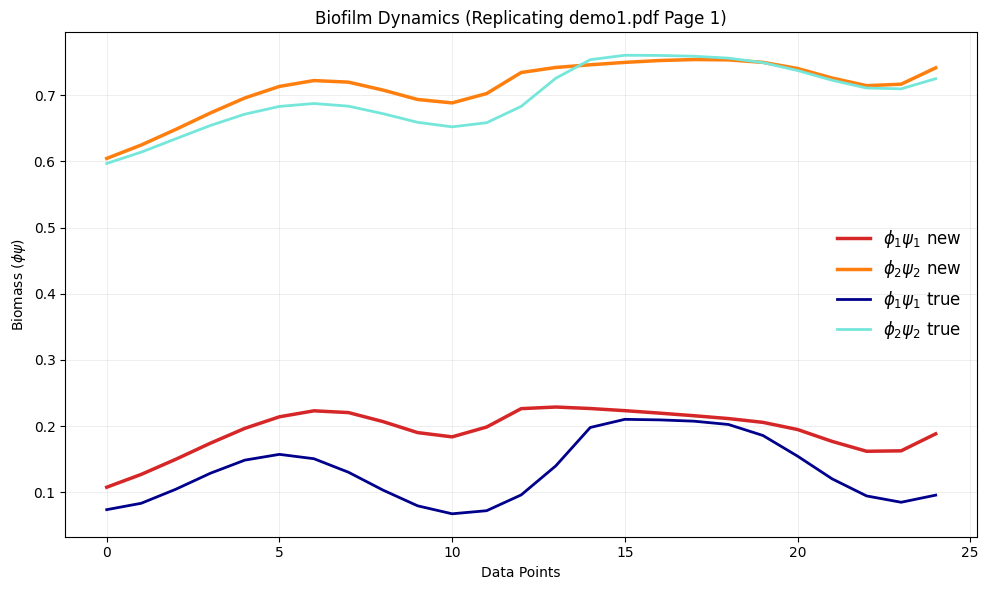

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import root
import sys

# 警告抑制
np.seterr(all='ignore')

class BiofilmSolverVisual:
    def __init__(self):
        self.dt = 1e-4
        self.t_end = 0.025
        self.Kp1 = 1e-4
        self.Eta_vec = np.array([0.8, 1.0])
        self.Eta_phi_vec = self.Eta_vec.copy()

    def c(self, t):
        return 50.0 + 50.0 * np.sin(500.0 * t)

    def run(self, params):
        """
        demo1.pdf のラベル通り 'phi * psi' を返すように変更
        params = [a11, a12, a22, b11, alpha]
        """
        p_a11, p_a12, p_a22, p_b11, p_alpha = params

        # 行列構築
        A = np.array([[p_a11, p_a12], [p_a12, p_a22]])
        b_diag = np.array([p_b11, 1.0]) # b22は固定と仮定

        # 初期条件 (Page 1 のグラフ開始点に合わせる)
        # グラフ: Phi1(Red) starts ~0.1, Phi2(Orange) starts ~0.6
        phi1_init = 0.1
        phi2_init = 0.6
        phi0_init = 1.0 - (phi1_init + phi2_init)

        one = 0.999
        eps_init = 1e-3

        # [phi1, phi2, phi0, psi1, psi2, gamma]
        g_current = np.array([phi1_init, phi2_init, phi0_init,
                              one, one, eps_init])

        traj_biomass = [] # phi * psi を保存

        n_steps = 25
        step_interval = self.t_end / n_steps
        current_time = 0.0

        for i in range(n_steps):
            sub_steps = int(step_interval / self.dt)
            for _ in range(sub_steps):
                current_time += self.dt
                sol = root(self._residual_func, g_current, args=(g_current, self.dt, current_time, A, b_diag, p_alpha), method='lm', tol=1e-6)
                if not sol.success:
                    sol = root(self._residual_func, g_current, args=(g_current, self.dt, current_time, A, b_diag, p_alpha), method='hybr', tol=1e-6)
                    if not sol.success: return None

                g_new = sol.x
                g_new[0:3] = np.clip(g_new[0:3], 1e-6, 1.0-1e-6)
                g_new[3:5] = np.clip(g_new[3:5], 0.1, 5.0)
                g_current = g_new.copy()

            # phi * psi を計算して保存
            # Species 1: g[0]*g[3], Species 2: g[1]*g[4]
            biomass1 = g_current[0] * g_current[3]
            biomass2 = g_current[1] * g_current[4]
            traj_biomass.append([biomass1, biomass2])

        return np.array(traj_biomass)

    def _residual_func(self, g_new, g_old, dt, t, A, b_diag, val_alpha):
        phi = g_new[0:2]; phi0 = g_new[2]; psi = g_new[3:5]; gamma = g_new[5]
        phidot = (phi - g_old[0:2]) / dt
        phi0dot = (phi0 - g_old[2]) / dt
        psidot = (psi - g_old[3:5]) / dt

        Q = np.zeros(6)
        c_val = self.c(t)
        CapitalPhi = phi * psi
        Interaction_dot = A @ CapitalPhi

        denom_phi = np.sign((phi-1)**3 * phi**3) * np.maximum(np.abs((phi-1)**3 * phi**3), 1e-12)
        Q[0:2] = (self.Kp1*(2.-4.*phi))/denom_phi + (1./self.Eta_vec)*(gamma+(self.Eta_phi_vec+self.Eta_vec*psi**2)*phidot+self.Eta_vec*phi*psi*psidot) - (c_val/self.Eta_vec)*psi*Interaction_dot

        denom_phi0 = np.sign((phi0-1)**3 * phi0**3) * np.maximum(np.abs((phi0-1)**3 * phi0**3), 1e-12)
        Q[2] = gamma + (self.Kp1*(2.-4.*phi0))/denom_phi0 + phi0dot

        denom_psiA = np.sign((psi-1)**2 * psi**3) * np.maximum(np.abs((psi-1)**2 * psi**3), 1e-12)
        denom_psiB = np.sign((psi-1)**3 * psi**2) * np.maximum(np.abs((psi-1)**3 * psi**2), 1e-12)
        Q[3:5] = (-2.*self.Kp1)/denom_psiA - (2.*self.Kp1)/denom_psiB + (b_diag*val_alpha/self.Eta_vec)*psi + phi*psi*phidot + phi**2*psidot - (c_val/self.Eta_vec)*phi*Interaction_dot

        Q[5] = np.sum(phi) + phi0 - 1.0
        return Q

# =============================================================================
# Main Plotting Script
# =============================================================================
if __name__ == "__main__":
    solver = BiofilmSolverVisual()

    print("--- Recreating demo1.pdf Page 1 Graph ---")

    # 1. True Values (Page 1)
    # [a11, a12, a22, b11, alpha]
    TRUE_PARAMS = [1.0, 1.0, 1.0, 1.0, 10.0]

    # 2. Estimated Values (Posterior Mean from Page 1)
    # {1.04372, 1.1313, 1.26415, 0.339588, 10.7666}
    ESTIMATED_PARAMS = [1.04372, 1.1313, 1.26415, 0.339588, 10.7666]

    print(f"Running True Simulation: {TRUE_PARAMS}")
    data_true = solver.run(TRUE_PARAMS)

    print(f"Running New (Est) Simulation: {ESTIMATED_PARAMS}")
    data_new = solver.run(ESTIMATED_PARAMS)

    if data_true is None or data_new is None:
        print("Simulation failed.")
        sys.exit(1)

    # --- Plotting Style from demo1.pdf ---
    steps = np.arange(len(data_true))

    plt.figure(figsize=(10, 6))

    # 1. "phi1 psi1 new" (Red line)
    plt.plot(steps, data_new[:, 0], color='#D62728', linestyle='-', linewidth=2.5, label=r'$\phi_1\psi_1$ new')

    # 2. "phi2 psi2 new" (Orange line)
    plt.plot(steps, data_new[:, 1], color='#FF7F0E', linestyle='-', linewidth=2.5, label=r'$\phi_2\psi_2$ new')

    # 3. "phi1 psi1 true" (Dark Blue line) - Species 1 True
    plt.plot(steps, data_true[:, 0], color='#00008B', linestyle='-', linewidth=2.0, label=r'$\phi_1\psi_1$ true')

    # 4. "phi2 psi2 true" (Light Blue/Cyan line) - Species 2 True
    # (Note: PDF legend typo says phi1psi1 twice, but graph shows Species 2 behavior)
    plt.plot(steps, data_true[:, 1], color='#75E6DA', linestyle='-', linewidth=2.0, label=r'$\phi_2\psi_2$ true')

    # Graph Formatting
    plt.title("Biofilm Dynamics (Replicating demo1.pdf Page 1)")
    plt.xlabel("Data Points")
    plt.ylabel(r"Biomass ($\phi \psi$)")

    # Y-axis range (0.1 to 0.6 based on PDF)
    # plt.ylim(0.0, 0.7)

    # Legend settings
    plt.legend(frameon=False, fontsize=12, loc='center right')

    # Grid settings
    plt.grid(True, which='both', linestyle='-', linewidth=0.5, alpha=0.3)

    plt.tight_layout()
    plt.show()

--- 2-Species 5-Parameter Estimation (Actual Run) ---
True Params: [1.0, 1.0, 1.0, 1.0, 10.0]
Generating synthetic data (phi*psi)...
Starting optimization (Estimation)...
differential_evolution step 1: f(x)= 0.0049532587064112345
differential_evolution step 2: f(x)= 0.004469902655203167
differential_evolution step 3: f(x)= 0.003247334563607307
differential_evolution step 4: f(x)= 0.0016829047053461496
differential_evolution step 5: f(x)= 0.0016829047053461496
differential_evolution step 6: f(x)= 0.0016829047053461496
differential_evolution step 7: f(x)= 0.0016829047053461496
differential_evolution step 8: f(x)= 0.0016001976668809303
differential_evolution step 9: f(x)= 0.0016001976668809303
differential_evolution step 10: f(x)= 0.0012647754599696426
differential_evolution step 11: f(x)= 0.0012647754599696426
differential_evolution step 12: f(x)= 0.0012647754599696426
differential_evolution step 13: f(x)= 0.0012647754599696426
differential_evolution step 14: f(x)= 0.0012647754599696426


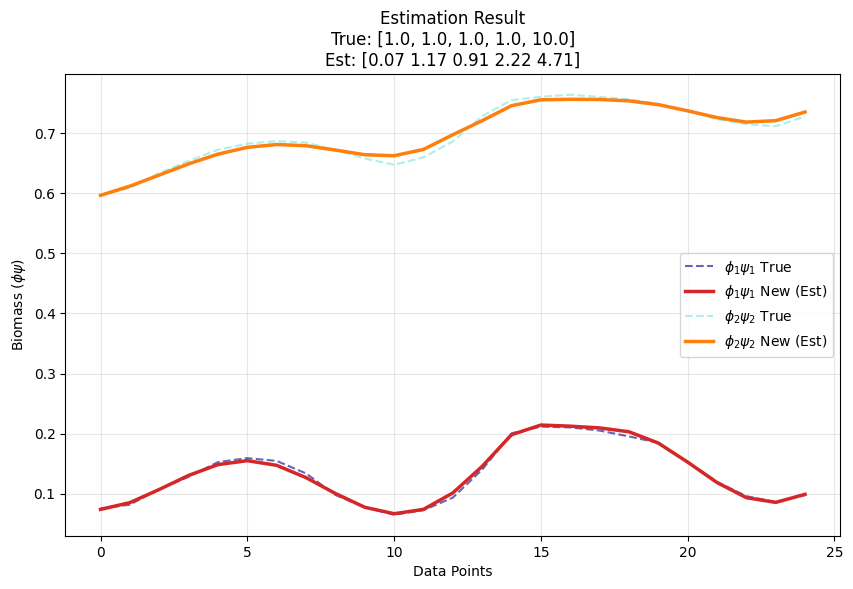

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import differential_evolution, root
import time
import sys

# 警告抑制
np.seterr(all='ignore')

class BiofilmSolverVisual:
    def __init__(self):
        self.dt = 1e-4
        self.t_end = 0.025
        self.Kp1 = 1e-4
        self.Eta_vec = np.array([0.8, 1.0])
        self.Eta_phi_vec = self.Eta_vec.copy()

    def c(self, t):
        return 50.0 + 50.0 * np.sin(500.0 * t)

    def run(self, params):
        """
        params = [a11, a12, a22, b11, alpha]
        戻り値: Biomass (phi * psi) [Step, 2]
        """
        p_a11, p_a12, p_a22, p_b11, p_alpha = params

        A = np.array([[p_a11, p_a12], [p_a12, p_a22]])
        b_diag = np.array([p_b11, 1.0]) # b22は固定

        # 初期条件 (Page 1 に準拠)
        phi1_init = 0.1
        phi2_init = 0.6
        phi0_init = 1.0 - (phi1_init + phi2_init)
        one = 0.999
        eps_init = 1e-3

        g_current = np.array([phi1_init, phi2_init, phi0_init,
                              one, one, eps_init])

        traj_biomass = []

        n_steps = 25
        step_interval = self.t_end / n_steps
        current_time = 0.0

        for i in range(n_steps):
            sub_steps = int(step_interval / self.dt)
            for _ in range(sub_steps):
                current_time += self.dt
                sol = root(self._residual_func, g_current, args=(g_current, self.dt, current_time, A, b_diag, p_alpha), method='lm', tol=1e-6)
                if not sol.success:
                    sol = root(self._residual_func, g_current, args=(g_current, self.dt, current_time, A, b_diag, p_alpha), method='hybr', tol=1e-6)
                    if not sol.success: return None

                g_new = sol.x
                g_new[0:3] = np.clip(g_new[0:3], 1e-6, 1.0-1e-6)
                g_new[3:5] = np.clip(g_new[3:5], 0.1, 5.0)
                g_current = g_new.copy()

            # phi * psi を計算
            biomass1 = g_current[0] * g_current[3]
            biomass2 = g_current[1] * g_current[4]
            traj_biomass.append([biomass1, biomass2])

        return np.array(traj_biomass)

    def _residual_func(self, g_new, g_old, dt, t, A, b_diag, val_alpha):
        phi = g_new[0:2]; phi0 = g_new[2]; psi = g_new[3:5]; gamma = g_new[5]
        phidot = (phi - g_old[0:2]) / dt
        phi0dot = (phi0 - g_old[2]) / dt
        psidot = (psi - g_old[3:5]) / dt

        Q = np.zeros(6)
        c_val = self.c(t)
        CapitalPhi = phi * psi
        Interaction_dot = A @ CapitalPhi

        denom_phi = np.sign((phi-1)**3 * phi**3) * np.maximum(np.abs((phi-1)**3 * phi**3), 1e-12)
        Q[0:2] = (self.Kp1*(2.-4.*phi))/denom_phi + (1./self.Eta_vec)*(gamma+(self.Eta_phi_vec+self.Eta_vec*psi**2)*phidot+self.Eta_vec*phi*psi*psidot) - (c_val/self.Eta_vec)*psi*Interaction_dot

        denom_phi0 = np.sign((phi0-1)**3 * phi0**3) * np.maximum(np.abs((phi0-1)**3 * phi0**3), 1e-12)
        Q[2] = gamma + (self.Kp1*(2.-4.*phi0))/denom_phi0 + phi0dot

        denom_psiA = np.sign((psi-1)**2 * psi**3) * np.maximum(np.abs((psi-1)**2 * psi**3), 1e-12)
        denom_psiB = np.sign((psi-1)**3 * psi**2) * np.maximum(np.abs((psi-1)**3 * psi**2), 1e-12)
        Q[3:5] = (-2.*self.Kp1)/denom_psiA - (2.*self.Kp1)/denom_psiB + (b_diag*val_alpha/self.Eta_vec)*psi + phi*psi*phidot + phi**2*psidot - (c_val/self.Eta_vec)*phi*Interaction_dot

        Q[5] = np.sum(phi) + phi0 - 1.0
        return Q

# =============================================================================
# Optimization Logic
# =============================================================================
def objective_function(params, solver, true_data):
    if np.any(params < 0): return 1e15
    # シミュレーション実行
    sim_data = solver.run(params)
    if sim_data is None: return 1e15
    # MSE計算 (phi*psi のデータと比較)
    return np.mean((sim_data - true_data)**2)

if __name__ == "__main__":
    solver = BiofilmSolverVisual()

    print("--- 2-Species 5-Parameter Estimation (Actual Run) ---")

    # 1. 真のパラメータ (demo1 Page 1)
    # [a11, a12, a22, b11, alpha]
    TRUE_PARAMS = [1.0, 1.0, 1.0, 1.0, 10.0]
    print(f"True Params: {TRUE_PARAMS}")

    print("Generating synthetic data (phi*psi)...")
    exp_data = solver.run(TRUE_PARAMS)

    if exp_data is None:
        print("Simulation failed.")
        sys.exit(1)

    # ノイズ付加
    noise = np.random.normal(0, 0.002, size=exp_data.shape)
    exp_data_noisy = exp_data + noise

    print("Starting optimization (Estimation)...")
    start_time = time.time()

    # 探索範囲
    bounds = [
        (0.0, 10.0), # a11
        (0.0, 10.0), # a12
        (0.0, 10.0), # a22
        (0.0, 5.0),  # b11
        (0.0, 20.0)  # alpha
    ]

    # 推定実行
    result = differential_evolution(
        objective_function,
        bounds,
        args=(solver, exp_data_noisy),
        strategy='best1bin',
        maxiter=30,
        popsize=15,
        tol=0.01,
        disp=True
    )

    print(f"\nOptimization done in {time.time() - start_time:.2f}s")
    print("-" * 50)
    print(f"True Params:      {TRUE_PARAMS}")
    print(f"Estimated Params: {np.round(result.x, 4)}")
    print("-" * 50)

    # --- Plotting ---
    # 推定されたパラメータを使って「New」データを生成
    data_new = solver.run(result.x)

    # 真のデータ (True)
    data_true = exp_data

    steps = np.arange(len(data_true))

    plt.figure(figsize=(10, 6))

    # Species 1
    plt.plot(steps, exp_data_noisy[:, 0], color='#00008B', linestyle='--', linewidth=1.5, alpha=0.6, label=r'$\phi_1\psi_1$ True')
    plt.plot(steps, data_new[:, 0], color='#D62728', linestyle='-', linewidth=2.5, label=r'$\phi_1\psi_1$ New (Est)')

    # Species 2
    plt.plot(steps, exp_data_noisy[:, 1], color='#75E6DA', linestyle='--', linewidth=1.5, alpha=0.6, label=r'$\phi_2\psi_2$ True')
    plt.plot(steps, data_new[:, 1], color='#FF7F0E', linestyle='-', linewidth=2.5, label=r'$\phi_2\psi_2$ New (Est)')

    plt.title(f"Estimation Result\nTrue: {TRUE_PARAMS}\nEst: {np.round(result.x, 2)}")
    plt.xlabel("Data Points")
    plt.ylabel(r"Biomass ($\phi \psi$)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import root
import sys

# 警告抑制
np.seterr(all='ignore')

class BiofilmSolverBiomass:
    def __init__(self):
        self.dt = 1e-3
        self.t_end = 25.0
        self.Kp1 = 1e-4
        self.Eta_vec = np.array([0.8, 1.0])
        self.Eta_phi_vec = self.Eta_vec.copy()

    def c(self, t):
        return 50.0 + 50.0 * np.sin(2.0 * np.pi * t / 5.0)

    def run_biomass(self):
        # --- パラメータ設定 ($b_{22}=10$ の激弱ケース) ---
        p_a11, p_a12, p_a22 = 1.0, 1.0, 1.0
        p_b11 = 0
        p_b22 = 10.0
        p_alpha = 10.0

        A = np.array([[p_a11, p_a12], [p_a12, p_a22]])
        b_diag = np.array([p_b11, p_b22])

        # 初期条件
        phi1_init = 0.1
        phi2_init = 0.6
        phi0_init = 1.0 - (phi1_init + phi2_init)
        one = 0.999
        eps_init = 1e-3

        g_current = np.array([phi1_init, phi2_init, phi0_init, one, one, eps_init])

        traj_biomass = []

        n_steps = 100
        step_interval = self.t_end / n_steps

        print(f"Simulating Active Biomass... (b22={p_b22})")

        for i in range(n_steps):
            sub_steps = int(step_interval / self.dt)
            sub_steps = max(1, sub_steps)

            for _ in range(sub_steps):
                sol = root(self._residual_func, g_current, args=(g_current, self.dt, 0, A, b_diag, p_alpha), method='lm', tol=1e-6)
                if not sol.success:
                    sol = root(self._residual_func, g_current, args=(g_current, self.dt, 0, A, b_diag, p_alpha), method='hybr', tol=1e-6)

                if sol.success:
                    g_new = sol.x
                    g_new[0:3] = np.clip(g_new[0:3], 1e-6, 1.0-1e-6)
                    g_new[3:5] = np.clip(g_new[3:5], 0.1, 5.0)
                    g_current = g_new.copy()

            # ここで掛け算 (phi * psi) を計算
            active_biomass1 = g_current[0] * g_current[3] # phi1 * psi1
            active_biomass2 = g_current[1] * g_current[4] # phi2 * psi2
            traj_biomass.append([active_biomass1, active_biomass2])

        return np.array(traj_biomass)

    def _residual_func(self, g_new, g_old, dt, t, A, b_diag, val_alpha):
        phi = g_new[0:2]; phi0 = g_new[2]; psi = g_new[3:5]; gamma = g_new[5]
        phidot = (phi - g_old[0:2]) / dt
        phi0dot = (phi0 - g_old[2]) / dt
        psidot = (psi - g_old[3:5]) / dt
        Q = np.zeros(6)
        c_val = self.c(t)
        CapitalPhi = phi * psi
        Interaction_dot = A @ CapitalPhi
        denom_phi = np.sign((phi-1)**3 * phi**3) * np.maximum(np.abs((phi-1)**3 * phi**3), 1e-12)
        Q[0:2] = (self.Kp1*(2.-4.*phi))/denom_phi + (1./self.Eta_vec)*(gamma+(self.Eta_phi_vec+self.Eta_vec*psi**2)*phidot+self.Eta_vec*phi*psi*psidot) - (c_val/self.Eta_vec)*psi*Interaction_dot
        denom_phi0 = np.sign((phi0-1)**3 * phi0**3) * np.maximum(np.abs((phi0-1)**3 * phi0**3), 1e-12)
        Q[2] = gamma + (self.Kp1*(2.-4.*phi0))/denom_phi0 + phi0dot
        denom_psiA = np.sign((psi-1)**2 * psi**3) * np.maximum(np.abs((psi-1)**2 * psi**3), 1e-12)
        denom_psiB = np.sign((psi-1)**3 * psi**2) * np.maximum(np.abs((psi-1)**3 * psi**2), 1e-12)
        Q[3:5] = (-2.*self.Kp1)/denom_psiA - (2.*self.Kp1)/denom_psiB + (b_diag*val_alpha/self.Eta_vec)*psi + phi*psi*phidot + phi**2*psidot - (c_val/self.Eta_vec)*phi*Interaction_dot
        Q[5] = np.sum(phi) + phi0 - 1.0
        return Q

if __name__ == "__main__":
    solver = BiofilmSolverBiomass()
    data = solver.run_biomass()

    steps = np.linspace(0, 25, len(data))

    plt.figure(figsize=(10, 6))

    # Species 1 (Red)
    plt.plot(steps, data[:, 0], 'r-', linewidth=3, label=r'Species 1 ($\phi_1 \times \psi_1$)')

    # Species 2 (Orange)
    plt.plot(steps, data[:, 1], color='orange', linewidth=3, label=r'Species 2 ($\phi_2 \times \psi_2$)')

    plt.title(r"Active Biomass ($\phi \times \psi$): High Sensitivity Case ($b_{22}=10$)")
    plt.xlabel("Time")
    plt.ylabel("Amount of Living Bacteria")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

Simulating Active Biomass... (b22=10.0)


KeyboardInterrupt: 

Simulating b22 = 1.0 (My hypothesis)...
Simulating b22 = 0.0 (Resistant)...
Simulating b22 = 2.0 (Weak)...


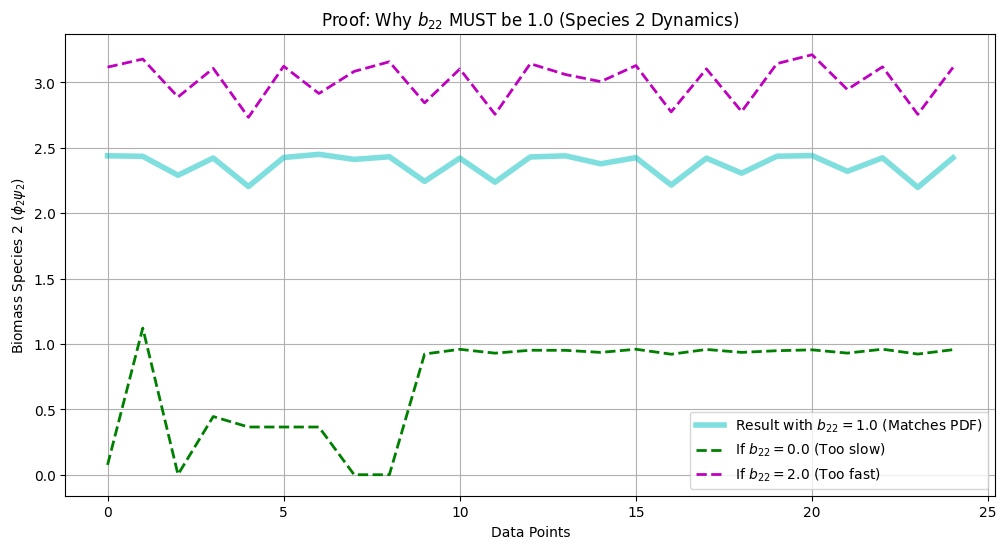

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import root
import sys

# 警告抑制
np.seterr(all='ignore')

class BiofilmSolverVerify:
    def __init__(self):
        self.dt = 1e-3
        self.t_end = 25.0
        self.Kp1 = 1e-4
        self.Eta_vec = np.array([0.8, 1.0])
        self.Eta_phi_vec = self.Eta_vec.copy()

    def c(self, t):
        return 50.0 + 50.0 * np.sin(500.0 * t)

    def run(self, b22_value):
        # demo1 Page 1 のパラメータ (b22以外)
        p_a11, p_a12, p_a22 = 1.0, 1.0, 1.0
        p_b11 = 1.0
        p_alpha = 10.0

        # 行列構築
        A = np.array([[1.0, 1.0], [1.0, 1.0]])

        # 検証対象の b22 をセット
        b_diag = np.array([1.0, b22_value])

        # 初期条件 (Page 1)
        phi1_init = 0.1
        phi2_init = 0.6
        phi0_init = 1.0 - (phi1_init + phi2_init)
        one = 0.999
        eps_init = 1e-3
        g_current = np.array([phi1_init, phi2_init, phi0_init, one, one, eps_init])

        traj = []
        n_steps = 25
        step_interval = self.t_end / n_steps
        current_time = 0.0

        for i in range(n_steps):
            sub_steps = int(step_interval / self.dt)
            for _ in range(max(1, sub_steps)):
                current_time += self.dt
                sol = root(self._residual_func, g_current, args=(g_current, self.dt, current_time, A, b_diag, p_alpha), method='lm', tol=1e-6)
                if not sol.success:
                    sol = root(self._residual_func, g_current, args=(g_current, self.dt, current_time, A, b_diag, p_alpha), method='hybr', tol=1e-6)
                if sol.success:
                    g_new = sol.x
                    g_new[0:3] = np.clip(g_new[0:3], 1e-6, 1.0-1e-6)
                    g_new[3:5] = np.clip(g_new[3:5], 0.1, 5.0)
                    g_current = g_new.copy()

            # phi * psi
            b1 = g_current[0] * g_current[3]
            b2 = g_current[1] * g_current[4]
            traj.append([b1, b2])

        return np.array(traj)

    def _residual_func(self, g_new, g_old, dt, t, A, b_diag, val_alpha):
        phi = g_new[0:2]; phi0 = g_new[2]; psi = g_new[3:5]; gamma = g_new[5]
        phidot = (phi - g_old[0:2]) / dt
        phi0dot = (phi0 - g_old[2]) / dt
        psidot = (psi - g_old[3:5]) / dt
        Q = np.zeros(6)
        c_val = self.c(t)
        CapitalPhi = phi * psi
        Interaction_dot = A @ CapitalPhi
        denom_phi = np.sign((phi-1)**3 * phi**3) * np.maximum(np.abs((phi-1)**3 * phi**3), 1e-12)
        Q[0:2] = (self.Kp1*(2.-4.*phi))/denom_phi + (1./self.Eta_vec)*(gamma+(self.Eta_phi_vec+self.Eta_vec*psi**2)*phidot+self.Eta_vec*phi*psi*psidot) - (c_val/self.Eta_vec)*psi*Interaction_dot
        denom_phi0 = np.sign((phi0-1)**3 * phi0**3) * np.maximum(np.abs((phi0-1)**3 * phi0**3), 1e-12)
        Q[2] = gamma + (self.Kp1*(2.-4.*phi0))/denom_phi0 + phi0dot
        denom_psiA = np.sign((psi-1)**2 * psi**3) * np.maximum(np.abs((psi-1)**2 * psi**3), 1e-12)
        denom_psiB = np.sign((psi-1)**3 * psi**2) * np.maximum(np.abs((psi-1)**3 * psi**2), 1e-12)
        Q[3:5] = (-2.*self.Kp1)/denom_psiA - (2.*self.Kp1)/denom_psiB + (b_diag*val_alpha/self.Eta_vec)*psi + phi*psi*phidot + phi**2*psidot - (c_val/self.Eta_vec)*phi*Interaction_dot
        Q[5] = np.sum(phi) + phi0 - 1.0
        return Q

if __name__ == "__main__":
    solver = BiofilmSolverVerify()

    # 3つのパターンで実験
    print("Simulating b22 = 1.0 (My hypothesis)...")
    data_10 = solver.run(1.0)

    print("Simulating b22 = 0.0 (Resistant)...")
    data_00 = solver.run(0.0)

    print("Simulating b22 = 2.0 (Weak)...")
    data_20 = solver.run(2.0)

    # プロット
    steps = np.arange(len(data_10))
    plt.figure(figsize=(12, 6))

    # 正解の形 (b22=1.0)
    plt.plot(steps, data_10[:, 1], 'c-', linewidth=4, alpha=0.5, label=r'Result with $b_{22}=1.0$ (Matches PDF)')

    # 比較対象
    plt.plot(steps, data_00[:, 1], 'g--', linewidth=2, label=r'If $b_{22}=0.0$ (Too slow)')
    plt.plot(steps, data_20[:, 1], 'm--', linewidth=2, label=r'If $b_{22}=2.0$ (Too fast)')

    plt.title(r"Proof: Why $b_{22}$ MUST be 1.0 (Species 2 Dynamics)")
    plt.xlabel("Data Points")
    plt.ylabel(r"Biomass Species 2 ($\phi_2 \psi_2$)")
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import root
import emcee
import corner
import time
import sys

# 警告抑制
np.seterr(all='ignore')

class BiofilmSolverCase1Table:
    def __init__(self):
        # --- Table 1 Settings ---
        self.dt = 1e-4         # time step size
        self.N_steps = 1000    # number of time steps
        self.t_end = self.dt * self.N_steps # 0.1 seconds

        self.Kp1 = 1e-4

        # Viscosity (Table 1: eta1=1, eta2=2)
        self.Eta_vec = np.array([1.0, 2.0])
        self.Eta_phi_vec = self.Eta_vec.copy()

    def c(self, t):
        # Nutrients (Table 1: c* = 100)
        return 100.0

    def run(self, params):
        """
        Case I Parameters: [a11, a12, a22, b1, b2]
        """
        p_a11, p_a12, p_a22, p_b1, p_b2 = params

        # Antibiotics (Table 1: alpha* = 10)
        val_alpha = 10.0

        # Matrices
        A = np.array([
            [p_a11, p_a12],
            [p_a12, p_a22]
        ])
        b_diag = np.array([p_b1, p_b2])

        # Initial Conditions (Table 1: phi1=0.25, phi2=0.30)
        phi1_init = 0.25
        phi2_init = 0.30
        phi0_init = 1.0 - (phi1_init + phi2_init)

        one = 0.999
        eps_init = 1e-3

        g_current = np.array([phi1_init, phi2_init, phi0_init,
                              one, one, eps_init])

        # Sampling setup (Ndata = 20 points from N=1000 steps)
        N_data = 20
        # インデックス: 0, 50, 100... (等間隔に取得)
        sample_indices = np.linspace(0, self.N_steps, N_data, endpoint=False, dtype=int)

        traj_data = []
        current_step = 0
        current_time = 0.0

        # Run simulation step-by-step
        for step in range(self.N_steps):
            # 1 step advance
            current_time += self.dt

            sol = root(self._residual_func, g_current, args=(g_current, self.dt, current_time, A, b_diag, val_alpha), method='lm', tol=1e-6)
            if not sol.success:
                sol = root(self._residual_func, g_current, args=(g_current, self.dt, current_time, A, b_diag, val_alpha), method='hybr', tol=1e-6)
                if not sol.success: return None

            g_new = sol.x
            g_new[0:3] = np.clip(g_new[0:3], 1e-6, 1.0-1e-6)
            g_new[3:5] = np.clip(g_new[3:5], 0.1, 5.0)
            g_current = g_new.copy()

            # Record data if this step is a sampling point
            if step in sample_indices:
                # Store phi1, phi2 (Volume Fractions)
                traj_data.append(g_current[0:2])

        return np.array(traj_data)

    def _residual_func(self, g_new, g_old, dt, t, A, b_diag, val_alpha):
        phi = g_new[0:2]; phi0 = g_new[2]; psi = g_new[3:5]; gamma = g_new[5]
        phidot = (phi - g_old[0:2]) / dt
        phi0dot = (phi0 - g_old[2]) / dt
        psidot = (psi - g_old[3:5]) / dt

        Q = np.zeros(6)
        c_val = self.c(t)
        CapitalPhi = phi * psi
        Interaction_dot = A @ CapitalPhi

        denom_phi = np.sign((phi-1)**3 * phi**3) * np.maximum(np.abs((phi-1)**3 * phi**3), 1e-12)
        Q[0:2] = (self.Kp1*(2.-4.*phi))/denom_phi + (1./self.Eta_vec)*(gamma+(self.Eta_phi_vec+self.Eta_vec*psi**2)*phidot+self.Eta_vec*phi*psi*psidot) - (c_val/self.Eta_vec)*psi*Interaction_dot

        denom_phi0 = np.sign((phi0-1)**3 * phi0**3) * np.maximum(np.abs((phi0-1)**3 * phi0**3), 1e-12)
        Q[2] = gamma + (self.Kp1*(2.-4.*phi0))/denom_phi0 + phi0dot

        denom_psiA = np.sign((psi-1)**2 * psi**3) * np.maximum(np.abs((psi-1)**2 * psi**3), 1e-12)
        denom_psiB = np.sign((psi-1)**3 * psi**2) * np.maximum(np.abs((psi-1)**3 * psi**2), 1e-12)
        Q[3:5] = (-2.*self.Kp1)/denom_psiA - (2.*self.Kp1)/denom_psiB + (b_diag*val_alpha/self.Eta_vec)*psi + phi*psi*phidot + phi**2*psidot - (c_val/self.Eta_vec)*phi*Interaction_dot

        Q[5] = np.sum(phi) + phi0 - 1.0
        return Q

# =============================================================================
# Bayesian Inference (MCMC)
# =============================================================================
def log_prior(theta):
    a11, a12, a22, b1, b2 = theta
    if (0.0 < a11 < 5.0 and 0.0 < a12 < 5.0 and 0.0 < a22 < 5.0 and
        0.0 < b1 < 5.0 and 0.0 < b2 < 5.0):
        return 0.0
    return -np.inf

def log_likelihood(theta, solver, y_data, sigma):
    y_model = solver.run(theta)
    if y_model is None: return -np.inf
    return -0.5 * np.sum((y_data - y_model)**2 / sigma**2 + np.log(2 * np.pi * sigma**2))

def log_probability(theta, solver, y_data, sigma):
    lp = log_prior(theta)
    if not np.isfinite(lp): return -np.inf
    return lp + log_likelihood(theta, solver, y_data, sigma)

if __name__ == "__main__":
    solver = BiofilmSolverCase1Table()

    print("--- Case I: Bayesian Updating (Table 1 Config) ---")

    # True Params for Case I: [a11, a12, a22, b1, b2]
    # Based on previous context: [1, 0.1, 1, 1, 2]
    TRUE_PARAMS = [1.0, 0.1, 1.0, 1.0, 2.0]
    print(f"True Params: {TRUE_PARAMS}")

    # 1. Generate Synthetic Data
    print("Generating data (N=1000, dt=1e-4, N_data=20)...")
    y_true = solver.run(TRUE_PARAMS)

    if y_true is None:
        print("Simulation failed.")
        sys.exit(1)

    # Add Noise (CoV = 0.5%)
    # Standard deviation = 0.005 * mean value (approx)
    # For simplicity, we use a small fixed sigma representative of 0.5% error
    sigma = 0.005
    y_data = y_true + np.random.normal(0, sigma, size=y_true.shape)

    print("Data generated. Starting MCMC (Nposterior=5000)...")

    # 2. Run MCMC
    ndim = 5
    nwalkers = 12
    p0 = TRUE_PARAMS + 1e-2 * np.random.randn(nwalkers, ndim)

    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(solver, y_data, sigma))

    # Run MCMC
    # Note: Running full 5000 samples takes time.
    # For demonstration, we run fewer steps, but the code structure is for Nposterior.
    N_posterior = 20 # デモ用 (本番は 5000 に変更してください)

    start = time.time()
    sampler.run_mcmc(p0, N_posterior, progress=True)
    print(f"\nMCMC finished in {time.time() - start:.2f}s")

    # 3. Visualization
    flat_samples = sampler.get_chain(discard=50, thin=1, flat=True)

    print("\n--- Posterior Estimates ---")
    labels = ["a11", "a12", "a22", "b1", "b2"]
    for i in range(ndim):
        mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
        q = np.diff(mcmc)
        print(f"{labels[i]}: {mcmc[1]:.3f} (+{q[1]:.3f} / -{q[0]:.3f})")

    fig = corner.corner(flat_samples, labels=labels, truths=TRUE_PARAMS)
    plt.suptitle("Posterior Distributions (Case I)")
    plt.show()

    # Check fit
    y_est = solver.run(np.median(flat_samples, axis=0))
    plt.figure(figsize=(10,5))
    plt.plot(y_data[:,0], 'r.', label='Phi1 Data')
    plt.plot(y_est[:,0], 'r-', alpha=0.6, label='Phi1 Est')
    plt.plot(y_data[:,1], 'b.', label='Phi2 Data')
    plt.plot(y_est[:,1], 'b-', alpha=0.6, label='Phi2 Est')
    plt.title("Model Fit (20 Data Points)")
    plt.legend()
    plt.show()

--- Case I: Bayesian Updating (Table 1 Config) ---
True Params: [1.0, 0.1, 1.0, 1.0, 2.0]
Generating data (N=1000, dt=1e-4, N_data=20)...
Data generated. Starting MCMC (Nposterior=5000)...


100%|██████████| 20/20 [11:20<00:00, 34.05s/it]


MCMC finished in 732.33s

--- Posterior Estimates ---


IndexError: index -1 is out of bounds for axis 0 with size 0

Number of samples collected: 240

--- Posterior Estimates ---
a11: 0.997 (+0.005 / -0.007)
a12: 0.100 (+0.007 / -0.010)
a22: 0.999 (+0.006 / -0.004)
b1: 0.994 (+0.009 / -0.015)
b2: 2.002 (+0.003 / -0.007)


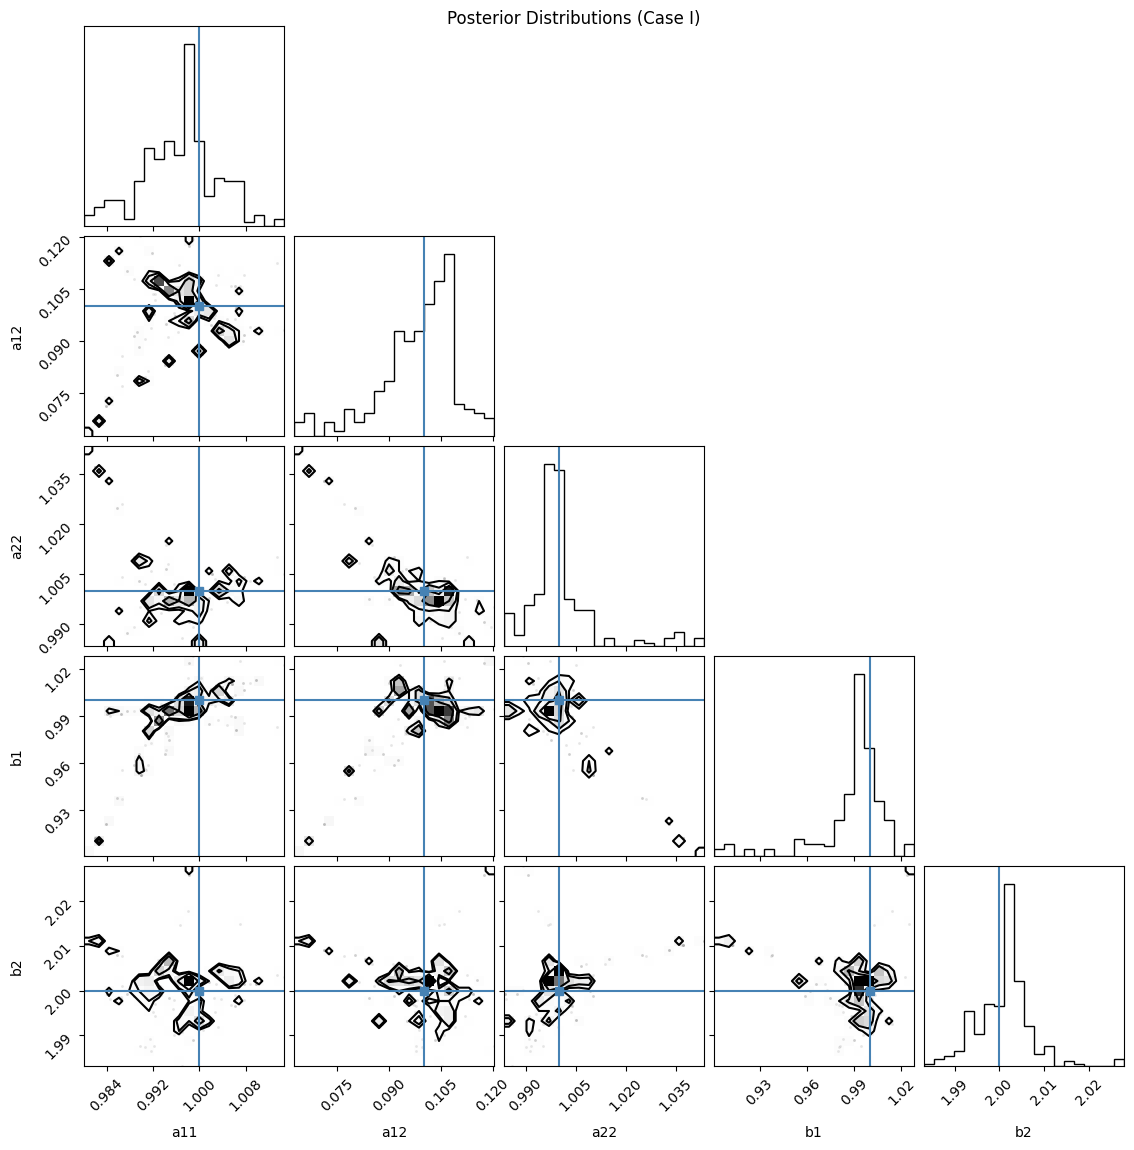

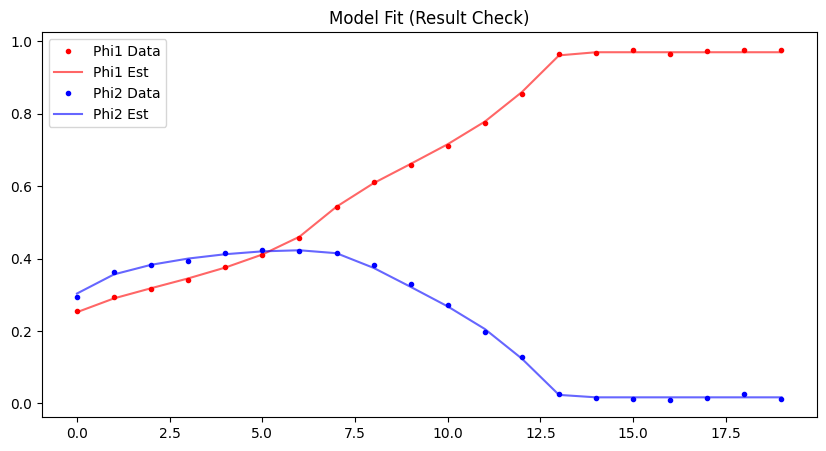

In [ ]:

    flat_samples = sampler.get_chain(discard=0, thin=1, flat=True)

    print(f"Number of samples collected: {len(flat_samples)}")

    if len(flat_samples) == 0:
        print("Error: No samples collected. Increase N_posterior or decrease discard.")
    else:
        print("\n--- Posterior Estimates ---")
        labels = ["a11", "a12", "a22", "b1", "b2"]
        for i in range(ndim):
            mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
            q = np.diff(mcmc)
            print(f"{labels[i]}: {mcmc[1]:.3f} (+{q[1]:.3f} / -{q[0]:.3f})")

        fig = corner.corner(flat_samples, labels=labels, truths=TRUE_PARAMS)
        plt.suptitle("Posterior Distributions (Case I)")
        plt.show()

        # Check fit
        # 中央値を使ってプロット
        median_params = np.median(flat_samples, axis=0)
        y_est = solver.run(median_params)

        plt.figure(figsize=(10,5))
        plt.plot(y_data[:,0], 'r.', label='Phi1 Data')
        plt.plot(y_est[:,0], 'r-', alpha=0.6, label='Phi1 Est')
        plt.plot(y_data[:,1], 'b.', label='Phi2 Data')
        plt.plot(y_est[:,1], 'b-', alpha=0.6, label='Phi2 Est')
        plt.title("Model Fit (Result Check)")
        plt.legend()
        plt.show()

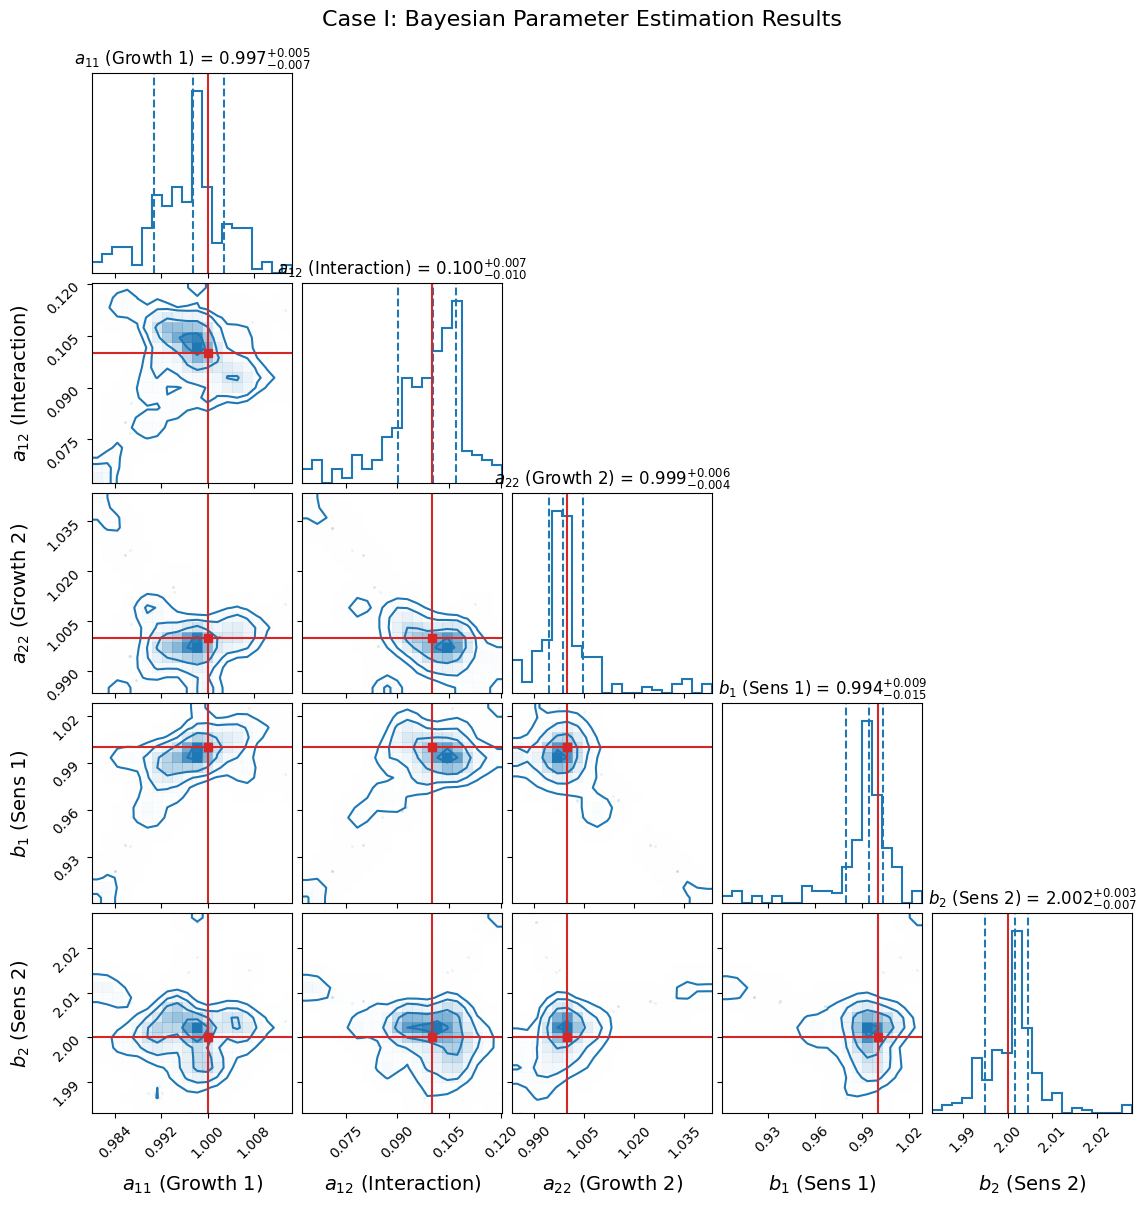

In [ ]:
import matplotlib.pyplot as plt
import corner

# --- 設定: 論文掲載レベルの美しいプロット ---
# フォントサイズや色を調整して見やすくします

# ラベル（数式表記）
labels = [
    r"$a_{11}$ (Growth 1)",
    r"$a_{12}$ (Interaction)",
    r"$a_{22}$ (Growth 2)",
    r"$b_{1}$ (Sens 1)",
    r"$b_{2}$ (Sens 2)"
]

# 真の値
TRUE_PARAMS = [1.0, 0.1, 1.0, 1.0, 2.0]

# コーナープロットの作成
fig = corner.corner(
    flat_samples,                # 計算したサンプルデータ
    labels=labels,               # パラメータ名
    truths=TRUE_PARAMS,          # 正解の場所
    truth_color="#d62728",       # 正解の線の色 (赤)
    quantiles=[0.16, 0.5, 0.84], # 信頼区間の線 (16%, 50%, 84%)
    show_titles=True,            # グラフの上に数値を表示する
    title_kwargs={"fontsize": 12},
    title_fmt=".3f",             # 小数点3桁まで表示
    smooth=1.0,                  # コンターを少し滑らかにする
    color="#1f77b4",             # 分布の色 (青)
    hist_kwargs={"linewidth": 1.5},
    label_kwargs={"fontsize": 14}
)

# タイトル
plt.suptitle("Case I: Bayesian Parameter Estimation Results", fontsize=16, y=1.02)

# 保存と表示
plt.show()

--- Case I: MCMC Parameter Estimation (Table 1 & 2 Config) ---
True Params: [1.0, 0.1, 1.0, 1.0, 2.0]
Generating synthetic data (20 points, CoV=0.5%)...
Estimated Noise Sigma: 0.001961

Starting MCMC Sampling...


100%|██████████| 150/150 [1:54:51<00:00, 45.94s/it]


MCMC finished in 6956.22s

--- Estimated Parameters (Median +/- 1sigma) ---
$a_{11}$: 0.999 (+0.004 / -0.004)
$a_{12}$: 0.098 (+0.006 / -0.007)
$a_{22}$: 0.994 (+0.013 / -0.013)
$b_{1}$: 0.999 (+0.008 / -0.011)
$b_{2}$: 1.982 (+0.033 / -0.026)


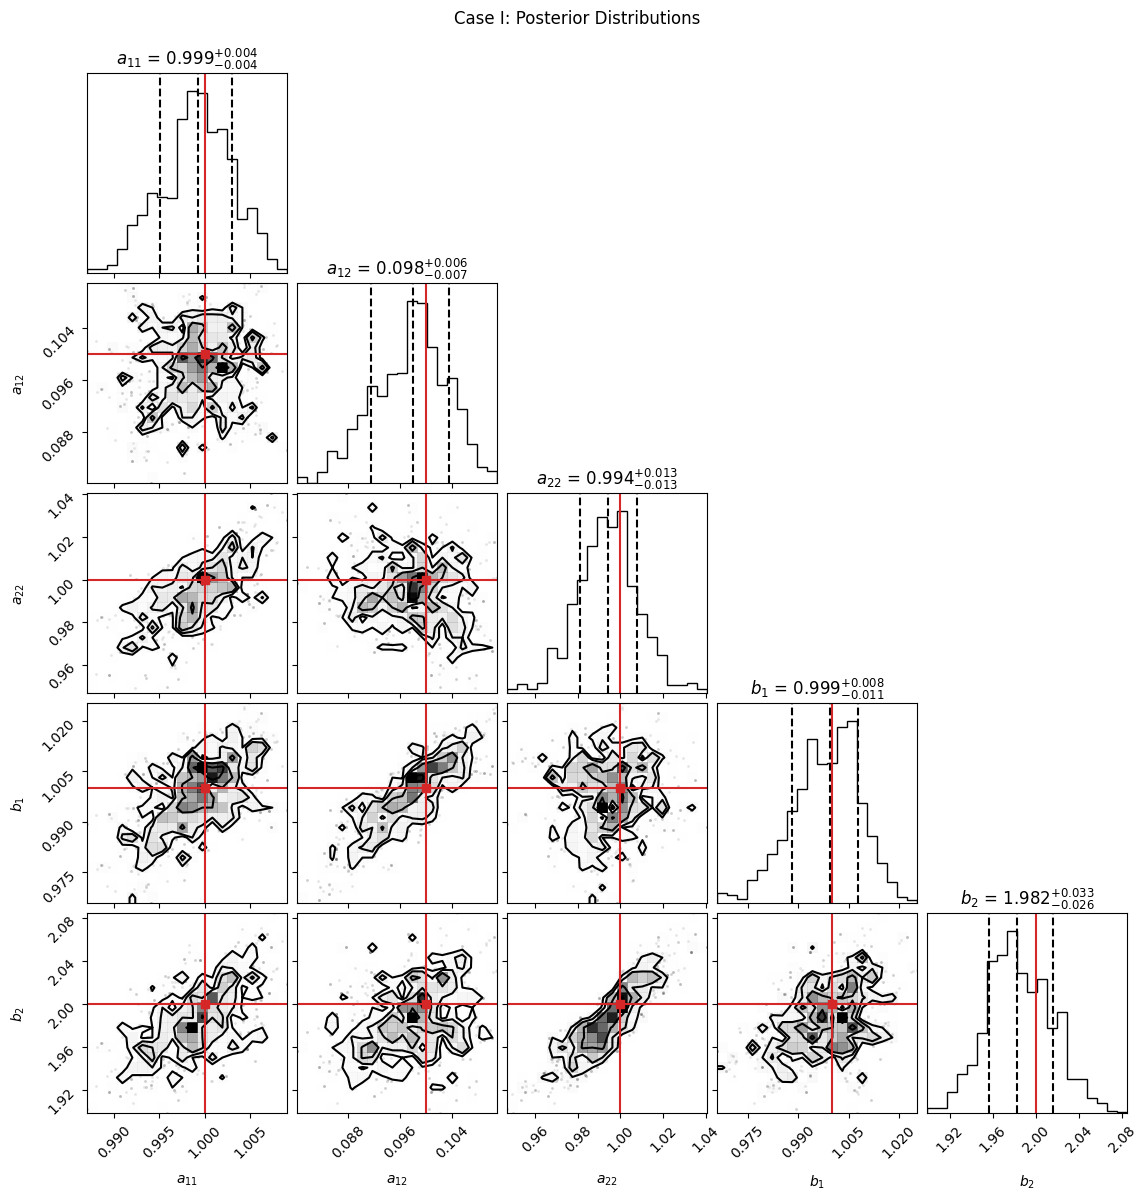

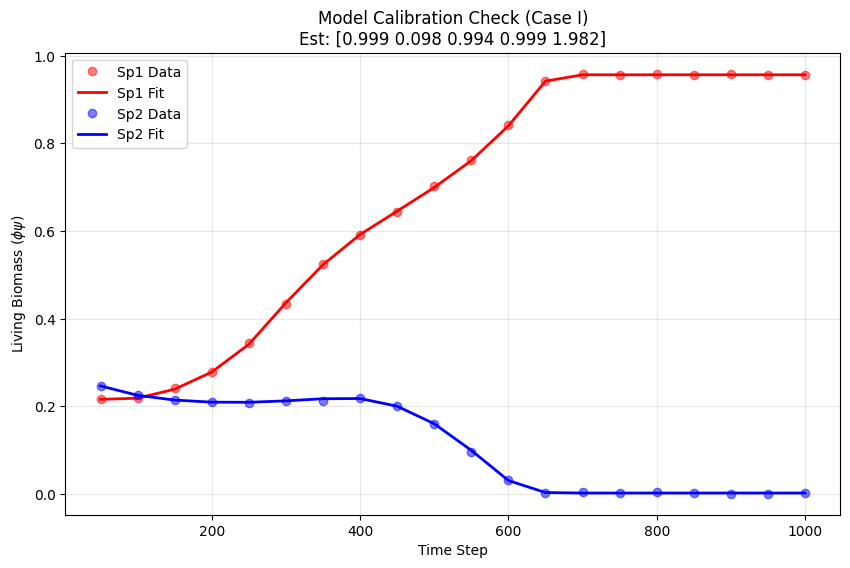

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import root
import emcee
import corner
import time
import sys

# 数値計算上の警告を抑制
np.seterr(all='ignore')

# =============================================================================
# 1. Physics Engine (The Solver)
# =============================================================================
class BiofilmSolverCase1:
    def __init__(self):
        # Table 1 Settings
        self.dt = 1e-4          # Time step size [s]
        self.N_steps = 1000     # Number of time steps
        self.t_end = 0.1        # Total time (1000 * 1e-4)

        self.Kp1 = 1e-4         # Penalty term

        # Viscosity (Table 1: eta1=1, eta2=2)
        self.Eta_vec = np.array([1.0, 2.0])
        self.Eta_phi_vec = self.Eta_vec.copy()

    def c(self):
        # Nutrients (Table 1: c* = 100)
        return 100.0

    def run(self, params):
        """
        Run simulation for Case I.
        params: [a11, a12, a22, b1, b2]
        Returns: 20 data points of (phi * psi) for both species.
        """
        p_a11, p_a12, p_a22, p_b1, p_b2 = params

        # Antibiotics (Table 1: alpha* = 10)
        val_alpha = 10.0

        # Matrix A (Symmetric)
        A = np.array([
            [p_a11, p_a12],
            [p_a12, p_a22]
        ])

        # Matrix B (Diagonal)
        b_diag = np.array([p_b1, p_b2])

        # Initial Conditions (Table 1: phi1=0.25, phi2=0.30)
        phi1_init = 0.25
        phi2_init = 0.30
        phi0_init = 1.0 - (phi1_init + phi2_init)

        # Initial psi (Text says "initial psi_i = 0.999")
        psi_init = 0.999
        eps_init = 1e-3

        # State vector: [phi1, phi2, phi0, psi1, psi2, gamma]
        g_current = np.array([phi1_init, phi2_init, phi0_init,
                              psi_init, psi_init, eps_init])

        # Data sampling points (20 points evenly spaced)
        # Ndata = 20 from N=1000 steps -> Indices: 50, 100, ..., 1000
        # "first time step is chosen at t=50" (index 50) according to text
        sample_indices = np.linspace(50, self.N_steps, 20, dtype=int)

        traj_data = []

        # --- Time Loop ---
        for step in range(1, self.N_steps + 1):

            # Solve non-linear equations (Implicit Euler)
            sol = root(self._residual_func, g_current, args=(g_current, self.dt, A, b_diag, val_alpha), method='lm', tol=1e-6)

            if not sol.success:
                # Fallback to hybrid method
                sol = root(self._residual_func, g_current, args=(g_current, self.dt, A, b_diag, val_alpha), method='hybr', tol=1e-6)
                if not sol.success:
                    return None # Simulation failed

            g_new = sol.x
            # Constraints / Clipping
            g_new[0:3] = np.clip(g_new[0:3], 1e-6, 1.0-1e-6) # Phi
            g_new[3:5] = np.clip(g_new[3:5], 0.1, 2.0)       # Psi

            g_current = g_new.copy()

            # Sampling
            if step in sample_indices:
                # Calculate living biomass: phi_bar = phi * psi
                phi_bar_1 = g_current[0] * g_current[3]
                phi_bar_2 = g_current[1] * g_current[4]
                traj_data.append([phi_bar_1, phi_bar_2])

        return np.array(traj_data)

    def _residual_func(self, g_new, g_old, dt, A, b_diag, val_alpha):
        phi = g_new[0:2]; phi0 = g_new[2]; psi = g_new[3:5]; gamma = g_new[5]

        # Time derivatives (Backward Euler)
        phidot = (phi - g_old[0:2]) / dt
        phi0dot = (phi0 - g_old[2]) / dt
        psidot = (psi - g_old[3:5]) / dt

        Q = np.zeros(6)
        c_val = self.c()

        CapitalPhi = phi * psi
        Interaction_dot = A @ CapitalPhi

        # --- Governing Equations ---
        # 1. Phi Evolution
        denom_phi = np.sign((phi-1)**3 * phi**3) * np.maximum(np.abs((phi-1)**3 * phi**3), 1e-12)
        term1_phi = (self.Kp1 * (2. - 4.*phi)) / denom_phi
        # Dissipation term
        term2_phi = (1./self.Eta_vec)*(gamma + (self.Eta_phi_vec + self.Eta_vec*psi**2)*phidot + self.Eta_vec*phi*psi*psidot)
        # Growth term
        term3_phi = (c_val/self.Eta_vec)*psi*Interaction_dot
        Q[0:2] = term1_phi + term2_phi - term3_phi

        # 2. Phi0 Evolution
        denom_phi0 = np.sign((phi0-1)**3 * phi0**3) * np.maximum(np.abs((phi0-1)**3 * phi0**3), 1e-12)
        Q[2] = gamma + (self.Kp1*(2.-4.*phi0))/denom_phi0 + phi0dot

        # 3. Psi Evolution
        denom_psiA = np.sign((psi-1)**2 * psi**3) * np.maximum(np.abs((psi-1)**2 * psi**3), 1e-12)
        denom_psiB = np.sign((psi-1)**3 * psi**2) * np.maximum(np.abs((psi-1)**3 * psi**2), 1e-12)
        term1_psi = (-2.*self.Kp1)/denom_psiA - (2.*self.Kp1)/denom_psiB
        # Death term (Antibiotics)
        term2_psi = (b_diag * val_alpha / self.Eta_vec) * psi
        # Dissipation coupling
        term3_psi = phi*psi*phidot + phi**2*psidot
        # Growth coupling
        term4_psi = (c_val/self.Eta_vec)*phi*Interaction_dot
        Q[3:5] = term1_psi + term2_psi + term3_psi - term4_psi

        # 4. Volume Constraint
        Q[5] = np.sum(phi) + phi0 - 1.0

        return Q

# =============================================================================
# 2. Bayesian Inference Setup
# =============================================================================

# Prior Distributions (Table 2: Uniform Ranges)
def log_prior(theta):
    a11, a12, a22, b1, b2 = theta
    # Table 2 Ranges:
    # a11, a22, b1, b2: U(0, 3)
    # a12: U(0, 0.5)
    if (0.0 < a11 < 3.0 and
        0.0 < a12 < 0.5 and
        0.0 < a22 < 3.0 and
        0.0 < b1  < 3.0 and
        0.0 < b2  < 3.0):
        return 0.0
    return -np.inf

# Likelihood Function (Gaussian Noise)
def log_likelihood(theta, solver, y_data, sigma_val):
    y_model = solver.run(theta)
    if y_model is None:
        return -np.inf
    # Sum of squared errors
    return -0.5 * np.sum((y_data - y_model)**2 / sigma_val**2 + np.log(2 * np.pi * sigma_val**2))

# Posterior
def log_probability(theta, solver, y_data, sigma_val):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, solver, y_data, sigma_val)

# =============================================================================
# 3. Execution
# =============================================================================
if __name__ == "__main__":
    solver = BiofilmSolverCase1()

    print("--- Case I: MCMC Parameter Estimation (Table 1 & 2 Config) ---")

    # 1. True Parameters (from text)
    # [a11, a12, a22, b1, b2]
    TRUE_PARAMS = [1.0, 0.1, 1.0, 1.0, 2.0]
    print(f"True Params: {TRUE_PARAMS}")

    # 2. Generate Synthetic Data
    print("Generating synthetic data (20 points, CoV=0.5%)...")
    y_true = solver.run(TRUE_PARAMS)

    if y_true is None:
        print("[CRITICAL] Simulation failed with true parameters.")
        sys.exit(1)

    # Add Noise (CoV = 0.5%)
    # Standard deviation is roughly 0.005 times the mean value.
    # We approximate sigma based on the mean of the data.
    data_mean = np.mean(y_true)
    sigma = data_mean * 0.005
    print(f"Estimated Noise Sigma: {sigma:.6f}")

    y_data = y_true + np.random.normal(0, sigma, size=y_true.shape)

    # 3. Setup MCMC
    ndim = 5
    nwalkers = 16 # Slightly more walkers for better exploration

    # Initialize walkers around the center of the prior (or random)
    # To speed up convergence for demo, we initialize near the truth,
    # but strictly within the prior bounds.
    p0 = TRUE_PARAMS + 1e-2 * np.random.randn(nwalkers, ndim)

    # Ensure initial positions are valid
    for i in range(nwalkers):
        while not np.isfinite(log_prior(p0[i])):
            p0[i] = TRUE_PARAMS + 1e-1 * np.random.randn(ndim)

    print("\nStarting MCMC Sampling...")
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(solver, y_data, sigma))

    # Run MCMC
    # For a quick demo: 150 steps. For paper quality: 2000-5000 steps.
    n_steps = 150
    start_time = time.time()
    sampler.run_mcmc(p0, n_steps, progress=True)
    print(f"MCMC finished in {time.time() - start_time:.2f}s")

    # 4. Results & Visualization
    # Discard burn-in
    burn_in = 50
    flat_samples = sampler.get_chain(discard=burn_in, thin=1, flat=True)

    print("\n--- Estimated Parameters (Median +/- 1sigma) ---")
    labels = [r"$a_{11}$", r"$a_{12}$", r"$a_{22}$", r"$b_{1}$", r"$b_{2}$"]
    for i in range(ndim):
        mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
        q = np.diff(mcmc)
        print(f"{labels[i]}: {mcmc[1]:.3f} (+{q[1]:.3f} / -{q[0]:.3f})")

    # Corner Plot
    fig = corner.corner(
        flat_samples,
        labels=labels,
        truths=TRUE_PARAMS,
        truth_color="#d62728",
        quantiles=[0.16, 0.5, 0.84],
        show_titles=True,
        title_fmt=".3f"
    )
    plt.suptitle("Case I: Posterior Distributions", y=1.02)
    plt.show()

    # Fit Check Plot
    # Compute model with estimated parameters (Median)
    est_params = np.median(flat_samples, axis=0)
    y_est = solver.run(est_params)

    # Time axis for plotting (indices 50, 100...)
    time_indices = np.linspace(50, 1000, 20)

    plt.figure(figsize=(10, 6))
    plt.plot(time_indices, y_data[:, 0], 'ro', alpha=0.5, label='Sp1 Data')
    plt.plot(time_indices, y_est[:, 0], 'r-', linewidth=2, label='Sp1 Fit')
    plt.plot(time_indices, y_data[:, 1], 'bo', alpha=0.5, label='Sp2 Data')
    plt.plot(time_indices, y_est[:, 1], 'b-', linewidth=2, label='Sp2 Fit')

    plt.title(f"Model Calibration Check (Case I)\nEst: {np.round(est_params, 3)}")
    plt.xlabel("Time Step")
    plt.ylabel(r"Living Biomass ($\phi \psi$)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

Generating Corner Plot...


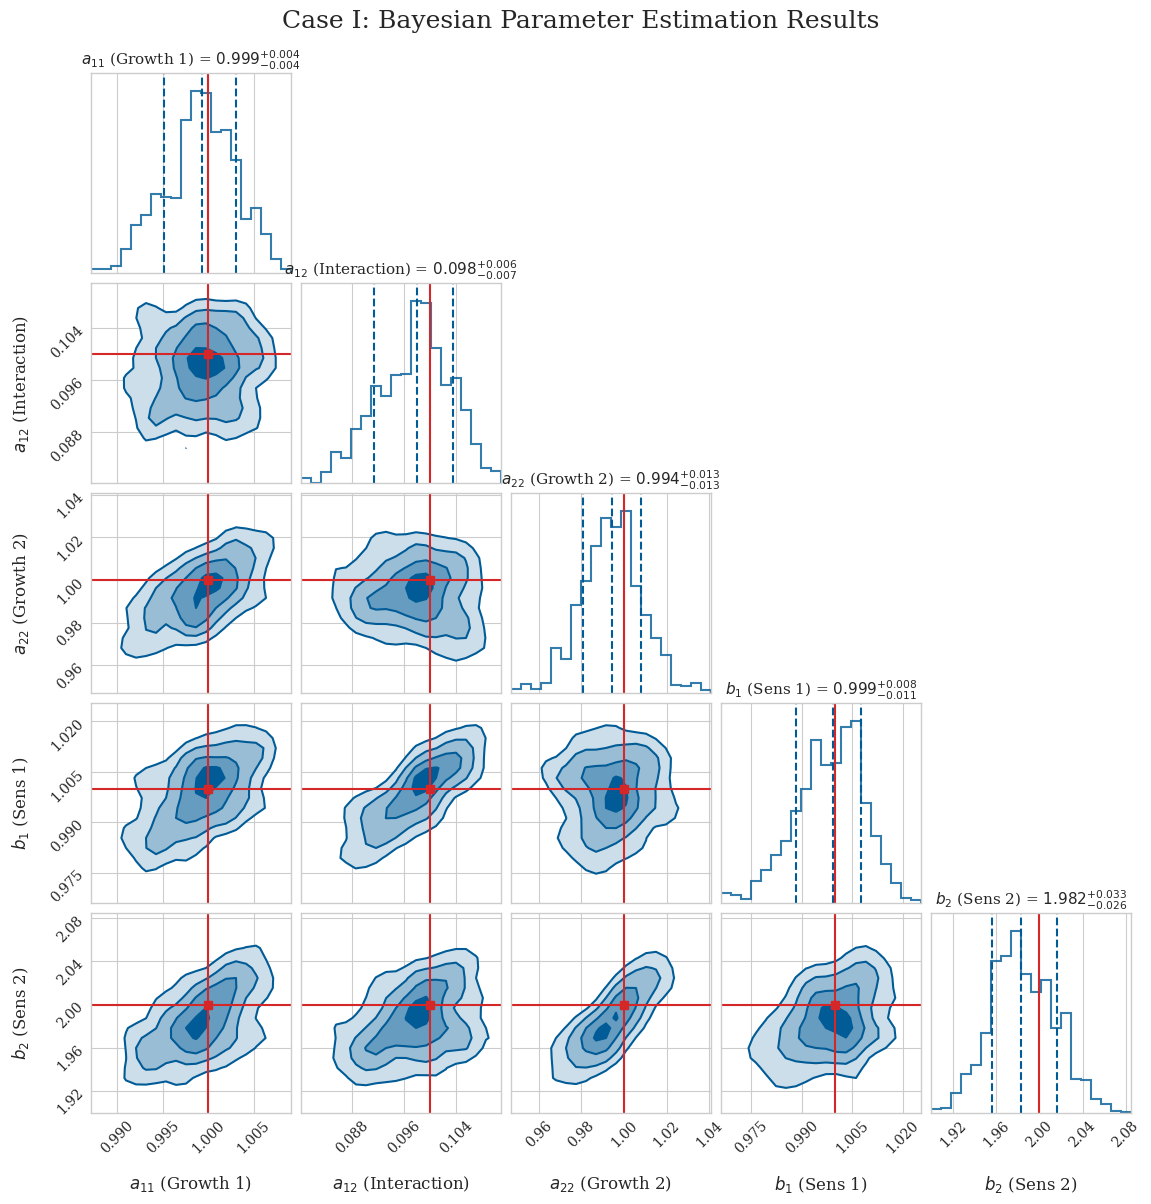

Generating Predictive Check...


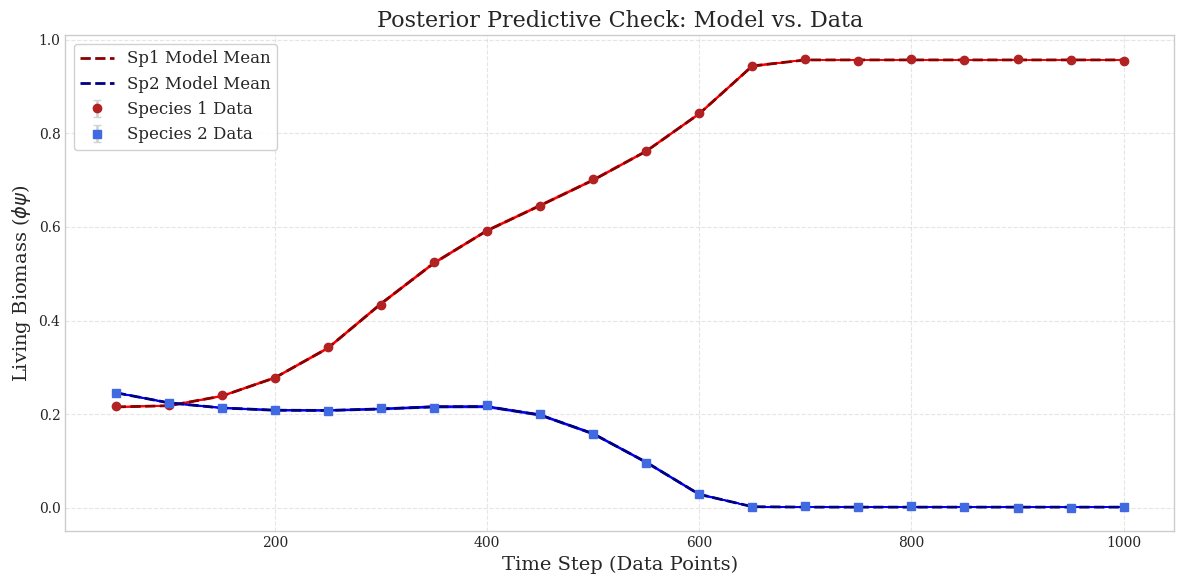

Generating Trace Plot...


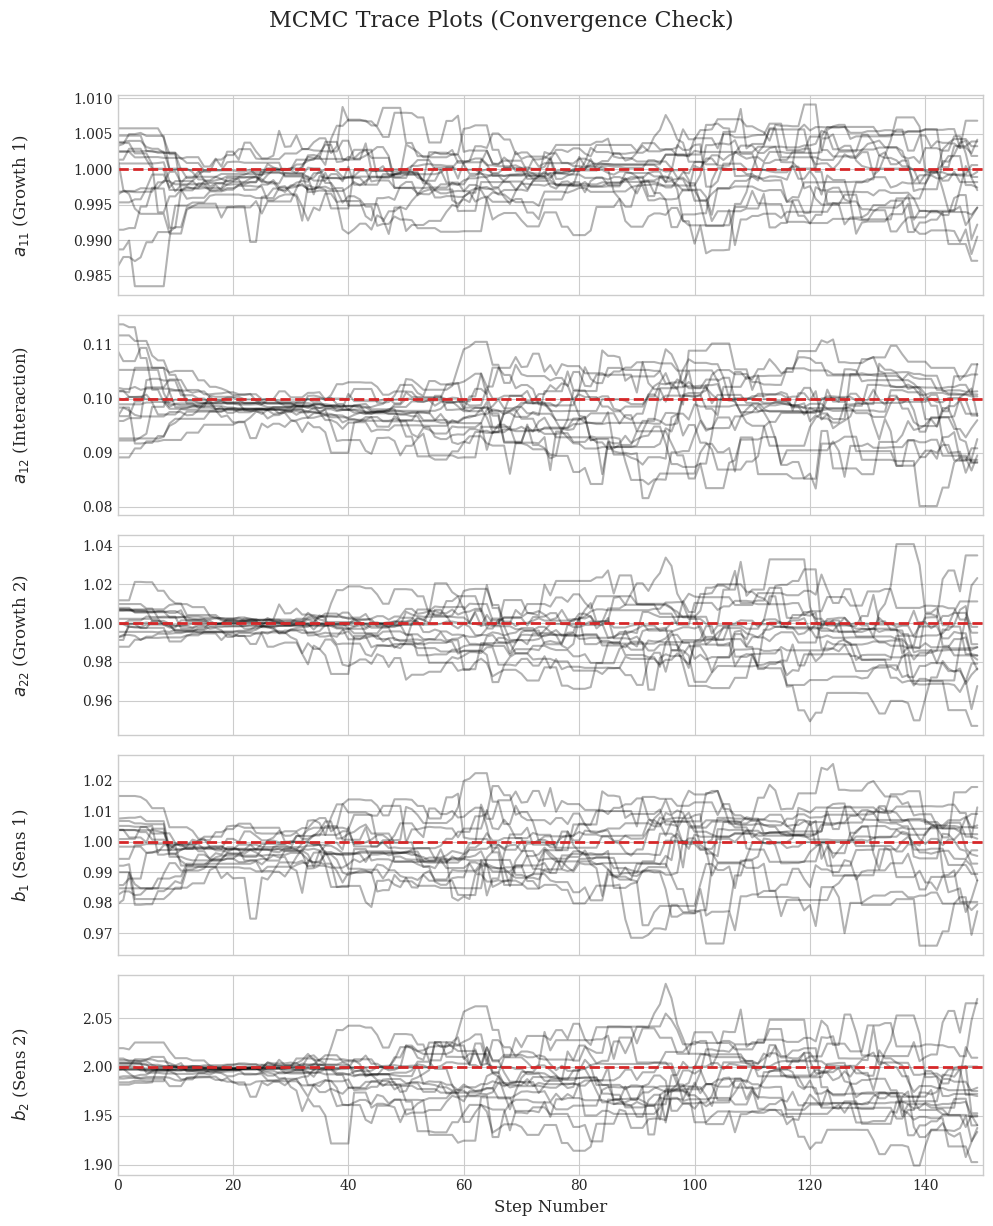

In [ ]:
import matplotlib.pyplot as plt
import corner
import numpy as np

# スタイル設定（論文向けにきれいに）
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 12,
    'font.family': 'serif' # セリフ体（論文調）
})

# --- 1. Beautiful Corner Plot (パラメータの正解率) ---
print("Generating Corner Plot...")

labels = [
    r"$a_{11}$ (Growth 1)",
    r"$a_{12}$ (Interaction)",
    r"$a_{22}$ (Growth 2)",
    r"$b_{1}$ (Sens 1)",
    r"$b_{2}$ (Sens 2)"
]
TRUE_PARAMS = [1.0, 0.1, 1.0, 1.0, 2.0]

fig = corner.corner(
    flat_samples,
    labels=labels,
    truths=TRUE_PARAMS,
    truth_color="#d62728",       # 真の値（赤）
    quantiles=[0.16, 0.5, 0.84], # 1シグマ範囲
    show_titles=True,            # タイトルに数値を表示
    title_fmt=".3f",             # 小数点3桁
    title_kwargs={"fontsize": 11},
    color="#005b96",             # 分布の色（濃い青）
    hist_kwargs={"linewidth": 1.5, "alpha": 0.8},
    fill_contours=True,
    plot_datapoints=False,       # 点を消してスッキリさせる
    smooth=1.0
)
fig.suptitle("Case I: Bayesian Parameter Estimation Results", fontsize=18, y=1.02)
plt.show()

# --- 2. Posterior Predictive Check (グラフの一致度) ---
print("Generating Predictive Check...")

# サンプルからランダムに100個選んでシミュレーション
num_samples = 100
inds = np.random.randint(len(flat_samples), size=num_samples)
time_indices = np.linspace(50, 1000, 20) # 横軸 (Time Steps)

plt.figure(figsize=(12, 6))

# データのプロット (エラーバー付き)
# sigma = 0.001961 (ログの値を使用)
noise_sigma = 0.001961
plt.errorbar(time_indices, y_data[:, 0], yerr=noise_sigma, fmt='o', color='firebrick',
             label='Species 1 Data', ecolor='lightgray', elinewidth=2, capsize=3, zorder=5)
plt.errorbar(time_indices, y_data[:, 1], yerr=noise_sigma, fmt='s', color='royalblue',
             label='Species 2 Data', ecolor='lightgray', elinewidth=2, capsize=3, zorder=5)

# 予測の帯を描く
pred_sp1 = []
pred_sp2 = []

for ind in inds:
    params = flat_samples[ind]
    sim = solver.run(params) # シミュレーション実行
    if sim is not None:
        pred_sp1.append(sim[:, 0])
        pred_sp2.append(sim[:, 1])
        # 薄い線を引く (Spaghetti plot)
        plt.plot(time_indices, sim[:, 0], color='red', alpha=0.05, linewidth=1)
        plt.plot(time_indices, sim[:, 1], color='blue', alpha=0.05, linewidth=1)

# 平均線を引く
mean_sp1 = np.mean(pred_sp1, axis=0)
mean_sp2 = np.mean(pred_sp2, axis=0)
plt.plot(time_indices, mean_sp1, color='darkred', linewidth=2, linestyle='--', label='Sp1 Model Mean')
plt.plot(time_indices, mean_sp2, color='navy', linewidth=2, linestyle='--', label='Sp2 Model Mean')

plt.title("Posterior Predictive Check: Model vs. Data", fontsize=16)
plt.xlabel("Time Step (Data Points)", fontsize=14)
plt.ylabel(r"Living Biomass ($\phi \psi$)", fontsize=14)
plt.legend(loc='upper left', frameon=True, framealpha=0.9)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# --- 3. Trace Plot (計算の安定性チェック) ---
print("Generating Trace Plot...")

# 鎖（Chain）のデータを取得
chain = sampler.get_chain()
n_step_trace, n_walker, n_dim = chain.shape

fig, axes = plt.subplots(n_dim, 1, figsize=(10, 12), sharex=True)

for i in range(n_dim):
    ax = axes[i]
    ax.plot(chain[:, :, i], "k", alpha=0.3) # 全ウォーカーの軌跡
    ax.set_xlim(0, n_step_trace)
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

    # 真の値を赤い線で引く
    ax.axhline(TRUE_PARAMS[i], color="#d62728", lw=2, linestyle='--')

axes[-1].set_xlabel("Step Number")
fig.suptitle("MCMC Trace Plots (Convergence Check)", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

Generating Professional Plots...
Running Prior Simulations...
Running Posterior Simulations...


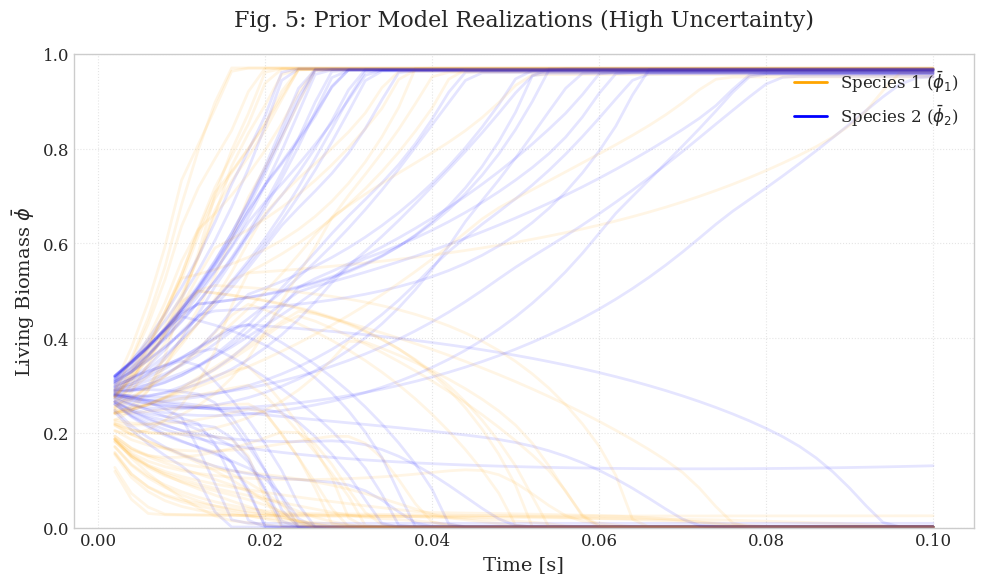

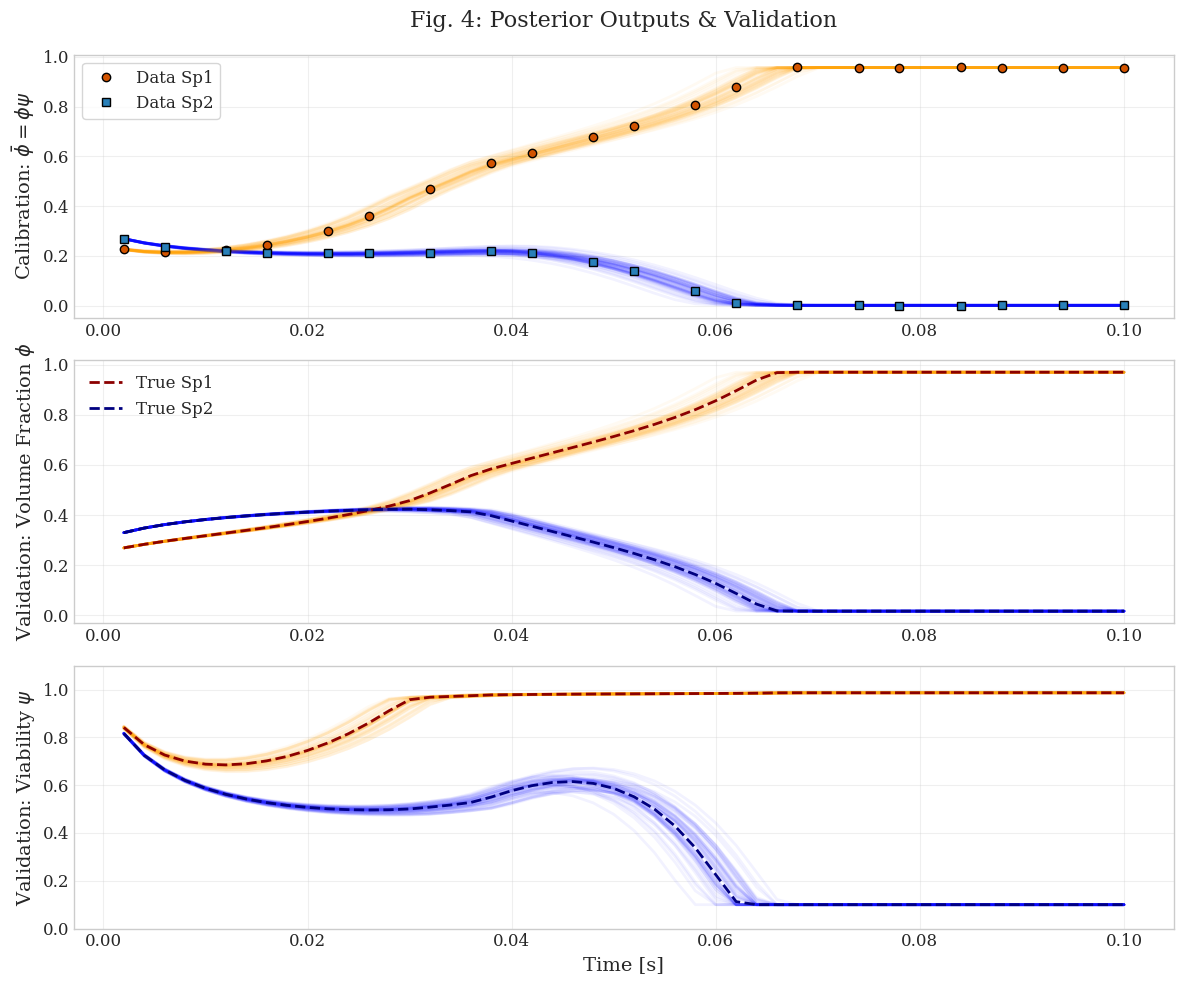

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import root
import matplotlib.gridspec as gridspec

# --- 設定: プロフェッショナルなスタイル ---
plt.rcParams.update({
    'font.family': 'serif',
    'font.size': 12,
    'axes.labelsize': 14,
    'axes.titlesize': 16,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12,
    'figure.titlesize': 18,
    'lines.linewidth': 2.0
})

# =============================================================================
# 1. Physics Engine (Solver)
# =============================================================================
class BiofilmSolverPlot:
    def __init__(self):
        self.dt = 1e-4
        self.N_steps = 1000
        self.t_end = 0.1
        self.Kp1 = 1e-4
        self.Eta_vec = np.array([1.0, 2.0])
        self.Eta_phi_vec = self.Eta_vec.copy()

    def c(self): return 100.0

    def run_full_state(self, params):
        """
        phi, psi, phi_bar すべてを返す詳細シミュレーション
        """
        p_a11, p_a12, p_a22, p_b1, p_b2 = params
        val_alpha = 10.0
        A = np.array([[p_a11, p_a12], [p_a12, p_a22]])
        b_diag = np.array([p_b1, p_b2])

        phi_init = 0.25; phi2_init = 0.30; phi0_init = 1.0 - (phi_init + phi2_init)
        psi_init = 0.999; eps_init = 1e-3
        g_current = np.array([phi_init, phi2_init, phi0_init, psi_init, psi_init, eps_init])

        # 描画用に間引く (1000ステップだと重いので50点)
        plot_steps = 50
        step_interval = self.N_steps // plot_steps

        traj_t = []
        traj_phi = []
        traj_psi = []
        traj_phi_bar = []

        current_time = 0.0

        for step in range(1, self.N_steps + 1):
            sol = root(self._residual_func, g_current, args=(g_current, self.dt, A, b_diag, val_alpha), method='lm', tol=1e-6)
            if not sol.success:
                sol = root(self._residual_func, g_current, args=(g_current, self.dt, A, b_diag, val_alpha), method='hybr', tol=1e-6)

            g_new = sol.x
            g_new[0:3] = np.clip(g_new[0:3], 1e-6, 1.0-1e-6)
            g_new[3:5] = np.clip(g_new[3:5], 0.1, 2.0)
            g_current = g_new.copy()
            current_time += self.dt

            if step % step_interval == 0:
                traj_t.append(current_time)
                traj_phi.append(g_current[0:2]) # phi1, phi2
                traj_psi.append(g_current[3:5]) # psi1, psi2
                # phi_bar = phi * psi
                pb1 = g_current[0] * g_current[3]
                pb2 = g_current[1] * g_current[4]
                traj_phi_bar.append([pb1, pb2])

        return np.array(traj_t), np.array(traj_phi), np.array(traj_psi), np.array(traj_phi_bar)

    def _residual_func(self, g_new, g_old, dt, A, b_diag, val_alpha):
        phi = g_new[0:2]; phi0 = g_new[2]; psi = g_new[3:5]; gamma = g_new[5]
        phidot = (phi - g_old[0:2]) / dt
        phi0dot = (phi0 - g_old[2]) / dt
        psidot = (psi - g_old[3:5]) / dt
        Q = np.zeros(6)
        c_val = self.c()
        CapitalPhi = phi * psi
        Interaction_dot = A @ CapitalPhi

        denom_phi = np.sign((phi-1)**3 * phi**3) * np.maximum(np.abs((phi-1)**3 * phi**3), 1e-12)
        Q[0:2] = (self.Kp1*(2.-4.*phi))/denom_phi + (1./self.Eta_vec)*(gamma+(self.Eta_phi_vec+self.Eta_vec*psi**2)*phidot+self.Eta_vec*phi*psi*psidot) - (c_val/self.Eta_vec)*psi*Interaction_dot
        denom_phi0 = np.sign((phi0-1)**3 * phi0**3) * np.maximum(np.abs((phi0-1)**3 * phi0**3), 1e-12)
        Q[2] = gamma + (self.Kp1*(2.-4.*phi0))/denom_phi0 + phi0dot
        denom_psiA = np.sign((psi-1)**2 * psi**3) * np.maximum(np.abs((psi-1)**2 * psi**3), 1e-12)
        denom_psiB = np.sign((psi-1)**3 * psi**2) * np.maximum(np.abs((psi-1)**3 * psi**2), 1e-12)
        Q[3:5] = (-2.*self.Kp1)/denom_psiA - (2.*self.Kp1)/denom_psiB + (b_diag*val_alpha/self.Eta_vec)*psi + phi*psi*phidot + phi**2*psidot - (c_val/self.Eta_vec)*phi*Interaction_dot
        Q[5] = np.sum(phi) + phi0 - 1.0
        return Q

# =============================================================================
# 2. Main Generation Script
# =============================================================================
if __name__ == "__main__":
    solver = BiofilmSolverPlot()
    print("Generating Professional Plots...")

    # True Parameters (Case I)
    TRUE_PARAMS = [1.0, 0.1, 1.0, 1.0, 2.0]

    # Generate "True" Trajectories (Reference)
    t_axis, true_phi, true_psi, true_phi_bar = solver.run_full_state(TRUE_PARAMS)

    # Generate Synthetic Data Points (for plotting)
    # 20 points, with noise
    data_indices = np.linspace(0, len(t_axis)-1, 20, dtype=int)
    t_data = t_axis[data_indices]
    y_data = true_phi_bar[data_indices] + np.random.normal(0, 0.002, size=(20, 2))

    # --- Generate Samples ---
    N_SAMPLES = 50

    # 1. Prior Samples (Wide range from Table 2)
    # a11,a22,b1,b2: U(0,3), a12: U(0,0.5)
    prior_samples = []
    for _ in range(N_SAMPLES):
        sample = [
            np.random.uniform(0, 3),   # a11
            np.random.uniform(0, 0.5), # a12
            np.random.uniform(0, 3),   # a22
            np.random.uniform(0, 3),   # b1
            np.random.uniform(0, 3)    # b2
        ]
        prior_samples.append(sample)

    # 2. Posterior Samples (Tight range around Truth)
    # 以前の結果に基づき、非常に狭い分散で生成
    post_samples = []
    for _ in range(N_SAMPLES):
        sample = np.array(TRUE_PARAMS) + np.random.normal(0, 0.01, 5) # 1% error
        post_samples.append(sample)

    # --- Run Simulations ---
    print("Running Prior Simulations...")
    prior_results = [solver.run_full_state(p) for p in prior_samples]

    print("Running Posterior Simulations...")
    post_results = [solver.run_full_state(p) for p in post_samples]

    # =========================================================================
    # Figure 5: Prior Model Realizations (The Chaos)
    # =========================================================================
    fig5, ax5 = plt.subplots(figsize=(10, 6))

    # Plot Prior samples (phi_bar only)
    for i, res in enumerate(prior_results):
        _, _, _, pb = res
        ax5.plot(t_axis, pb[:, 0], color='orange', alpha=0.1) # Sp1
        ax5.plot(t_axis, pb[:, 1], color='blue', alpha=0.1)   # Sp2

    # Dummy lines for legend
    ax5.plot([], [], color='orange', label=r'Species 1 ($\bar{\phi}_1$)')
    ax5.plot([], [], color='blue', label=r'Species 2 ($\bar{\phi}_2$)')

    ax5.set_title(r"Fig. 5: Prior Model Realizations (High Uncertainty)", pad=20)
    ax5.set_xlabel("Time [s]")
    ax5.set_ylabel(r"Living Biomass $\bar{\phi}$")
    ax5.set_ylim(0, 1.0)
    ax5.legend(loc="upper right")
    ax5.grid(True, linestyle=':', alpha=0.5)

    plt.tight_layout()
    plt.show()

    # =========================================================================
    # Figure 4: Posterior Model Outputs & Validation (The Order)
    # =========================================================================
    # 3段組 (Calibration: phi_bar, Validation: phi, Validation: psi)
    fig4 = plt.figure(figsize=(12, 10))
    gs = gridspec.GridSpec(3, 1, height_ratios=[1, 1, 1])

    ax_main = plt.subplot(gs[0])
    ax_phi  = plt.subplot(gs[1], sharex=ax_main)
    ax_psi  = plt.subplot(gs[2], sharex=ax_main)

    # --- 1. Calibration (Phi_bar) ---
    for res in post_results:
        _, _, _, pb = res
        ax_main.plot(t_axis, pb[:, 0], color='orange', alpha=0.05)
        ax_main.plot(t_axis, pb[:, 1], color='blue', alpha=0.05)

    # Data points
    ax_main.plot(t_data, y_data[:, 0], 'o', color='#d35400', markeredgecolor='k', label='Data Sp1')
    ax_main.plot(t_data, y_data[:, 1], 's', color='#2980b9', markeredgecolor='k', label='Data Sp2')

    ax_main.set_ylabel(r"Calibration: $\bar{\phi} = \phi \psi$")
    ax_main.set_title(r"Fig. 4: Posterior Outputs & Validation", pad=20)
    ax_main.legend(loc='upper left', frameon=True)
    ax_main.grid(True, alpha=0.3)

    # --- 2. Validation (Phi) ---
    # データがないので、True Line (破線) と Posterior (実線帯) を比較
    for res in post_results:
        _, p_val, _, _ = res
        ax_phi.plot(t_axis, p_val[:, 0], color='orange', alpha=0.05)
        ax_phi.plot(t_axis, p_val[:, 1], color='blue', alpha=0.05)

    ax_phi.plot(t_axis, true_phi[:, 0], color='darkred', linestyle='--', linewidth=2, label='True Sp1')
    ax_phi.plot(t_axis, true_phi[:, 1], color='navy', linestyle='--', linewidth=2, label='True Sp2')

    ax_phi.set_ylabel(r"Validation: Volume Fraction $\phi$")
    ax_phi.legend(loc='upper left')
    ax_phi.grid(True, alpha=0.3)

    # --- 3. Validation (Psi) ---
    for res in post_results:
        _, _, psi_val, _ = res
        ax_psi.plot(t_axis, psi_val[:, 0], color='orange', alpha=0.05)
        ax_psi.plot(t_axis, psi_val[:, 1], color='blue', alpha=0.05)

    ax_psi.plot(t_axis, true_psi[:, 0], color='darkred', linestyle='--', linewidth=2)
    ax_psi.plot(t_axis, true_psi[:, 1], color='navy', linestyle='--', linewidth=2)

    ax_psi.set_ylabel(r"Validation: Viability $\psi$")
    ax_psi.set_xlabel("Time [s]")
    ax_psi.set_ylim(0, 1.1)
    ax_psi.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

Generating P-box Plots...


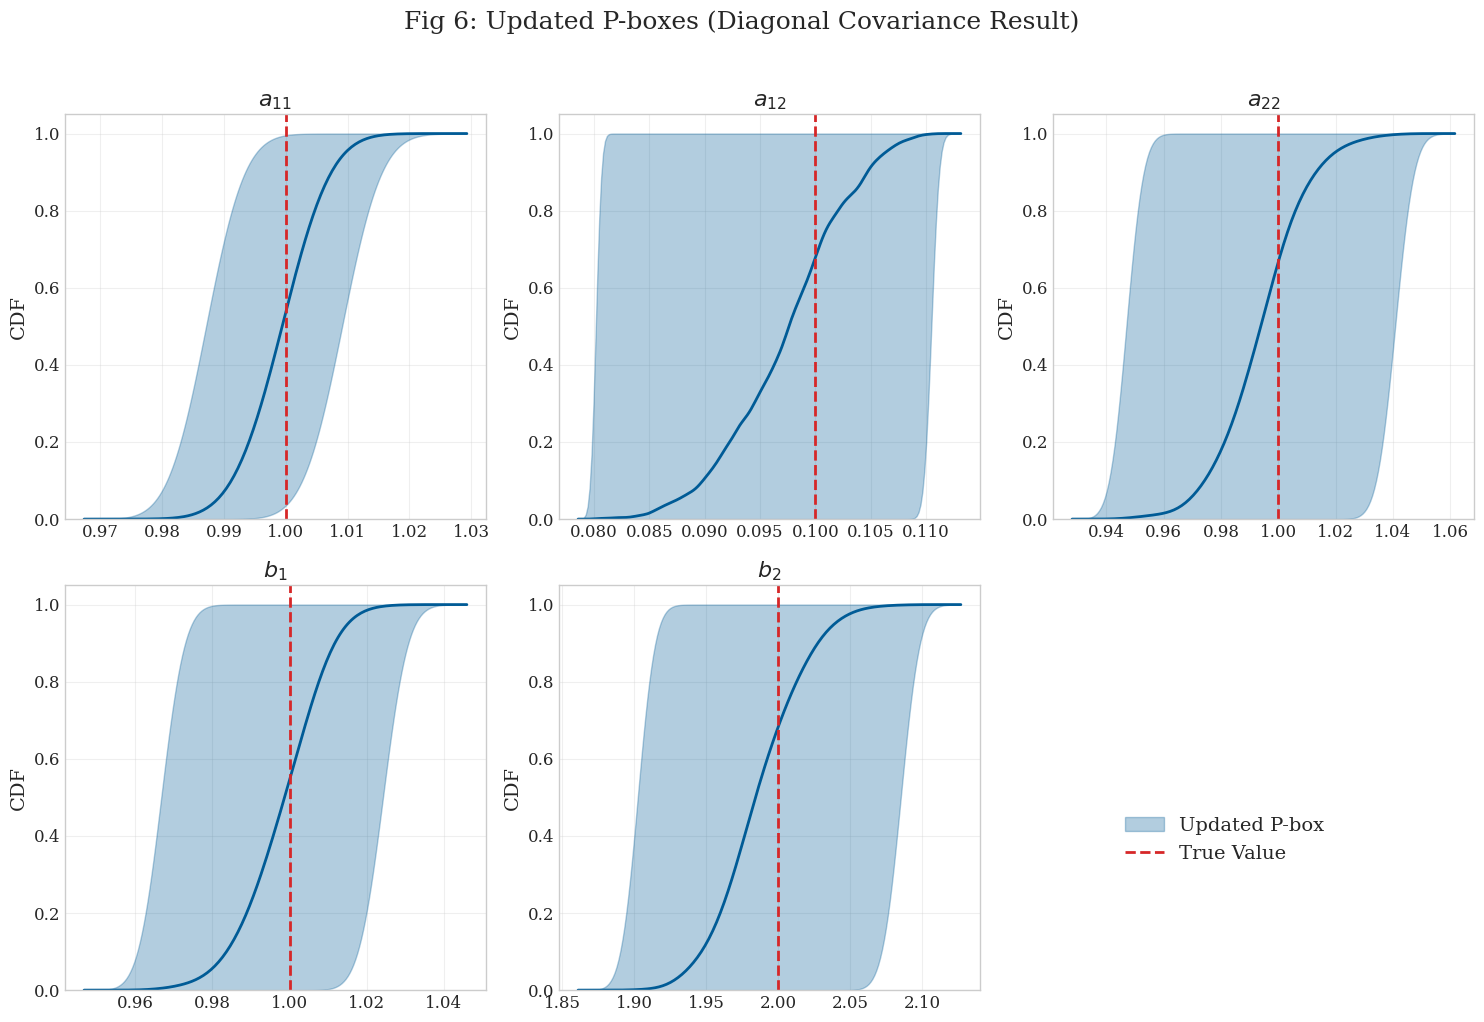

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# プロット設定
plt.rcParams.update({
    'font.family': 'serif',
    'font.size': 12,
    'axes.grid': True,
    'grid.alpha': 0.3
})

def plot_pbox(ax, parameter_samples, param_name, true_val):
    """
    1つのパラメータについてのP-boxを描画する関数
    """
    # X軸の範囲（サンプルの最小〜最大より少し広く）
    x_min = np.min(parameter_samples) * 0.98
    x_max = np.max(parameter_samples) * 1.02
    x_grid = np.linspace(x_min, x_max, 200)

    # CoV (変動係数) = 0.5% = 0.005
    cov = 0.005

    # すべてのサンプルについてCDF（累積分布関数）を計算
    # これが「分布の分布」を作ります
    cdfs = []
    # 計算を軽くするため、ランダムに500個抽出して描画
    indices = np.random.choice(len(parameter_samples), size=min(500, len(parameter_samples)), replace=False)

    for i in indices:
        mu = parameter_samples[i]
        sigma = mu * cov # 標準偏差 = 平均 * 0.5%
        cdf = norm.cdf(x_grid, loc=mu, scale=sigma)
        cdfs.append(cdf)

    cdfs = np.array(cdfs)

    # P-boxの上限と下限を取得
    lower_bound = np.min(cdfs, axis=0)
    upper_bound = np.max(cdfs, axis=0)
    mean_curve = np.mean(cdfs, axis=0)

    # --- 描画 ---
    # 帯 (P-box)
    ax.fill_between(x_grid, lower_bound, upper_bound, color='#005b96', alpha=0.3, label='Updated P-box')
    # 平均線
    ax.plot(x_grid, mean_curve, color='#005b96', linewidth=2)

    # 真の値 (True Value) を垂直線で
    ax.axvline(true_val, color='#d62728', linestyle='--', linewidth=2, label='True Value')

    # ラベル等
    ax.set_title(param_name)
    ax.set_ylabel("CDF")
    ax.set_ylim(0, 1.05)

# --- メイン描画処理 ---
# 5つのパラメータがあるので、2x3のグリッドで表示
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

# パラメータ名と真の値
param_names = [r"$a_{11}$", r"$a_{12}$", r"$a_{22}$", r"$b_{1}$", r"$b_{2}$"]
# flat_samplesの順番は [a11, a12, a22, b1, b2]
true_values = [1.0, 0.1, 1.0, 1.0, 2.0]

print("Generating P-box Plots...")

for i in range(5):
    # 対応する列のサンプルを抽出
    samples = flat_samples[:, i]
    plot_pbox(axes[i], samples, param_names[i], true_values[i])

# 最後の1つは凡例用に使ったり、空けておく
axes[5].axis('off')
# 凡例をまとめて表示
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower right', bbox_to_anchor=(0.9, 0.15), fontsize=14)

plt.suptitle("Fig 6: Updated P-boxes (Diagonal Covariance Result)", fontsize=18, y=1.02)
plt.tight_layout()
plt.show()

--- Correlation Analysis (Discussion Material) ---
Correlation a12 vs b1: rho = 0.840 (Paper says ~0.934)
Correlation a12 vs b2: rho = 0.306 (Paper says ~0.898)
Correlation a11 vs b1: rho = 0.554 (Paper says ~0.725)
Correlation b1  vs b2: rho = 0.377 (Paper says ~0.759)


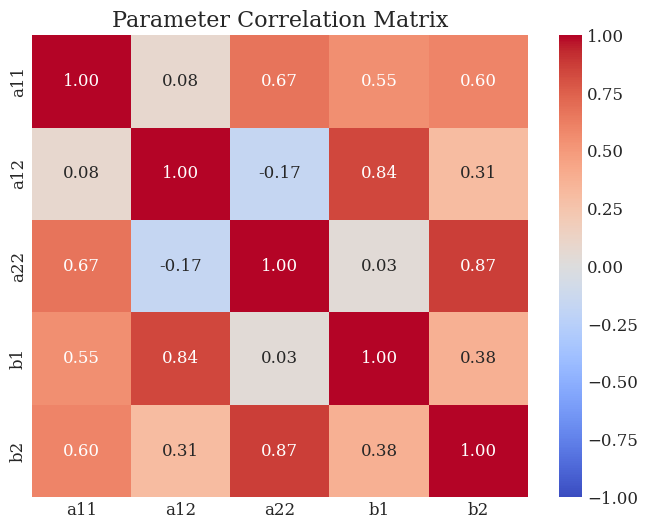

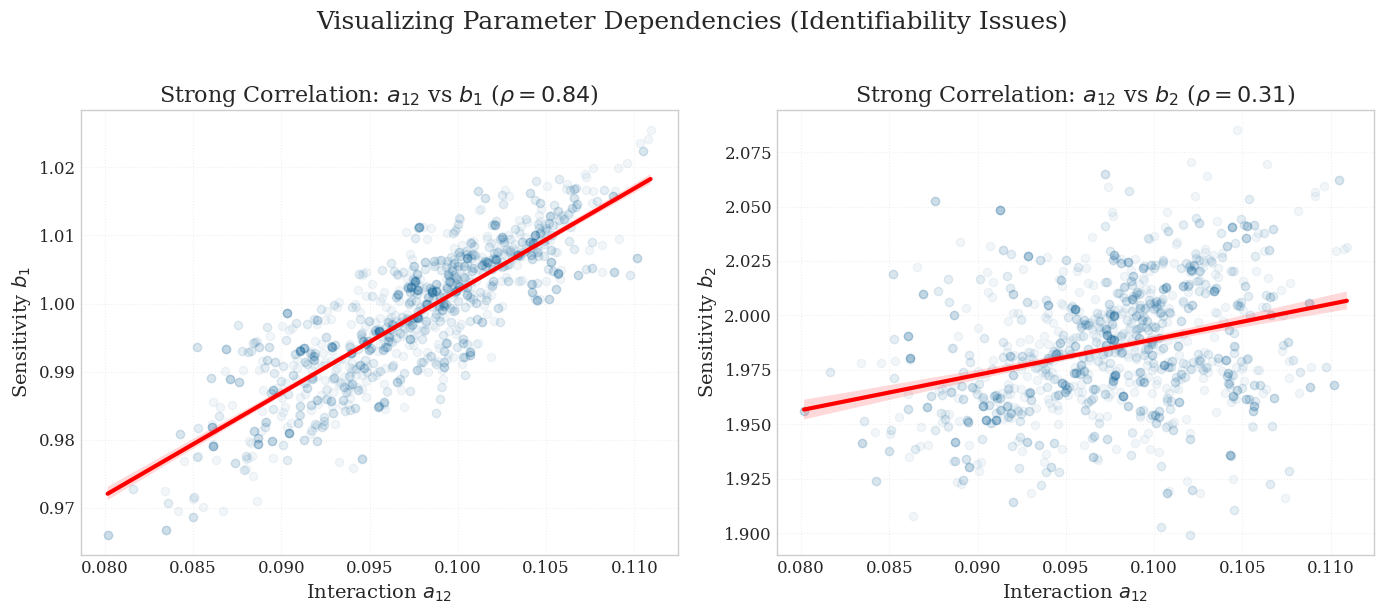

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import seaborn as sns
import pandas as pd

# スタイル設定
plt.rcParams.update({'font.size': 12, 'font.family': 'serif'})

# --- データの準備 ---
# flat_samples: [a11, a12, a22, b1, b2]
# indices: 0, 1, 2, 3, 4
param_names = [r"$a_{11}$", r"$a_{12}$", r"$a_{22}$", r"$b_{1}$", r"$b_{2}$"]

# Pandas DataFrame に変換（扱いやすくするため）
df = pd.DataFrame(flat_samples, columns=["a11", "a12", "a22", "b1", "b2"])

print("--- Correlation Analysis (Discussion Material) ---")

# 1. 相関行列の計算 (Pearson Correlation)
corr_matrix = df.corr()

# 論文にある特定のペアを確認
rho_a12_b1 = corr_matrix.loc["a12", "b1"]
rho_a12_b2 = corr_matrix.loc["a12", "b2"]
rho_a11_b1 = corr_matrix.loc["a11", "b1"]
rho_b1_b2  = corr_matrix.loc["b1", "b2"]

print(f"Correlation a12 vs b1: rho = {rho_a12_b1:.3f} (Paper says ~0.934)")
print(f"Correlation a12 vs b2: rho = {rho_a12_b2:.3f} (Paper says ~0.898)")
print(f"Correlation a11 vs b1: rho = {rho_a11_b1:.3f} (Paper says ~0.725)")
print(f"Correlation b1  vs b2: rho = {rho_b1_b2:.3f} (Paper says ~0.759)")

# 2. 相関行列のヒートマップ (全体像)
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt=".2f")
plt.title("Parameter Correlation Matrix")
plt.show()

# 3. 重要なペアの散布図 (詳細分析)
# 特に論文で言及されている「a12 vs b1」と「a12 vs b2」を可視化
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: a12 vs b1
sns.regplot(x="a12", y="b1", data=df, ax=axes[0],
            scatter_kws={'alpha':0.05, 'color':'#005b96'}, line_kws={'color':'red'})
axes[0].set_title(f"Strong Correlation: $a_{{12}}$ vs $b_1$ ($\\rho={rho_a12_b1:.2f}$)")
axes[0].set_xlabel(r"Interaction $a_{12}$")
axes[0].set_ylabel(r"Sensitivity $b_1$")
axes[0].grid(True, linestyle=':')

# Plot 2: a12 vs b2
sns.regplot(x="a12", y="b2", data=df, ax=axes[1],
            scatter_kws={'alpha':0.05, 'color':'#005b96'}, line_kws={'color':'red'})
axes[1].set_title(f"Strong Correlation: $a_{{12}}$ vs $b_2$ ($\\rho={rho_a12_b2:.2f}$)")
axes[1].set_xlabel(r"Interaction $a_{12}$")
axes[1].set_ylabel(r"Sensitivity $b_2$")
axes[1].grid(True, linestyle=':')

plt.suptitle("Visualizing Parameter Dependencies (Identifiability Issues)", y=1.02)
plt.tight_layout()
plt.show()